<a href="https://colab.research.google.com/github/GrabowMar/ProjektPJN/blob/main/entity_resolution_interactive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [271]:
# %pip install fuzzywuzzy
# %pip install python-Levenshtein
# %pip install spacy
# %python -m spacy download en_core_web_md
# %pip install pandas
# %pip install numpy
# %pip install matplotlib
# %pip install scikit-learn
# %pip install --upgrade jupyter ipywidgets
# %pip install --upgrade transformers
# %pip install --upgrade torch
# import os
# os.environ["CUDA_PATH"] = r"C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.2"
# print(f"CUDA_PATH set to: {os.environ['CUDA_PATH']}")

# **Entity Resolution with Text Similarity and Clustering**

This notebook walks through preprocessing text data, calculating similarity scores, and clustering entities. Results are displayed interactively at each step.

## **1. Import Libraries**

In [272]:

# Import required libraries
import pandas as pd
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from fuzzywuzzy import fuzz
import matplotlib.pyplot as plt
import seaborn as sns


## **2. Helper Functions**

### **2.1 Load Dataset**

In [273]:

def load_dataset(file_path):
    """Load the dataset from the specified CSV file."""
    try:
        df = pd.read_csv(file_path)
        print("Sample data:")
        display(df.head())
        return df
    except Exception as e:
        raise FileNotFoundError(f"Failed to load file {file_path}: {e}")


### **2.2 Load SpaCy Model**

In [274]:

def load_spacy_model(model_name="en_core_web_sm"):
    """Load the SpaCy NLP model."""
    try:
        nlp = spacy.load(model_name)
        print(f"SpaCy model '{model_name}' loaded successfully!")
        return nlp
    except Exception as e:
        raise ImportError(f"Failed to load SpaCy model {model_name}: {e}")


### **2.3 Preprocess Text**

In [275]:
import pandas as pd
import re

def preprocess_text(text):
    """Simplify preprocessing by removing stop words and punctuation."""
    if pd.isna(text):
        return ""
    # Lowercase the text and remove non-alphanumeric characters
    text = text.lower()
    text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation
    text = re.sub(r"\s+", " ", text).strip()  # Normalize whitespace
    return text

def preprocess_columns(df, columns):
    """Apply minimal preprocessing to specified columns."""
    for col in columns:
        if col in df.columns:
            df[f"processed_{col}"] = df[col].apply(preprocess_text)
    processed_cols = [f"processed_{col}" for col in columns if col in df.columns]
    print("Processed data preview:")
    display(df[processed_cols].head())
    return processed_cols


## **3. Compute Similarity**

### **3.1 TF-IDF Similarity**

In [276]:
def compute_similarity(df, columns, weights):
    """Calculate weighted similarity matrix with improved accuracy."""
    # Normalize weights to sum to 1
    weights = np.array(weights) / sum(weights)
    
    # Initialize similarity matrix
    n_samples = len(df)
    combined_similarity = np.zeros((n_samples, n_samples))
    
    for col, weight in zip(columns, weights):
        # Configure vectorizer with additional features
        vectorizer = TfidfVectorizer(
            analyzer='char_wb',  # Character n-grams including word boundaries
            ngram_range=(2, 4),  # Use 2-4 character n-grams
            max_features=10000,  # Limit features for efficiency
            lowercase=True,
            strip_accents='unicode',
            min_df=2  # Minimum document frequency
        )
        
        # Handle missing values and compute TF-IDF
        texts = df[col].fillna('')
        tfidf_matrix = vectorizer.fit_transform(texts)
        
        # Compute cosine similarity with length normalization
        similarity = cosine_similarity(tfidf_matrix)
        
        # Apply weight and add to combined similarity
        combined_similarity += similarity * weight
    
    # Normalize final similarity scores
    combined_similarity = np.clip(combined_similarity, 0, 1)
    
    # Visualize sample
    plt.figure(figsize=(8, 6))
    sns.heatmap(combined_similarity[:1000, :1000], annot=False, cmap="viridis")
    plt.title("TF-IDF Similarity (First 10 Rows)")
    plt.show()
    
    return combined_similarity


### **3.2 Fuzzy Matching**

In [277]:
from fuzzywuzzy import fuzz
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
import seaborn as sns
import matplotlib.pyplot as plt

def adjust_similarity_with_fuzzy(similarity_matrix, df, columns, n_jobs=-1):
    """Enhance similarity matrix using fuzzy matching with optimizations."""
    
    # Precompute string representations of relevant columns
    precomputed_strings = {
        col: df[col].astype(str).values for col in columns if col in df.columns
    }

    def compute_fuzzy_for_pair(i, j):
        # Compute fuzzy score for a specific pair (i, j)
        fuzzy_score = np.mean([
            fuzz.ratio(precomputed_strings[col][i], precomputed_strings[col][j]) / 100
            for col in precomputed_strings
        ])
        return i, j, fuzzy_score

    # Create list of all index pairs (i, j) where j > i
    pairs = [(i, j) for i in range(len(df)) for j in range(i + 1, len(df))]

    # Parallel computation of fuzzy scores
    results = Parallel(n_jobs=n_jobs)(
        delayed(compute_fuzzy_for_pair)(i, j) for i, j in pairs
    )

    # Update the similarity matrix with the computed fuzzy scores
    for i, j, fuzzy_score in results:
        similarity_matrix[i, j] = similarity_matrix[j, i] = max(similarity_matrix[i, j], fuzzy_score)

    print("Enhanced Similarity Matrix (Sample):")
    sns.heatmap(similarity_matrix[:1000, :1000], annot=False, cmap="plasma")
    plt.title("Enhanced Similarity (First 10 Rows)")
    plt.show()

    return similarity_matrix


## **4. Clustering**

In [278]:

def cluster_entities(similarity_matrix, threshold):
    """Cluster entities based on similarity scores."""
    clusters = []
    visited = set()
    for i in range(len(similarity_matrix)):
        if i not in visited:
            cluster = [i]
            visited.add(i)
            for j in range(len(similarity_matrix)):
                if j not in visited and similarity_matrix[i, j] > threshold:
                    cluster.append(j)
                    visited.add(j)
            clusters.append(cluster)
    print(f"Number of clusters formed: {len(clusters)}")
    return clusters


## **5. Visualize Clusters**

In [279]:

def visualize_clusters(df, clusters, columns):
    """Display entities in each cluster."""
    for cluster_id, cluster in enumerate(clusters):
        print(f"Cluster {cluster_id} (Size: {len(cluster)}):")
        display(df.iloc[cluster][columns])
        print("\n")


## **6. Main Workflow**

### **6.1 Input Parameters**

In [280]:
input_file = "restaurants.csv"  # Update with your file path
output_file = "resolved_entities.csv"
similarity_threshold = 0.8
text_columns = ["name", "address", "city", "phone", "category"]
weights = [0.4, 0.3, 0.1, 0.3, 0.1]


### **6.2 Run Workflow Step by Step**

#### **Step 1: Load Data**

In [281]:
df = load_dataset(input_file)

Sample data:


,name,address,city,phone,category,cluster
0,arnie mortot's of chicago,435 s. la cienega blv.,LA,310-246-1501,american,0
1,arnie morton's of chicago,435 s. la cienega blvd.,los angeles,310-246-1501,steakhouses,0
2,art's delicatessen,12224 ventura blvd.,studio city,818/762-1221,american,1
3,art's deli,12224 venturacblvd.,studio city,818-762-1221,delis,1
4,hotel bel-air,701 stone canyon rd.,bel air,310/472-1211,californian,2


#### **Step 2: Load SpaCy Model**

In [282]:
nlp = load_spacy_model()

SpaCy model 'en_core_web_sm' loaded successfully!


#### **Step 3: Preprocess Text**

In [283]:
processed_columns = preprocess_columns(df, text_columns)

Processed data preview:


,processed_name,processed_address,processed_city,processed_phone,processed_category
0,arnie mortots of chicago,435 s la cienega blv,la,3102461501,american
1,arnie mortons of chicago,435 s la cienega blvd,los angeles,3102461501,steakhouses
2,arts delicatessen,12224 ventura blvd,studio city,8187621221,american
3,arts deli,12224 venturacblvd,studio city,8187621221,delis
4,hotel belair,701 stone canyon rd,bel air,3104721211,californian


#### **Step 4: Compute Similarity**

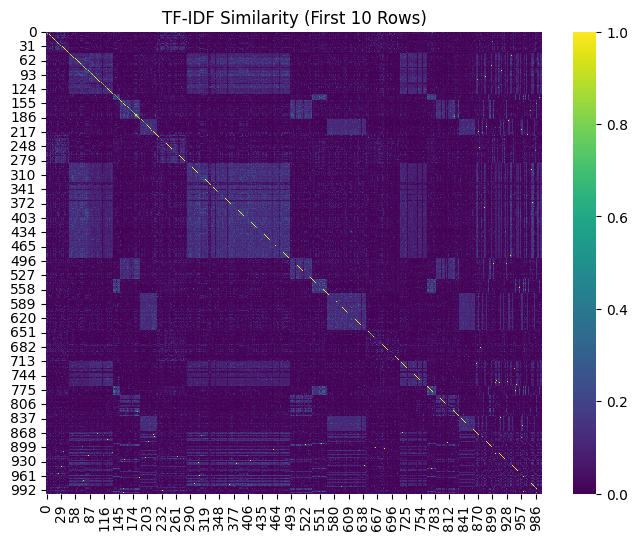

In [284]:
similarity_matrix = compute_similarity(df, processed_columns, weights)

#### **Step 5: Enhance Similarity with Fuzzy Matching**

Enhanced Similarity Matrix (Sample):


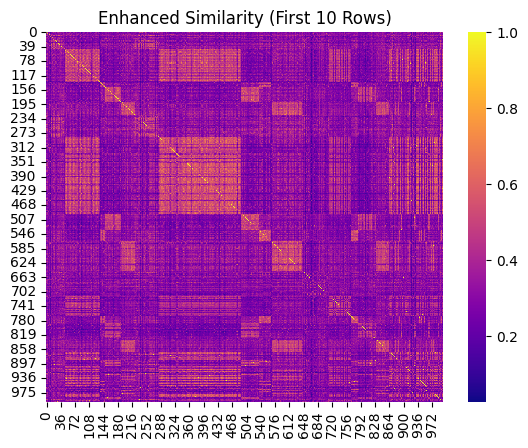

In [285]:
similarity_matrix = adjust_similarity_with_fuzzy(similarity_matrix, df, text_columns)

#### **Step 6: Perform Clustering**

In [286]:
clusters = cluster_entities(similarity_matrix, similarity_threshold)

Number of clusters formed: 800


#### **Step 7: Visualize Results**

In [287]:
visualize_clusters(df, clusters, text_columns)

Cluster 0 (Size: 2):


,name,address,city,phone,category
0,arnie mortot's of chicago,435 s. la cienega blv.,LA,310-246-1501,american
1296,arnie mortot's of chicago,435 s. la cienega blv.,LA,310-246-1501,american




Cluster 1 (Size: 1):


,name,address,city,phone,category
1,arnie morton's of chicago,435 s. la cienega blvd.,los angeles,310-246-1501,steakhouses




Cluster 2 (Size: 2):


,name,address,city,phone,category
2,art's delicatessen,12224 ventura blvd.,studio city,818/762-1221,american
3,art's deli,12224 venturacblvd.,studio city,818-762-1221,delis




Cluster 3 (Size: 2):


,name,address,city,phone,category
4,hotel bel-air,701 stone canyon rd.,bel air,310/472-1211,californian
1107,hotel bel-air,701 stone canyon rd.,Bel-Air,310/472/1211,californian




Cluster 4 (Size: 2):


,name,address,city,phone,category
5,bel-air hotel,701 stone canyon rd.,Belair,NaN,californian
1392,bel-air hotel,701 stone canyon rd.,Belair,NaN,californian




Cluster 5 (Size: 5):


,name,address,city,phone,category
6,cafe bizou,14016 ventura blvd.,sherman oaks,818-788-3536,frenph
7,cafe bizou,14016 ventura blvd.,sherman oaks,818-788-3536,french bistro
1090,cafe bibou,14016 ventura blvd.,sherman oaks,818/788/3536,frenph
1277,cafe bizou,14016 ventura blvd.,sherman oaks,818-788-3536,french bistro
1735,cafe bszou,14016 ventura blvd.,sherman oaks,818-788-3536,frenph




Cluster 6 (Size: 3):


,name,address,city,phone,category
8,campanile,624 s. la brea ave.,los angeles,213/938-1447,american
9,campenile,624 s. la brea ave.,LosAngeles,213/938/1447,californian
1698,campanile,624 s. la brea ave.,Los Angeles,213/938/1447,american




Cluster 7 (Size: 3):


,name,address,city,phone,category
10,chinois on main,NaN,santa monica,NaN,french
1271,chinois on main,NaN,santa monica,NaN,french
1687,chinois on main,NaN,santa monica,NaN,french




Cluster 8 (Size: 1):


,name,address,city,phone,category
11,chinois on main,2709 mann st.,santa monica,NaN,pacific new wave




Cluster 9 (Size: 3):


,name,address,city,phone,category
12,citrus,6a03 melrose ave.,los angeles,213/857-0034,californian
13,citrts,6703 melrose ave.,los angeles,213-857-0034,californian
1729,citrts,6703 melrose ave.,los angeles,213-857-0034,californian




Cluster 10 (Size: 3):


,name,address,city,phone,category
14,fenix,8358 sunset blvd. west,hollywood,213/848-6677,american
1161,fenix,8358 sunset blvd. west,hollywood,213/848-6677,american
1162,fenix,8358 sunset blvd. west,hollywood,213/848-6677,american




Cluster 11 (Size: 1):


,name,address,city,phone,category
15,fenix at the argyle,8358 sunset blvd.,w. hollywood,213-848-6677,french (new)




Cluster 12 (Size: 4):


,name,address,city,phone,category
16,granita,23725 w. malibu rd.,malibu,310/456-0488,californiln
17,granita,23725 w. malibu rd.,malibu,310-456-0488,ialifornian
1368,granita,23725 w. malibu rd.,malibu,310/456-0488,californiln
1502,granita,23725 w. malibu rd.,malibu,310-456-0488,ialifornian




Cluster 13 (Size: 1):


,name,address,city,phone,category
18,grill on the alley,9560 dayton way,los angeles,(310) 276-0615,american




Cluster 14 (Size: 3):


,name,address,city,phone,category
19,grill the,9560 dayton way,beverly hills,310-276-0615,NaN
868,grill the,9560 dayton way,beverly hills,310-276-0615,NaN
1289,grill the,9560 dayton way,beverly hills,310-276-0615,NaN




Cluster 15 (Size: 5):


,name,address,city,phone,category
20,restaubant katsu,1972 n. hillhurst ave.,los angeles,213/665-1891,asian
899,restaubant katsu,1972 n. hillhurst ave.,los angeles,213-665-1891,asian
1257,resaaubant katsu,1972 n. hillhurst ave.,los angeles,213/665-1891,asian
1446,restaubant katsu,1972 n. hillhurst ave.,LosAngeles,213/665-1891,asian
1738,restaubant katsu,1972 n. hillhurst ave.,Los Angeles,213/665.1891,asian




Cluster 16 (Size: 2):


,name,address,city,phone,category
21,katsu,1972 hillhurst ave.,los feliz,213-665-1891,japanese
1063,katso,1972 hillhurst ave.,los feliz,213-665-1891,japanese




Cluster 17 (Size: 2):


,name,address,city,phone,category
22,l'orangerie,903 n. la cienega blvd.,los angeles,310/652-9770,french
23,l'orangerie,903 n. la cienega blvd.,w. hollywood,310-652-9770,french (classic)




Cluster 18 (Size: 5):


,name,address,city,phone,category
24,le chardonnay,8284 melrose ave.,Los Angeles,213/655-8880,french
25,le chardonnay (los angeles),8284 melrose ave.,los angeles,213/655/8880,french bvstro
956,le chardonnay (los angeles),8284 melrose ave.,los angeles,213/655/8880,french bvstro
1244,le chardonnay (los angeles),8284 melrose ave.,los angeles,213-655-8880,french bvstro
1367,le chardonnay,8284 melrose ave.,Los Angeles,213/655-8880,french




Cluster 19 (Size: 2):


,name,address,city,phone,category
26,locanda veneta,3rd st.,los angeles,(310) 274-1893,italian
1544,locanda veneta,3rd st.,Los Angeles,((31) ) 274-1893,italian




Cluster 20 (Size: 1):


,name,address,city,phone,category
27,locanda veneta,NaN,LA,310-274-1893,italian




Cluster 21 (Size: 4):


,name,address,city,phone,category
28,matsuhwsa,129 n. la ciekega blvd.,beverly hills,310/659-9639,asian
29,matsuhisa,129 n. la cienega blvd.,beverly hills,310-659-9639,seafood
999,matsuhisa,129 n. la cienega blvd.,beverly hills,310-659-9639,seafood
1141,matsuhisa,129 n. la cienega blvd.,beverly hills,310/659/9639,seafood




Cluster 22 (Size: 2):


,name,address,city,phone,category
30,the palm,9001 saxta monica blvd.,los angeles,310/550-8811,american
941,the palm,9001 saxta monica blvk.,los angeles,310/550-8811,american




Cluster 23 (Size: 3):


,name,address,city,phone,category
31,palm thw (los angeles),9001 santa monica blvd.,w. hollywood,310-550-8811,steakhouses
1146,palm thw (los angeles),9001 santa monica blvd.,w. hollywood,310-550-8811,steakhouses
1315,palm thw (los angeles),9001 santa monica blvd.,w. hollywood,310-550-8811,steakhouses




Cluster 24 (Size: 4):


,name,address,city,phone,category
32,patina,5955 melrose ave.,LosAngeles,213/467-1108,californian
33,patina,5955 melrose ave.,los angeles,213-467-1108,californian
1290,patina,5955 melrose ave.,LA,213/467/1108,californian
1583,patina,5955 melrxse ave.,LosAngeles,213/467/1108,yalifornian




Cluster 25 (Size: 3):


,name,address,city,phone,category
34,philippe's the original,1001 n. alameda st.,los angeles,213/628-3781,american
1039,philippe's the original,1001 n. alameda st.,los angeles,213/628-3781,american
1249,philippe's the original,1001 n. alameda st.,los angeles,213/628-3781,american




Cluster 26 (Size: 3):


,name,address,city,phone,category
35,philippe the original,100d n. alameda st.,chinatown,213-628-3781,cafeterias
908,philippe the original,100d n. alameda st.,chinatown,213-628-3781,cafeterias
1338,philippe the original,100d n. alameda st.,chinatown,213-628-3781,cafeterias




Cluster 27 (Size: 2):


,name,address,city,phone,category
36,pinot bistro,12969 ventura blvd.,los angeles,818/990-0500,french
1545,pinot bistro,12969 ventura blvd.,los angeles,818-990-0500,french




Cluster 28 (Size: 4):


,name,address,city,phone,category
37,pinot bistmo,12969 ventura blvd.,Studio Cty,818-990-0500,NaN
1256,pinot bistmo,12969 ventura blvd.,Studio Cty,818-990-0500,NaN
1363,pinot bistmo,12969 ventura blvd.,Studio Cty,818-990-0500,NaN
1586,pinot bissmo,12969 uentura blvd.,Studio Cty,818.990.0500,NaN




Cluster 29 (Size: 5):


,name,address,city,phone,category
38,rex il ristorante,617 s. olive st.,los angeles,213/627-2300,italiag
39,rex il ristorante,617 s. olive st.,los angeles,213.627.2300,nuova cucina italian
1364,rex il ristorante,617 s. olive st.,los angeles,213.627.2300,nuova cucina italian
1409,rex il eistorante,617 s. olive st.,Los Angeles,213.627.2300,nuova cucina italicn
1720,rel il ristorante,617 s. olive st.,LA,213/627-2300,italiag




Cluster 30 (Size: 2):


,name,address,city,phone,category
40,spago,1114 hocn ave.,NaN,310/652-4025,californian
1192,spagj,1114 hocn ave.,NaN,310/652-4025,californian




Cluster 31 (Size: 1):


,name,address,city,phone,category
41,spago (los angeles),8795 sunset blvd.,w. hollywood,310-652-4025,californian




Cluster 32 (Size: 4):


,name,address,city,phone,category
42,valentino,3115 pico blvd.,santa monica,310/829-4313,italian
43,valentino,3115 pico blvd.,santa monica,310-829-4313,italian
979,valentino,3115 pico blvd.,santa monica,(310) 829-4313,italian
1451,valentino,3115 pico blvd.,santa monica,310/829-4313,italian




Cluster 33 (Size: 1):


,name,address,city,phone,category
44,yujean kang's gourmet chinese cuisine,67 n. raymond ave.,los angeles,818/585-0855,asian




Cluster 34 (Size: 1):


,name,address,city,phone,category
45,yujean kang's,67 n. raymond ave.,pasadena,818-585-0855,chinese




Cluster 35 (Size: 1):


,name,address,city,phone,category
46,21 club,21 w. 52nd st.,new york,212-582-7200,american




Cluster 36 (Size: 3):


,name,address,city,phone,category
47,21 club,21 w. 52nd st.,new york city,NaN,NaN
1577,21 club,21 w. 52nd st.,new york city,NaN,NaN
1688,21 club,21 w. 52nd st.,new york city,NaN,NaN




Cluster 37 (Size: 4):


,name,address,city,phone,category
48,aquavit,13 w. 54th st.,new york,212/307-7311,oontinental
49,aquavit,13 w. 54th st.,new york city,212-307-7311,scandinavian
1321,aquavit,13 w. 54th st.,new york city,212-307-7311,scandinavian
1432,aquavit,13 w. 54th st.,new york,212/307-7311,oontinental




Cluster 38 (Size: 5):


,name,address,city,phone,category
50,aureole,34 e. 61st st.,new york,212/ 319-1660,american
51,aureole,34 e. 61st st.,new york city,212-319-1660,american (new)
937,aureole,34 e. 61st st.,new york,212/ 319-1660,american
1394,aureole,34 e. 61st st.,new york,212/ 319-1660,american
1510,aureole,34 e. 61st st.,new york,212/ 319.1660,american




Cluster 39 (Size: 5):


,name,address,city,phone,category
52,cafe lalo,201 w. 83rd st.,new york,212/496-6031,coffee bar
53,cafe valo,201 w. 83rd st.,new york city,212-496-6031,cogfeehouses
1124,cafe laxo,201 w. 83rd st.,new york,212/496-6031,coffee bar
1637,cafe valo,201 w. 83rd st.,new york city,212-496-6031,cogfeehouses
1643,cafe valo,201 w. 83rd st.,new york city,212-496-6031,cogfeehouses




Cluster 40 (Size: 4):


,name,address,city,phone,category
54,cafe des artistes,1 w. 67th st.,new york,212/877-3500,continental
55,cafe des artistes,1 w. 67th st.,new york city,212-877-3500,french (classic)
1041,cafe des artistes,1 w. 67th st.,new york,212/877-3500,continental
1418,cafe des artistes,1 w. 67th st.,new york,212/877-3500,continental




Cluster 41 (Size: 2):


,name,address,city,phone,category
56,carmine's,2450 broadway between 90th and 91st sts.,new york,212/362-2200,NaN
57,carmine's,2450 broadway,new york city,212-362-2200,italian




Cluster 42 (Size: 7):


,name,address,city,phone,category
58,carnegie deli,854 7th ave. between 54th and 55th sts.,new york,212/757-2245,delicatedsen
464,stage deli,834 7th ave. between 53rd and 54th sts.,new york,212/245-7850,delicatessen
981,carnegie deli,854 7th ave. between 54th and 55th svs.,new york,212/757-2245,delicatedsen
1009,carnegie deli,854 7th ave. bezween 54th and 55th sts.,new york,212/757-2245,delicatedsen
1106,stage deli,834 7th ave. between 53rd and 54th sts.,new york,212-245-7850,delicatessen
1422,carnegie deoi,854 7th ave. between 54th and 55th sts.,new york,212/757-2245,delicatedsen
1504,carnegie deli,854 7th ave. between 54th and 55th sts.,new york,212-757-2245,delicatedsen




Cluster 43 (Size: 2):


,name,address,city,phone,category
59,carnegie deli,854 seventh ave.,new york city,212-757-2245,delis
1070,carnegie deli,854mseventh ave.,new york city,212-757-2245,delis




Cluster 44 (Size: 3):


,name,address,city,phone,category
60,chanterelle,2 harrison st. near hudson st.,new york,212/966-6960,american
1311,chanterehle,2 harrisfn st. near hudson st.,new york,212/966-6960,american
1692,chanterelle,2 harrison st. near hudson st.,new york,212/966-6960,american




Cluster 45 (Size: 2):


,name,address,city,phone,category
61,chanterelle,2 harrison st.,NaN,212.966.6960,french (new)
1058,chantewelle,2 harrison st.,NaN,212.966.6960,french (new)




Cluster 46 (Size: 7):


,name,address,city,phone,category
62,daniel,20 e. 76th st.,new york,212/288-0033,french
63,daniel,20 e. 76th st.,new york city,212-288-0033,french (new)
1258,daniel,20 e. 76th st.,new york city,212-288-0033,french (new)
1291,daniel,20 e. 76th st.,new york,212/288-0033,french
1626,danuel,20 e. 76th st.,new york,212/288-0033,french
1666,daniel,20 e. 76th st.,new york city,212-288-0033,french (new)
1691,daniel,20 e. 76th st.,new york,212/288-0033,french




Cluster 47 (Size: 5):


,name,address,city,phone,category
64,dawat,210 e. 58th st.,new york,212/355-7555,asian
65,dawat,210 e. 58th st.,new york city,212-355-7555,indian
1087,dawat,210 e. 58th st.,new york,212/355-7555,asian
1154,dawaw,210 e. 58th st.,new york,212/355.7555,asian
1373,dawat,210 e. 58th st.,new york city,(212) 355-7555,indian




Cluster 48 (Size: 2):


,name,address,city,phone,category
66,felidia,243 e. 58th st.,new york,212/758-1479,italian
67,felidia,243 e. 58th st.,new york city,212-758-1479,italian




Cluster 49 (Size: 3):


,name,address,city,phone,category
68,four seasons grill room,99 e. 52nd st.,new york,212/754-9494,american
1076,four seasons grill room,99 e. 52nd st.,new york,212/754-9494,american
1496,four seasons grill room,99 e. 52nd st.,new york,212/754.9494,american




Cluster 50 (Size: 1):


,name,address,city,phone,category
69,NaN,99 e. 52nd st.,new york city,212/754/9494,american (new)




Cluster 51 (Size: 2):


,name,address,city,phone,category
70,gotham bar & grill,NaN,new york,212-620-4020,american
1642,gotham bar & grill,NaN,new york,212-620-4020,american




Cluster 52 (Size: 3):


,name,address,city,phone,category
71,gotham bar & grill,12 e. 12th st.,new york city,212-620-4020,american (new)
1285,gotham bar & grill,12 e. 12th st.,new york city,212-620-4020,american (new)
1728,gotham bar & grill,12 e. 12th st.,new york city,212-620-4020,american (new)




Cluster 53 (Size: 6):


,name,address,city,phone,category
72,gramercy tavern,42 e. 20th st. between park ave. s and broadway,new york,212/477-0777,american
870,gramercy tavern,42 e. 20th st. between park ave. s and broadway,new york,212/477-0777,american
1153,gramercy tavern,42 e. 20th st. between park ave. s and broadway,new york,212/477-0777,american
1302,gramercy tavern,42 e. 20th st. lbetween park ave. s and broadway,new york,212-477-0777,american
1445,gracercy tavern,42 e. 20th st. between park ave. s and broadway,new york,212/477-0777,american
1683,gramercy tavern,42 e. 20th st. between park ave. s and broadway,new york,212/477-0777,american




Cluster 54 (Size: 2):


,name,address,city,phone,category
73,gramercy tavhrn,42 e. 20th st.,new york city,(212) 477-0777,NaN
897,gramercy tavhrn,42 e. 20th st.,new york city,(212) 477-0777,NaN




Cluster 55 (Size: 6):


,name,address,city,phone,category
74,island spice,402 w. 44th st.,new york,212/765-1737,tel caribbean
75,island spice,402 w. 44th st.,new york city,212-765-1737,caribbean
971,island spice,402 w. 44th st.,new york city,212-765-1737,caribbean
1126,island spice,402 w. 44ih st.,new york city,212-765-1737,caribbean
1340,island spice,402 w. 44th st.,new york city,212-765-1737,caribbean
1524,island szice,402 w. 44th st.,new york,(212) 765-1737,tel caribbean




Cluster 56 (Size: 5):


,name,address,city,phone,category
76,jo jo,160 e. 64th st.,new york,212/223/5656,american
77,jo jo,160 e. 64th st.,NaN,212-223-5656,NaN
1475,jo jo,160 e. 64th st.,NaN,212/223/5656,NaN
1528,jo jo,160 e. 64th st.,new york,212/223/5656,american
1613,jo jo,160 e. 64th st.,new york,212/223/5656,amerivan




Cluster 57 (Size: 2):


,name,address,city,phone,category
78,la caravelle,33 w. 55th st.,new york,212/586-4252,french
79,la caravelle,33 w. 55th st.,new york city,212-586-4252,french (claasic)




Cluster 58 (Size: 1):


,name,address,city,phone,category
80,la cote basque,60 w. 55th st. between 5th and 6th ave.,new york,212/688-6525,french




Cluster 59 (Size: 2):


,name,address,city,phone,category
81,la cote basque,NaN,new york city,212-688-6525,french (classic)
1361,la cote basque,NaN,new york city,212/688/6525,french (classic)




Cluster 60 (Size: 4):


,name,address,city,phone,category
82,le bernardin,155 w. 51st st.,new york,212/489-1515,french
955,le bernardin,155 w. 51st st.,new york,212/489-1515,french
1078,le bernardin,155 w. 51st st.,new york,212/489-1515,irench
1081,le bernardin,155 w. 51st st.,new york,212/489-1515,french




Cluster 61 (Size: 2):


,name,address,city,phone,category
83,NaN,155 w. 51st st.,new york city,212-489-1515,seafood
1022,NaN,155 w. 51st st.,new york city,212-489-1515,seafood




Cluster 62 (Size: 3):


,name,address,city,phone,category
84,les celebrites,160 central park s,new york,212/484-5113,french
917,les celebrites,160 central park s,new york,212/484-5113,french
1567,les celebritgs,160 central park s,new york,(212) 484-5113,french




Cluster 63 (Size: 1):


,name,address,city,phone,category
85,les celebrites,155 w. 58th st.,new york city,212-484-5113,french (classic)




Cluster 64 (Size: 1):


,name,address,city,phone,category
86,lespinasse,2 e. 55th st.,new york,212/339-6719,american




Cluster 65 (Size: 1):


,name,address,city,phone,category
87,lespinasse (new york city),2 e. 55th st.,new york city,(212) 339-6719,asian




Cluster 66 (Size: 2):


,name,address,city,phone,category
88,lutece,249 e. 50th st.,new york,NaN,french
1400,lutece,249 e. 50th st.,new york,NaN,french




Cluster 67 (Size: 3):


,name,address,city,phone,category
89,lutece,249 e. 50th st.,new york city,212-752-2225,french (classic)
1455,lutece,249 e. 50th st.,new york city,212-752-2225,french (classic)
1629,lutece,249 e. 50th st.,new york city,212-752-2225,french (classic)




Cluster 68 (Size: 4):


,name,address,city,phone,category
90,manhattan ocean club,57 w. 58th st.,new york,212/ 371.7777,seafood
91,manhattan ocean club,57 w. 58th st.,new york city,212/371/7777,seafood
1098,manhattan ocean club,57 w. 58th st.,new york,212/ 371.7777,seafood
1384,manhattan ocean club,57 w. 58th st.,new york,212/ 371.7777,seafood




Cluster 69 (Size: 4):


,name,address,city,phone,category
92,march,405 e. 58th st.,new york,212/754-6272,american
93,march,405 e. 58th st.,new york city,212-754-6272,american (new)
1220,march,405 e. 58th st.,new york city,212-754-6272,american (new)
1369,malch,405 e. u8th st.,new york,212/754-6272,american




Cluster 70 (Size: 5):


,name,address,city,phone,category
94,mesa grill,102 5th ave. between 15th and 16th sts.,new york,212/807-7400,american
912,mesa grill,102 5th ave. between 15th and 16th sts.,new york,212/807-7400,american
950,mesa grill,102 5th ave. between 15th and 16th sts.,new york,212/807-7400,american
1031,mesa grill,102 5th ave. between 15th and 16th sts.,new york,212/807-7400,american
1123,mesa grill,102 5th ave. between 15th and 16th sts.,new york,212/807-7400,american




Cluster 71 (Size: 3):


,name,address,city,phone,category
95,mesa grill,102 fifth ave.,new york city,212-807-7400,southwestern
1049,mqsa grill,102 fifth ave.,new york city,(212) 807-7400,southwestern
1521,mesa grill,102 fifth ave.,new york city,212-807-7400,southwestern




Cluster 72 (Size: 4):


,name,address,city,phone,category
96,mi cocina,57 jane st. off hudson st.,new york,212/627.8273,mexican
97,mi cocina,57 jane st.,new york city,212-627-8273,mexican
885,mi cocina,57 jane st.,new york city,212-627-8273,mexican
1239,mi cocina,57 jans st.,new york city,212-627-8273,mexican




Cluster 73 (Size: 1):


,name,address,city,phone,category
98,montrachet,239 w. broadway between walker and white sts.,new york,212/ 219-2777,french




Cluster 74 (Size: 1):


,name,address,city,phone,category
99,montrachet,239 w. broadway,new york city,212-219-2777,french bistro




Cluster 75 (Size: 3):


,name,address,city,phone,category
100,oceana,55 e.s54th st.,new york,212/759-5941,seafood
101,oceana,55 e. 54th st.,new york city,212-759-5941,seafood
1574,oceana,55 e. 54th st.,new york city,212-759-5941,seafood




Cluster 76 (Size: 7):


,name,address,city,phone,category
102,park avenue cafe,100 e. 63rd st.,new york,212/644-1900,american
103,park avenue cafe (new york city),100 e. 63rd st.,new york city,212-644-1900,american (new)
869,park avenue cafe,100 e. 63rd st.,new york,212/644/1900,american
1103,park avenue cafe (new york cityh,100 o. 63rd st.,new york city,212-644-1900,american (new)
1295,park avenue cafe,100 e. 63rd st.,new york,212/644/1900,americgn
1353,park avenue cafe,100 e. 63rd st.,new york,212/644/1900,american
1388,park avenue cafe,100 e. 63rd st.,new york,212/644-1900,american




Cluster 77 (Size: 2):


,name,address,city,phone,category
104,NaN,182 w. 58th st.,new york,212/245-2214,french
1310,NaN,182 w. 58th st.,new york,212/245-2214,french




Cluster 78 (Size: 4):


,name,address,city,phone,category
105,petrossian,182 w. 58th st.,new york city,212-245-2214,russian
1207,petrossian,182 w. 58th st.,new york city,212-245-2214,russian
1269,petrosgian,182 w. 58th st.,new york city,212-245-2214,russian
1625,petrossian,182 w. 58th st.,new york city,212-245-2214,russian




Cluster 79 (Size: 3):


,name,address,city,phone,category
106,piqholine,35 w. 64th st.,new york,212/724-8585,mediterranean
107,picholine,35 w. 64th st.,new york city,212-724-8585,mediterranean
1298,piqholine,35 w.w64th st.,new york,212/724-8585,mediterranean




Cluster 80 (Size: 7):


,name,address,city,phone,category
108,pisces,95 ave. a at 6th st.,new york,212-260-6660,seafood
109,pisces,95 ave. a,new york city,(212) 260-6660,seafood
996,pisces,95 ave. a,new york city,(212) 260-6660,seafood
1017,pisces,95 ave. a at 6th st.,new york,212-260-6660,seafood
1251,pisces,95 ave. a at 6th st.,new york,212-260-6660,seafood
1326,pisces,95 ave. a,new york city,(212) 260-6660,seafood
1715,pisces,95 ave. a,new york city,(212) 260.6660,seafood




Cluster 81 (Size: 6):


,name,address,city,phone,category
110,rainbow room,30 rockefeller plaza,new york,212/632-5000,or 212/632-5100 american
111,rainbow room,30 rockefeller plaza,new york city,212-632-5000,american (new)
1091,rainbow room,30 rockefeller plaza,new york,212-632-5000,or 212/632-5100 american
1181,rainbow room,30 rockefeller plaza,new york,212/632-5000,or 212/632-5100 american
1592,rainbow room,30 rockefbller plaza,new york,212/632-5000,or 212/632-5100 american
1615,rainbow room,30 rockefeller plaza,new york city,212-632-5000,american (new)




Cluster 82 (Size: 2):


,name,address,city,phone,category
112,river cafe,1 water st. at the east river,brooklyn,718/522-5200,american
1517,river cafe,1 water st. at the east river,brooklyn,718/522-5200,american




Cluster 83 (Size: 1):


,name,address,city,phone,category
113,river cafe,1 water st.,NaN,718-522-5200,NaN




Cluster 84 (Size: 3):


,name,address,city,phone,category
114,sanbdomenico,240 central park s,new york,212/265-5959,italian
1185,sanbdomenico,240 central park s,new york,212/265-5959,iialian
1389,sanbdomenico,240 central park s,new york,212/265-5959,italian




Cluster 85 (Size: 2):


,name,address,city,phone,category
115,san domenico,240 central park s.,new york city,212-265-5959,NaN
1403,san domenico,240 central park s.,new york city,212-265-5959,NaN




Cluster 86 (Size: 1):


,name,address,city,phone,category
116,second avenue deli,156 2nd ave. at 10th st.,new york,NaN,delicatessen




Cluster 87 (Size: 1):


,name,address,city,phone,category
117,second avenue deli,NaN,new york city,212-677-0606,delis




Cluster 88 (Size: 6):


,name,address,city,phone,category
118,seryna,11 e. 53rd st.,new york,212/980-9393,asian
119,seryna,11 e. 53rd st.,new york city,212-980-9393,japanese
1008,seryna,11 e. 53rd st.,new york city,212-980-9393,japanese
1568,seryna,11 e. 53rd st.,new york city,(212) 980-9393,japanese
1686,seryna,11 e. 53rd st.,new york,212/980-9393,asian
1707,seryna,11 e. 53rd st.,new york,212/980-9393,asian




Cluster 89 (Size: 1):


,name,address,city,phone,category
120,shun lee west,43 w. 65th st.,new york,212/371-8844,asian




Cluster 90 (Size: 3):


,name,address,city,phone,category
121,shun lee palace,155 e. 55th st.,new york city,212-371-8844,chinese
911,shun lee palace,155 e. 55th st.,new york city,212-371-8844,chinese
1356,shun lee palace,155 e. 55th st.,new york city,212-371-8844,chinese




Cluster 91 (Size: 2):


,name,address,city,phone,category
122,sign of twe dove,111g 3rd ave. at 65th st.,new york,212/861-8080,american
1650,sign of twe dove,111g 3rd ave. at 65th st.,new york,212/861-8080,american




Cluster 92 (Size: 3):


,name,address,city,phone,category
123,sign of the dove,1110 third ave.,new york city,212/861/8080,american (new)
882,sign of the dove,1110 third ave.,new york city,212/861/8080,american (new)
1083,sign of the dove,1110 third ave.,new york city,212/861/8080,american (new)




Cluster 93 (Size: 2):


,name,address,city,phone,category
124,smith & wollensky,201 e. 49th st.,new york,212/753-1530,ameyican
1115,smith & wollensky,201 e. 49th st.,new york,212/753-1530,ameyican




Cluster 94 (Size: 2):


,name,address,city,phone,category
125,smith & wollensky,797 third ave.,new york city,212-753-1530,steakhouses
1495,smithu& wollensky,797 third ave.,new york city,(212) 753-1530,steakhouses




Cluster 95 (Size: 2):


,name,address,city,phone,category
126,tavern on the green,in central park at 67th st.,new york,212/873-3200,american
127,tavern on the green,central park west,new york city,212-873-3200,american (dew)




Cluster 96 (Size: 2):


,name,address,city,phone,category
128,NaN,747 9th ave. between 50th and 51st sts.,new york,212/315-1726,mediterranean
948,NaN,747 9th ave. between 50th and 51st sts.,new york,212/315.1726,mediterranean




Cluster 97 (Size: 1):


,name,address,city,phone,category
129,uncle nick's,747 ninth ave.,new york city,212-245-7992,greek




Cluster 98 (Size: 4):


,name,address,city,phone,category
130,union square cafe,21 e. 16th st.,new york,212/243-4020,gmerican
131,union square cafe,21 e. 16th st.,new york city,212-243-4020,american (new)
1309,union square cafe,21 e. 16th st.,new york,212/243-4020,gmprican
1516,union square cafe,21 e. 16th st.,new york,212/243-4020,gmerican




Cluster 99 (Size: 3):


,name,address,city,phone,category
132,virgil's,152 w. 44th st.,new york,212/ 921-9494,american
910,virgil's,152 w. 44th st.,new york,212/ 921-9494,american
1564,virgil's,152 w. 44th st.,new york,212/ 921-9494,american




Cluster 100 (Size: 3):


,name,address,city,phone,category
133,virgil's real bbq,152 w. 44th st.,new york city,212-921-9494,bbb
1133,virgil's real bbq,152 w. 44th st.,new york city,212-921-9494,bbb
1680,virgil's real bbq,152 w. 44th st.,new york city,212-921-9494,bbb




Cluster 101 (Size: 4):


,name,address,city,phone,category
134,chin's,3200 las vegas blvd. s,las vegas,702/733-8899,asian
135,chin's,3200 las vegas blvd. s.,las vegas,702-733-8899,chinese
773,madame ching's,3300 las vegas blvd. s.,las vegas,702-894-7111,asian
1376,czin's,3200 las vegas blvd. s,las vegas,702/733-8899,asiai




Cluster 102 (Size: 1):


,name,address,city,phone,category
136,coyote cafe,NaN,las vegas,702/891.7349,southwestern




Cluster 103 (Size: 2):


,name,address,city,phone,category
137,coyote cafe (las vegas),3799 las vegas blvd. s.,las vegas,702-891-7349,southwestern
1292,coyote cafe (las vegas),3799 las vegas blvd. s.,las vegas,702/891/7349,southwestern




Cluster 104 (Size: 1):


,name,address,city,phone,category
138,le mwntrachet,3000 w. paradisedrd.,las vegas,702/732-5111,continental




Cluster 105 (Size: 1):


,name,address,city,phone,category
139,le montrachet bistro,3000 paradise rd.,las vegas,702-732-5651,french bistro




Cluster 106 (Size: 1):


,name,address,city,phone,category
140,palace court,3570 las vegas blvd. s,las vegas,702/731-7547,continental




Cluster 107 (Size: 1):


,name,address,city,phone,category
141,palace court,3570 las vegas blvd. s.,NaN,702-731-7110,french (new)




Cluster 108 (Size: 1):


,name,address,city,phone,category
142,second street grille,200 e. fremont st.,las vegas,702/385-3232,seafood




Cluster 109 (Size: 3):


,name,address,city,phone,category
143,second street grill,200 e. fremont st.,las vegas,702-385-6277,pacific rim
994,second street grill,200 e. fremont sa.,las vegas,702-385-6277,pacific rim
1355,second street grill,200 e. fremont st.,las vegas,702-385-6277,pacific rim




Cluster 110 (Size: 1):


,name,address,city,phone,category
144,NaN,288y las vegas blvd. s,las vegas,702/734/0410,steak houses




Cluster 111 (Size: 1):


,name,address,city,phone,category
145,steak house the,2880 las vegas blvd. s.,las vegas,702-734-0410,steakhousel




Cluster 112 (Size: 4):


,name,address,city,phone,category
146,tillerman,2245 e. flamingo rd.,las vegas,702/731-4036,seafood
147,tillerman the,2245 e. flaminko rd.,las vegas,702-731-4036,steakhouses
1515,tillerman,2245 e. flamingo rd.,las vegas,702/731-4036,seafooi
1540,tillerman the,2245 e. flaminko rd.,las vegas,702-731-4036,steakhouses




Cluster 113 (Size: 5):


,name,address,city,phone,category
148,abruzzi,2355 peachtree rd. peachtree battle shopping ...,atlanta,404/261-8186,itaxian
149,abruzzi,2355 peachtree rd. ne,atlanta,404-261-8186,italian
1313,abruzzi,2355 peachtree rd. peachtree battle shopping ...,atlanta,404/261-8186,itaxian
1442,abruzzi,2355 peachtree rd. ne,atlanta,404-261-8186,italian
1537,abruzzi,2355 peachtree rd. peachtree battle shopping ...,atlanta,404/261-8186,itaxian




Cluster 114 (Size: 4):


,name,address,city,phone,category
150,bacchanalia,3125 piedmont rd. near peachtree rd.,atlanta,404/365-0410,internationcl
151,bacchanalia,3125 piedmont rd.,atlanta,404-365-0410,californian
1590,bacchanalia,3125 piedmont rd.,atlanta,404-365-0410,californian
1733,bacchanalia,3125 piedmont rd. near peachtree rd.,atlanta,404/365-0410,internationcl




Cluster 115 (Size: 3):


,name,address,city,phone,category
152,bone's,3130 piedmont road,atlanta,404/237-2663,american
1287,boneos,3130 piedmont road,atlanta,404/237-2663,american
1674,bone's,3130 piedmont road,atlanta,404/237-2663,american




Cluster 116 (Size: 4):


,name,address,city,phone,category
153,NaN,3w30 piedmont rd. ne,atlanta,NaN,steakhouses
930,NaN,3w30 piedmont rd. ne,atlanta,NaN,steakhouses
1111,NaN,3w30 piedmont rd. ne,atlanta,NaN,steakkouses
1514,NaN,3w30 piedmont rd. ne,atlanta,NaN,steakhouses




Cluster 117 (Size: 4):


,name,address,city,phone,category
154,brasserie le coze,3393 peachtree rd. lenox square mall near ne...,atlanta,404/266-1440,french
988,brasserie le coze,3393 peachtree rd. lenox square mall near ne...,atlanta,404/266-1440,french
1054,brasserie le coze,3393 peachtree rd. lenox square mall near ne...,atlanta,404/266-1440,french
1526,brasserie le coze,3393 peachtree rd. lenox square mall near ne...,atlanta,404/266.1440,french




Cluster 118 (Size: 2):


,name,address,city,phone,category
155,brasserie le coze,3393ipeachtree rd.,atlanta,(404) 266-1440,fsench bistro
997,brasserie le coze,3393ipeachtree rd.,atlanta,(404) 266.1440,fsench bistro




Cluster 119 (Size: 8):


,name,address,city,phone,category
156,buckhead diner,3073 piedmont road,atlanta,404/262-3336,american
157,buckhead dinec,3073 piedmont rd.,atlanta,404-262-3336,mmerican (new)
926,buckhead diner,3073 piedmont road,atlanta,404/262-3336,american
1272,buckhead dinec,3073 piedmont rd.,atlanta,404-262-3336,mmerican (new)
1300,buckhead dinec,3073 piedmont rd.,atlanta,404-262-3336,mmerican (new)
1531,buckhead diner,3073 piedmont road,atlanta,404/262-3336,americaa
1668,buckhead dinec,3073 piedmjnt rd.,atlanta,(404) 262-3336,mmerican (new)
1684,buckhead diner,3073 piedmont road,atlanta,404/262.3336,american




Cluster 120 (Size: 4):


,name,address,city,phone,category
158,cibouletpe,1529 piedmont ave.,atlanta,404/874-7600,NaN
159,ciboulctte restaurant,1529 piedmont ave.,atlanta,404-874-7600,NaN
886,ciboulctte restaurant,1529 piedmont ave.,atlanta,404/874/7600,NaN
1164,cibouletpe,1529 piedmont ave.,atlanta,404/874-7600,NaN




Cluster 121 (Size: 3):


,name,address,city,phone,category
160,delectables,1 margaret mitchell sq.,atlanta,404/681-2909,american
161,delectables,1 margaret mitchell sq.,atlanta,404-681-2909,cafeterias
1260,delectables,1 margaret mitchell sq.,atlanta,404/681/2909,cafeterias




Cluster 122 (Size: 4):


,name,address,city,phone,category
162,georgia grille,2290 peachtree rd. peachtree square shopping ...,atlanta,404/352-3517,american
163,georgia grille,2290 peachtree rd.,atlanta,404-352-3517,southwestern
1144,georgia grille,2290 peachtreerrd. peachtree square shopping ...,atlanta,(404) 352-3517,american
1294,georgia grille,2290 peachtree rd. peachtree square shopping ...,atlanta,404/352-3517,american




Cluster 123 (Size: 3):


,name,address,city,phone,category
164,hedgerose heights inn,490 e. paces ferry rd.,atlanta,(404) 233-7673,international
165,hedgerose heights inn the,490 e. paces ferry rd. ne,atlanta,404-233-7673,continental
1453,hedgerose heights inn,490 e. paces ferry rd.,atlanta,(404) 233-7673,international




Cluster 124 (Size: 2):


,name,address,city,phone,category
166,heera of india,595 piedmont ave. rio shopping mall,atlanta,404/876-4408,asian
963,heera of india,595 piedmont ave. rio shopping mall,atlanta,404/876-4408,asian




Cluster 125 (Size: 1):


,name,address,city,phone,category
167,heera of india,u95 piedmont ave.,atlanta,NaN,indian




Cluster 126 (Size: 3):


,name,address,city,phone,category
168,iqdigo coastal grill,1397 n. highland ave.,atlanta,404/876-0676,caribbean
1043,iqdigo coastal grill,1397 n. highland ave.,atlanta,404/876-0676,caribbean
1483,iqdigo coastal grill,1397 n. highlanq ave.,atlanta,404/876-0676,caribbean




Cluster 127 (Size: 1):


,name,address,city,phone,category
169,indigo coastal grill,1397 n. highland ave.,atlanta,NaN,eclectic




Cluster 128 (Size: 2):


,name,address,city,phone,category
170,la grotta,2637 peachtree rd. peachtree house condominium,atlanta,404/231-1368,italian
1570,lamgrotta,2637 peachtree rd. peachtree house condominium,atlanta,404/231-1368,italian




Cluster 129 (Size: 2):


,name,address,city,phone,category
171,la grotta,2637 peachtree rd. ne,NaN,404-231-1368,italiac
976,la grotta,2637 peachtreelrd. ne,NaN,404-231-1368,italiac




Cluster 130 (Size: 2):


,name,address,city,phone,category
172,mary mac's tea room,224 ponce de leon ave.,atlanta,404/876-1800,southern
1218,mary mac's tea room,224 ponce de leon ave.,atlanta,404/876-1800,southern




Cluster 131 (Size: 3):


,name,address,city,phone,category
173,mary mac's tea room,224 ponce de leon ave.,atlanta,NaN,southern/soul
1252,mary mac's tea room,224 ponce de leon ave.,atlanta,NaN,southern/soul
1276,mary mac's tea room,224 ponce de leon ave.,atlanta,NaN,southern/soul




Cluster 132 (Size: 1):


,name,address,city,phone,category
174,nikolai's roof,255 courtland st. at harris st.,atlanta,404/221-6362,continental




Cluster 133 (Size: 2):


,name,address,city,phone,category
175,nikolai's roof,255 couwtland st.,atlanta,NaN,continental
1175,nikolai's roof,255 couwtland st.,atlanta,NaN,continental




Cluster 134 (Size: 4):


,name,address,city,phone,category
176,pano's and paul's,1232 w. paces ferry rd.,atlanta,404/261-3662,international
177,pano's & paul's,1232 w. paces ferry rd.,atlanta,404-261-3662,american (new)
1128,pano's and paul's,1232 w. paces ferry rd.,atlanta,404/261.3662,international
1243,pano's & paul's,1232 w. paces ferry rd.,atlanta,404-261-3662,american (new)




Cluster 135 (Size: 4):


,name,address,city,phone,category
178,cafe ritz-carlton buckhead,3434 peachtree rd.,NaN,404-237-2700,ext 6108 international
179,ritz-carlton cafe (buckhead),3434 peachtree rd. ne,atlanta,404-237-2700,american (new)
180,dining room ritz-carlton buckhead,3434 peachtree rd.,atlanta,404/237-2700,international
1323,dining room ritz-carlton buckhead,3434 peachtree rd.,atlanta,404/237-2700,international




Cluster 136 (Size: 2):


,name,address,city,phone,category
181,ritz-carlton dining room (buckhead),3434 peachtree rd. ne,atlanta,404-237-2700,american (new)
1427,ritz-carlton dining room (buckhead),3434 peachtree rd.gne,atlanta,404-237-2700,american (new)




Cluster 137 (Size: 5):


,name,address,city,phone,category
182,NaN,181 peachtree st.,atlanta,404/659-0400,continental
517,NaN,1931 peachtree rd.,atlanta,404/355-5993,continental
1006,NaN,1931 peachtree rd.,atlanta,404/355-5993,continental
1073,NaN,181 peachtree st.,atlanta,404/659-0400,continental
1743,NaN,1931 peachtree rd.,atlanta,404/355-5993,continental




Cluster 138 (Size: 5):


,name,address,city,phone,category
183,ritz-carlton restaurant,181 peachtree st.,atlanta,404-659-0400,NaN
822,ritz-carlton cafe (atlanta),181 peachnree st.,atlanta,404-659-0400,NaN
944,ritz-carlton restaurant,181 peachtree st.,atlanta,404-659-0400,NaN
946,ritz-carlton restaurant,181 peachtree st.,atlanta,(404) 659-0400,NaN
1349,ritz-carlton restaurant,181 peachtree st.,atlanta,404-659-0400,NaN




Cluster 139 (Size: 3):


,name,address,city,phone,category
184,toulouse,b peachtree rd.,atlanta,404/351-9533,french
185,toylouse,293-b peachtree rd.,atlanta,404.351.9533,frenchh(new)
1231,toylouse,293-b peachtree rd.,atlanta,404.351.9533,frenchh(new)




Cluster 140 (Size: 4):


,name,address,city,phone,category
186,veni vidi vici,41 14th st.,atlanta,404/875-8424,italian
187,veni vidi vici,41 14th st.,atlanta,404/875/8424,italian
965,veni vidi vici,41 14th st.,atlanta,404/875-8424,italian
1089,veni vidi vici,41 14th st.,atlanta,404/875-8424,italian




Cluster 141 (Size: 1):


,name,address,city,phone,category
188,alain rondelli,126 clement st.,san francisco,415/387-0408,french




Cluster 142 (Size: 1):


,name,address,city,phone,category
189,alain rondelli,NaN,san francisco,415-387-0408,french (new)




Cluster 143 (Size: 5):


,name,address,city,phone,category
190,aqua,252 california st.,san francisco,415/956-9662,seafood
191,aqua,252 california st.,san francisco,415-956-9662,american (new)
977,aqua,252 california st.,san francisco,415-956-9662,american (new)
1240,aqua,252 california st.,san francisco,(415) 956-9662,seafood
1701,aqua,252 cdlifornia st.,san francisco,415-956-9662,american (new)




Cluster 144 (Size: 5):


,name,address,city,phone,category
192,boulevard,1 missionbst.,san francisco,415/543-6084,amehican
193,boulevard,1 mission st.,san francisco,415-543-6084,american (new)
931,boulevard,1 missionbst.,san francisco,415/543/6084,amehican
1325,boulevapd,1 missionbst.,san francisco,415/543-6084,amehican
1454,bfulevard,1 mission st.,san francisco,415-543-6084,american (new)




Cluster 145 (Size: 4):


,name,address,city,phone,category
194,cage claude,7 claude la.,san francisco,415-392-3505,french
195,cafe claude,7 claude ln.,san francisco,415-392-3505,french bistro
1158,cafe claude,7 claude ln.,san francisco,415-392-3505,french bistro
1263,cage claude,7 claude la.,san francisco,415-392-3505,french




Cluster 146 (Size: 1):


,name,address,city,phone,category
196,NaN,NaN,san francisco,415/955-5555,american




Cluster 147 (Size: 2):


,name,address,city,phone,category
197,campton place,340 stockton st.,san francisco,415-955-5555,american (newz
1424,campton place,340 stockton st.,san francisco,415-955-5555,american (newz




Cluster 148 (Size: 1):


,name,address,city,phone,category
198,NaN,804 northpoint,san francisco,415/775-7036,french




Cluster 149 (Size: 4):


,name,address,city,phone,category
199,chez michel,804 north point st.,san francisco,415-775-7036,californian
921,chez michel,804 north point st.,san francisco,(415) 775-7036,californian
1193,chez michel,804 north point st.,san francisco,415.775.7036,californian
1682,chez michel,804 north point st.,san francisco,415-775-7036,californian




Cluster 150 (Size: 1):


,name,address,city,phone,category
200,NaN,777 sutter st.,san francisco,415/673-7779,french




Cluster 151 (Size: 1):


,name,address,city,phone,category
201,fleur de lys,777 sutter st.,san francisco,415-673-7779,french (new)




Cluster 152 (Size: 1):


,name,address,city,phone,category
202,fringale,570 4th st.,NaN,NaN,french




Cluster 153 (Size: 2):


,name,address,city,phone,category
203,fringale,570 fourth st.,san francisco,415.543.0573,french bistro
1254,fringale,570 fourth st.,san francisco,415.543.0573,french bistro




Cluster 154 (Size: 6):


,name,address,city,phone,category
204,hanthorne lane,22 hawthorne st.,san francisco,415/777-9779,american
205,hawthorne lane,22 hawthorne st.,san francisco,415-777-9779,californian
887,hawthornenlane,22 hawthorne st.,san francisco,415-777-9779,californian
1019,hawthorne lane,22 hawthorne st.,san francisco,415-777-9779,californian
1497,hawthorne lane,22 hawthorne st.,san francisco,415-777-9779,cylifornian
1659,hanthorne lane,22 hawthorne st.,san francisco,(415) 777-9779,awerican




Cluster 155 (Size: 3):


,name,address,city,phone,category
206,khan toke thai house,5937 geary blvd.,san francisco,415/668-6654,asian
207,khan toke thai house,5937 geary blvd.,san francisco,415-668-6654,thai
1286,khan toke thai house,5937 geary blvd.,san francisco,415-668-6654,thai




Cluster 156 (Size: 3):


,name,address,city,phone,category
208,la folie,2316 polk st.,san francisco,415-776-5577,frknch
209,la folie,2316 polk st.,san francisco,415-776-5577,freich (new)
1679,la folie,2316 polk st.,san francisco,415-776-5577,freich (new)




Cluster 157 (Size: 5):


,name,address,city,phone,category
210,lulu,816 folsom st.,san francisco,415-495-5775,medityrranean
211,lulu restaurant-bis-cafe,816 folsom st.,san francisco,415-495-5775,mediterranean
878,lylu,816 folsom lt.,san francisco,415-495-5775,aedityrranean
957,lulu,816 folsom st.,san francisco,415-495-5775,medityrranean
1052,lulu restaurant-bis-cafe,816 folsom st.,san francisco,415-495-5775,mediterranean




Cluster 158 (Size: 4):


,name,address,city,phone,category
212,masa's,648 bush st.,san francisco,(415) 989-7154,french
213,masa's,648 bush st.,san francisco,415/989/7154,french (new)
1080,masa's,64a bush st.,san francisco,(415) 989-7154,french
1179,masa's,648 bushist.,san francisco,415/989/7154,french (new)




Cluster 159 (Size: 2):


,name,address,city,phone,category
214,mifune japan center kintetsu building,1737 post st.,san francisco,415/922-0337,asian
1709,mifune japan center kintetsu building,1737 post st.,san francisco,415/922-0337,asian




Cluster 160 (Size: 3):


,name,address,city,phone,category
215,mifunk,1737 post st.,san francisco,415-922-0337,japanese
1304,mifunk,1737 most st.,san francisco,415-922-0337,japanese
1600,mifunk,1737 post st.,san francisco,415-922-0337,japanese




Cluster 161 (Size: 3):


,name,address,city,phone,category
216,plumpjack cafe,3201 fillmore st.,san francisco,415/563-4755,mediterranean
217,plumpjack cafe,3127 fillmore st.,san francisco,415/563/4755,american (new)
871,plumpjack cafe,3201 fillmore st.,san francisco,415/563-4755,mediterranean




Cluster 162 (Size: 5):


,name,address,city,phone,category
218,postrao,545 post st.,san francisco,415/776-7825,american
219,postrio,545 postmst.,san francisco,415-776-7825,californian
876,postrao,545 post st.,san francisco,415-776-7825,american
879,postrio,545 postmst.,san francisco,415-776-7825,californian
1147,postrao,545 post st.,san francisco,415/776-7825,american




Cluster 163 (Size: 3):


,name,address,city,phone,category
220,ritzucarlton restaurant and dining room,600 stockton st.,san francisco,415/296-7465,american
1676,ritzucarlton restaurant and dining room,600 stockton st.,san francisco,415/296-7465,american
1711,ritzucarlton restaurant and dining room,600 stockton st.,san francisco,415/296-7465,american




Cluster 164 (Size: 2):


,name,address,city,phone,category
221,ritz-carlton dining room (san francisco),600 stockton st.,san francisco,415-296-7465,french (new)
1074,ritz-carlton dining room (san francisco),600 stockton st.,san francisco,415-296-7465,french (new)




Cluster 165 (Size: 5):


,name,address,city,phone,category
222,rose pistola,532 columbus ave.,san francisco,415/399-0499,italian
223,rose pistola,532 columbus ave.,san francisco,415-399-0499,NaN
970,rose pistola,532 columbus ave.,san francisco,(415) 399-0499,NaN
1523,rose pistola,532 columbus ave.,san francisco,415/399-0499,italian
1704,rose pistola,532 columbus ave.,san francisco,415/399-0499,italian




Cluster 166 (Size: 1):


,name,address,city,phone,category
224,adriano's ristorante,2930 beverly glen circle,los angeles,310/475-9807,italian




Cluster 167 (Size: 2):


,name,address,city,phone,category
225,barney greengrass,9570 wilshire blvd.,beverly hills,310/777-5877,american
1275,barney greengrass,9570 wilshire blvd.,beverly hills,310/777-5877,american




Cluster 168 (Size: 2):


,name,address,city,phone,category
226,beaurivage,2602h pacific coast hwy.,malibu,310/456/5733,french
1284,beaurivage,2602h pacific coast hwy.,malibu,310/456/5733,french




Cluster 169 (Size: 1):


,name,address,city,phone,category
227,bistro garden,176 n. canon dr.,NaN,310-550-3900,californian




Cluster 170 (Size: 1):


,name,address,city,phone,category
228,border grill,4th st.,LA,310/451-1655,mexican




Cluster 171 (Size: 2):


,name,address,city,phone,category
229,NaN,3rd sd. promenade,santa monica,310/451-0616,NaN
1088,NaN,3rd sd. promenade,santa monica,310/451-0616,NaN




Cluster 172 (Size: 2):


,name,address,city,phone,category
230,ca'brea,346 s. ka brea ave.,LosAngeles,213/938.2863,italian
1222,ca'brea,346 s. ka brea ave.,LosAngeles,213/938.2863,italian




Cluster 173 (Size: 1):


,name,address,city,phone,category
231,ca'delxsol,41x0 cahuenga blvd.,LosAngeles,(818) 985-4669,italian




Cluster 174 (Size: 3):


,name,address,city,phone,category
232,cafe pinot,700 wf fifth st.,los angeles,213-239-6500,californian
1013,cafe pinot,700 wf fifth st.,LA,213-239-6500,californian
1351,cafe pinot,700 wf fifth st.,LA,213.239.6500,californian




Cluster 175 (Size: 1):


,name,address,city,phone,category
233,NaN,207 s. beverly dr.,los angeles,(310) 275-1101,californian




Cluster 176 (Size: 4):


,name,address,city,phone,category
234,canter's,419 n. fairfax ave.,Los Angeles,213/651/2030.,american
993,canter's,419 n. fairfax ave.,Los Angeles,213/651/2030.,american
1579,canter's,419 n. fairfax avk.,Los Angeles,213/651/2030.,americaq
1731,canter's,419 n. fairfax ave.,Los Angeles,213/651/2030.,american




Cluster 177 (Size: 2):


,name,address,city,phone,category
235,cava,3rd st.,los angeles,213/658.8898,NaN
1068,caba,3rd st.,los angeles,213/658.8898,NaN




Cluster 178 (Size: 2):


,name,address,city,phone,category
236,cha cha cha,656 n. virgil ave.,los angeles,213/664-7723,caribbean
909,cha cha cha,656 n. virgil ave.,los angeles,213/664-7723,caribbevn




Cluster 179 (Size: 2):


,name,address,city,phone,category
237,chan dara,310 n. larchmont blvd.,LA,NaN,asian
961,chan dara,310 n. larchmont blvd.,LA,NaN,asian




Cluster 180 (Size: 2):


,name,address,city,phone,category
238,clearwater cafe,168 w. colorado blvd.,los angeles,818/356.0959,health food
1266,clearwater cafe,168 w. colorado blvd.,los angeles,818/356.0959,fealth food




Cluster 181 (Size: 1):


,name,address,city,phone,category
239,dining room,9500 wilshire blvd.,los angeles,310/275-5200,californian




Cluster 182 (Size: 3):


,name,address,city,phone,category
240,dive!,10250 santa monica blvd.,LA,310/788-,dive american
1194,dive!,10250 santa monica blvd.,LA,310/788-,dive american
1318,dive!,10250 santa monica blvd.,LA,310/788-,dive american




Cluster 183 (Size: 1):


,name,address,city,phone,category
241,drago,2628 wilshire blvd.,santa monica,310/828-1585,italian




Cluster 184 (Size: 1):


,name,address,city,phone,category
242,drai's,730 n. la cienega blvd.,LA,310/358-8585,french




Cluster 185 (Size: 1):


,name,address,city,phone,category
243,dynasty room,930 hilgardrave.,los angeles,310/208-8765,continental




Cluster 186 (Size: 2):


,name,address,city,phone,category
244,eclipse,8800 melrose ave.,los angeles,310/724/5959,californian
1652,eclipse,8800 melrose ave.,los angeles,310/724/5959,californiat




Cluster 187 (Size: 1):


,name,address,city,phone,category
245,ed debevic's,1d4 n. la cienega,los angeles,NaN,arerican




Cluster 188 (Size: 1):


,name,address,city,phone,category
246,el cholo,1121 s. western ave.,los angeles,213/734-2773,mexican




Cluster 189 (Size: 1):


,name,address,city,phone,category
247,gilliland's,2424 mxin st.,santa monica,310/392-3901,NaN




Cluster 190 (Size: 2):


,name,address,city,phone,category
248,gladstone's,4 fish 17300 pacific coast hwy. at sunset blvd.,pacific palisades,310/454-3474,american
1700,gladstone's,4 fish 17300 pacific coast hwy. at sunset blvd.,pacific palisades,310/454-3474,americbn




Cluster 191 (Size: 2):


,name,address,city,phone,category
249,hard rock cafe,8600 beverly blvd.,Los Angeles,310/276-7605,american
923,hard rock cafe,8600 beverly blvd.,Los Angeles,310/276-7605,american




Cluster 192 (Size: 3):


,name,address,city,phone,category
250,harry's baf & american grill,2020 ave. of the stars,los angeles,310/277-2333,italian
873,harry's baf & american grill,2020 ave. of the stars,LA,310/277-2333,italian
1357,harry's baf & americam grill,2020 ave. of the stars,Los Angeles,310/277-2333,italian




Cluster 193 (Size: 3):


,name,address,city,phone,category
251,il fornaio cucina italiana,301 n. beverly dr.,los angeles,NaN,italian
903,il fornaio cucina italiana,301 n. beverly dr.,los angeles,NaN,italian
1230,il fornaio cucina italiana,301 n. beverly dr.,los angeles,NaN,italian




Cluster 194 (Size: 1):


,name,address,city,phone,category
252,jack sprat's grill,10668 w. pico blvd.,Los Angeles,310/837-6662,health food




Cluster 195 (Size: 1):


,name,address,city,phone,category
253,jackson's farm,439 n. beverly drive,los angeles,310/273-5578,californian




Cluster 196 (Size: 2):


,name,address,city,phone,category
254,jimmy's,201 moreno dr.,los angeles,310/552-2394,continental
1393,jimmy's,201 moreno dr.,los angeles,(310) 552-2394,continental




Cluster 197 (Size: 4):


,name,address,city,phone,category
255,joss,9255 sunset blvd.,Los Angeles,310/276-1886,asian
1372,jgss,9255 sunset blvd.,Los Angeles,310/276-1886,asian
1638,joss,9255 sunset blvd.,Los Angeles,310/276-1886,asian
1713,joss,9255 sunset blvd.,Los Angeles,310/276-1886,asian




Cluster 198 (Size: 1):


,name,address,city,phone,category
256,le colonial,8783 beverly blvd.,los angeles,310/289-0660,asian




Cluster 199 (Size: 3):


,name,address,city,phone,category
257,NaN,8720 sunset blvd.,los angeles,310/659-6919,french
986,NaN,8720 sunset blvd.,los angeles,310/659-6919,french
1593,NaN,8720 sunset blvd.,los angeles,(310) 659-6919,french




Cluster 200 (Size: 1):


,name,address,city,phone,category
258,louise's trattoria,4500 los feliz blvd.,los angeles,213/667/0777,italian




Cluster 201 (Size: 1):


,name,address,city,phone,category
259,mon kee seafood restaurant,679 n. spring st.,los angeles,213/628-6717,asian




Cluster 202 (Size: 2):


,name,address,city,phone,category
260,morton's,8764 melrose ave.,los angeles,310/276-5205,american
1665,morton's,8764 melrose ave.,los angeles,310/276-5205,american




Cluster 203 (Size: 1):


,name,address,city,phone,category
261,nate 'n' al's,NaN,los angeles,310/274-0101,american




Cluster 204 (Size: 3):


,name,address,city,phone,category
262,nicola,601 s. figueroa st.,los angeles,213/485.0927,american
1477,nicola,601 s. figueroa st.,los angeles,213/485.0927,american
1628,nicola,601 s. figueroa st.,los angeles,213/485.0927,american




Cluster 205 (Size: 3):


,name,address,city,phone,category
263,ocean avenue,1401 ocean ave.,santa monica,310/394-5669,american
1148,ocean avenve,1401 ocean ave.,santa monica,310/394-5669,american
1221,ocean avenue,1401 ocean ave.,santa monica,310-394-5669,amerilan




Cluster 206 (Size: 2):


,name,address,city,phone,category
264,orleani,11705 national blvd.,los angeles,310/479-4187,NaN
919,orleani,11705 national blvd.,los angeles,310/479-4187,NaN




Cluster 207 (Size: 1):


,name,address,city,phone,category
265,pacific dining car,6th st.,los angeles,213/483-6000,american




Cluster 208 (Size: 3):


,name,address,city,phone,category
266,paty's,10001 riverside dr.,toluca lake,818/761-9126,american
1226,paty's,10001 riverside dr.,toluca lake,818/761-9126,american
1434,paty's,10001 riverside dr.,toluca lake,(818) 761-9126,american




Cluster 209 (Size: 2):


,name,address,city,phone,category
267,pinot hollywood,1448 n. gower st.,los angeles,213/461-8800,californian
1033,pinot hollywood,1448 n. gower st.,los angeles,213/461-8800,californian




Cluster 210 (Size: 1):


,name,address,city,phone,category
268,posto,14928 ventura blvd.,sherman oaks,818/784-4400,italyan




Cluster 211 (Size: 1):


,name,address,city,phone,category
269,prego,p62 n. camden dr.,los angeles,310/277-7346,italian




Cluster 212 (Size: 4):


,name,address,city,phone,category
270,rj's ihe rib joint,252 n. beverly dr.,Los Angeles,310/274-7427,american
872,rj's ihe rib joint,252 n. beverly dr.,LosAngeles,310/274-7427,american
1419,rj's ihe rib joint,252 n. beverly dr.,LosAngeles,310/274-7427,american
1428,rj's ihe rib joint,252 n. beverly dr.,Los Angeles,310/274-7427,american




Cluster 213 (Size: 3):


,name,address,city,phone,category
271,remi,3rd st. promenade,santa monica,310/393-6545,italian
1350,remi,3rd st. promenade,santa monica,310/393.6545,italian
1630,remi,3rd st. promenade,santa monica,310/393-6545,italian




Cluster 214 (Size: 1):


,name,address,city,phone,category
272,restaurant horikawa,111 s. san pedro st.,los angeles,213/680-9355,asian




Cluster 215 (Size: 1):


,name,address,city,phone,category
273,roscoe's house of chicken 'n' waffles,1514 n. gower st.,los angeles,213/466-9329,american




Cluster 216 (Size: 2):


,name,address,city,phone,category
274,schatzi on main,3110 main dt.,los angeles,310/399-4800,continental
1187,schatzi on main,3110 main dti,LosAngeles,310/399-4800,continental




Cluster 217 (Size: 2):


,name,address,city,phone,category
275,sofi,3rd st.,LA,213-651-0346,mediterranean
1213,sofi,3rd st.,LA,213-651-0346,mediterranean




Cluster 218 (Size: 1):


,name,address,city,phone,category
276,swingers,8020 beverly blvd.,los angeles,213/653-5858,american




Cluster 219 (Size: 2):


,name,address,city,phone,category
277,tavola calda,7371 melrose ave.,los angeles,213/658-6340,italian
1184,tavola calda,7371 melrose ave.,los angeles,(213) 658-6340,italian




Cluster 220 (Size: 2):


,name,address,city,phone,category
278,the mandarin,430 n. camden dr.,los angeles,310/859-0926,asyan
1210,the mandarin,430 n. camden dr.,los angeles,310/859-0926,asyan




Cluster 221 (Size: 1):


,name,address,city,phone,category
279,tommy tang'l,7313 melrose ave.,Los Angeles,213/937-5733,asian




Cluster 222 (Size: 3):


,name,address,city,phone,category
280,tra di noi,3835 cross creek rd.,LA,310/456.0169,qtalian
1331,tra di noi,r835 cross creek rd.,LA,310/456.0169,qtalian
1620,tra di noi,3835 cross creek rd.,LA,310/456.0169,qtalian




Cluster 223 (Size: 4):


,name,address,city,phone,category
281,trader vic's,NaN,los angeles,310/276-6345,asian
1150,trader vic's,NaN,Los Angeles,310/276-6345,asian
1491,trader vic's,NaN,los angeles,310/276-6345,asian
1631,trader vic's,NaN,los angeles,310/276-6345,asian




Cluster 224 (Size: 2):


,name,address,city,phone,category
282,vida,1930 north hillhurst ave.,los feliz,213/660-4446,american
1485,vida,1930 north hillhurst ave.,los feliz,(213) 660-4446,american




Cluster 225 (Size: 1):


,name,address,city,phone,category
283,west beach cafe,60 n. venice blvd.,los angeles,310/823-5396,american




Cluster 226 (Size: 3):


,name,address,city,phone,category
284,20 mott,20 mott st. between bowery and pell st.,new york,212/964-0380,asian
1130,20 mott,20 mott st. between bowery and pell st.,new york,(212) 964-0380,asiad
1572,20 mott,20 mott st. between bowery and pell st.,new york,212/964-0380,asian




Cluster 227 (Size: 1):


,name,address,city,phone,category
285,9 jones street,NaN,new york,212/989-1220,american




Cluster 228 (Size: 1):


,name,address,city,phone,category
286,adrienne,700 5th ave. at 55th st.,new york,212/903.3918,french




Cluster 229 (Size: 1):


,name,address,city,phone,category
287,agrotikon,322 e. 14 st. between 1st and 2nd aves.,new york,212/473-2602,mediterranean




Cluster 230 (Size: 1):


,name,address,city,phone,category
288,aja,937 broadway at 22nd st.,new york,212-473-8388,american




Cluster 231 (Size: 1):


,name,address,city,phone,category
289,alamo,304 e. 48th st.,new york,212/ 759-0590,mexican




Cluster 232 (Size: 2):


,name,address,city,phone,category
290,alley's end,311 w. 17th st.,new york,212/627-8899,american
1607,alley's end,311 w. 17th st.,new york,212/627-8899,american




Cluster 233 (Size: 1):


,name,address,city,phone,category
291,ambassador grill,1 united nations plaza at 44th st.,new york,212/702-5014,american




Cluster 234 (Size: 3):


,name,address,city,phone,category
292,american place,2 park ave. at 32nd st.,new york,212/684-2122,amefican
1077,american place,2 park ave. at 32nd st.,new york,212/684-2122,amefican
1105,american place,2 park ave. at 32nd st.,new york,212/684-2122,amefican




Cluster 235 (Size: 3):


,name,address,city,phone,category
293,anche vivolo,222 e. 58th st. between 2nd and 3rd aves.,new york,212/308-0112,italian
982,anche vivolo,222 e. 58th st. between 2nd and 3rd aves.,new york,212/308.0112,italian
1649,anche vivolo,222 e. 58th st. between 2nd and 3rd aves.,new york,212/308-0112,italian




Cluster 236 (Size: 2):


,name,address,city,phone,category
294,arizrna,206 206 e. 60th st.,new york,212/838-0440,amhrican
1624,arizrna,206 206 e. 60th stg,new york,212/838-0440,amhrican




Cluster 237 (Size: 3):


,name,address,city,phone,category
295,NaN,106 w. houston st. off thompson st.,new york,212/677-3820,italian
1085,NaN,106hw. houston st. off thompson st.,new york,212/677-3820,italian
1511,NaN,106 w. houston st. off thompson st.,new york,212/677-3820,italian




Cluster 238 (Size: 1):


,name,address,city,phone,category
296,au mandarin,200-250 vemey st. world financial center,new york,212-385-0313,asian




Cluster 239 (Size: 2):


,name,address,city,phone,category
297,bar anise,1022 3rd ave. betwegn 60th and 61st sts.,new york,212/355-1112,jediterranean
1157,bar anise,1022 3rd ave. betwegn 60th and 61st sts.,new york,212/355-1112,jediterranean




Cluster 240 (Size: 3):


,name,address,city,phone,category
298,barbetta,321 w. 46th st.,new york,212/246-9171,italixn
978,barbetta,321 w. 46th st.,new york,212/246-9171,italixn
1535,barbetta,321 w. 46th st.,new york,(212) 246-9171,italixn




Cluster 241 (Size: 8):


,name,address,city,phone,category
299,ben benson's,123 w. 52nd st.,new york,NaN,american
366,gallagher's,228 w. 52nd st.,new york,NaN,american
992,ben benson's,123 w. 52nd st.,new york,NaN,american
1014,gallagher's,228 w. 52nd st.,new york,NaN,americas
1134,ben benson's,123 w. 52nd st.,new york,NaN,american
1472,gallagher's,2c8 w. 52nd st.,new york,NaN,american
1487,gallagher's,228 w. 52nd st.,new york,NaN,amevican
1672,gallagher's,228 w. 52nd st.,new york,NaN,american




Cluster 242 (Size: 2):


,name,address,city,phone,category
300,big cup,228 8th ave. between 21st and 22nd sts.,new york,212/206-0059,coffee bar
1100,big cua,228 8th ave. between 21st and 22nd sts.,new york,212/206-0059,coffee bar




Cluster 243 (Size: 1):


,name,address,city,phone,category
301,billy's,948 1st ave. between 52nd and 53rd sts.,new york,212/753-1870,american




Cluster 244 (Size: 1):


,name,address,city,phone,category
302,boca chica,13 1st ave. near 1st st.,new york,212-473-0108,latin american




Cluster 245 (Size: 2):


,name,address,city,phone,category
303,bolo,23 e. 22nd st.,new york,NaN,mediterranean
1293,bolo,23 e. 22nd st.,new york,NaN,mediterranean




Cluster 246 (Size: 1):


,name,address,city,phone,category
304,boonthai,1393a 2nd ave. between 72nd and 73rd sts.,new york,212/249-8484,asian




Cluster 247 (Size: 1):


,name,address,city,phone,category
305,bouterin,420 e. 59th st. off 1st ave.,new york,212/758-0323,french




Cluster 248 (Size: 3):


,name,address,city,phone,category
306,brothers bar-b-q,225 varick st. at clarkston st.,new york,212/727-2775,american
932,brothers bar-b-q,225nvarick st. at clarkston st.,new york,212/727-2775,american
1404,brotiers bar-b-q,225 varick st. at clarkston st.,new york,212/727-2775,american




Cluster 249 (Size: 2):


,name,address,city,phone,category
307,bruno,240 e. 58th st.,new york,212/688-4190,italian
1366,bruno,240 e. 58th st.,new york,212/688-4190,italian




Cluster 250 (Size: 2):


,name,address,city,phone,category
308,bryant park grill roof restaurant and bp cafe,25 w. 40th st. between 5th and 6th aves.,new york,(212) 840-6500,american
960,bryant park grill roof restaurant and bp cafe,25 w. 40th st. between 5th and 6th aves.,new york,(212) 840-6500,american




Cluster 251 (Size: 1):


,name,address,city,phone,category
309,j3,103 waverly pl. near washington sq.,new york,212/254-1200,american




Cluster 252 (Size: 2):


,name,address,city,phone,category
310,ct,111 e. 22nd st. between park ave. s and lexin...,new york,212/995-8500,french
1048,ct,111 e. 22nd st. between park ave. s and lexin...,new york,212/995-8500,french




Cluster 253 (Size: 3):


,name,address,city,phone,category
311,cafe bianco,1486 2nd ave. between 77th and 78th sts.,new york,212/988-2655,coffee bar
1057,cafe bianco,1486 2nd avev between 77th and 78th sts.,new york,212/988-2655,coffee bar
1559,cafe bianco,1486 2nd ave. between 77th and 78th sts.,new york,212/988-2655,coffee bar




Cluster 254 (Size: 2):


,name,address,city,phone,category
312,cafe botanica,160 central park s,new york,NaN,french
874,cafe botanica,160 central park s,new york,NaN,french




Cluster 255 (Size: 2):


,name,address,city,phone,category
313,cafe la fortuna,69 w. 71stdst.,new york,212/724-5846,coffee bar
1035,cafe la fortuna,69 w. 71stdst.,new york,212/724-5846,coffee bar




Cluster 256 (Size: 2):


,name,address,city,phone,category
314,caoe luxembourg,200 w. 70th st.,new york,212/873-7411,french
1736,caoe luxembourg,200 w. 70th st.,new york,212/873-7411,french




Cluster 257 (Size: 1):


,name,address,city,phone,category
315,cafe pierre,2 e. 61st st.,new york,212/940-8185,french




Cluster 258 (Size: 1):


,name,address,city,phone,category
316,cafe centro,200 park ave. between 45th st. and vanderbilt...,new york,212/818/1222,french




Cluster 259 (Size: 2):


,name,address,city,phone,category
317,cafe fes,246 w. 4th st. at charles st.,new york,212/924-7653,mediterranean
1023,cafe fes,246 w. 4th st. at charlen st.,new york,212/924-7653,mediterranean




Cluster 260 (Size: 3):


,name,address,city,phone,category
318,caffe dante,81 macdougal st. between houston and bleeker ...,new york,NaN,cofiee bar
1278,caffe dante,81 macdougal st. between houston and bleeker ...,new york,NaN,cofiee bar
1343,caffesdante,81 macdougal st. between houston and bleeker ...,new york,NaN,cofiee bar




Cluster 261 (Size: 1):


,name,address,city,phone,category
319,caffe dell'artista,46 greenwich ave.,new york,212/645-4431,coffee bar




Cluster 262 (Size: 2):


,name,address,city,phone,category
320,caffe lure,s69 sullivan st. between houston and bleecker...,new york,212-473-2642,french
1382,caffe lure,s69 sullivan st. between houston and bleecker...,new york,212-473-2642,french




Cluster 263 (Size: 2):


,name,address,city,phone,category
321,cafve reggio,119 macdougal st. between 3rd and bleecker sts.,new york,212/475-9557,coffee blr
1461,cafve reggio,119 macdougal st. between 3rd and bleecker sts.,new york,212/475-9557,coffeejblr




Cluster 264 (Size: 2):


,name,address,city,phone,category
322,caffe roma,385 broome st. at mulberry,new york,212/226-8413,coffeewbar
1051,caffe roma,385 broome st. at mulberry,new york,212/226-8413,coffeewbar




Cluster 265 (Size: 3):


,name,address,city,phone,category
323,caffe vivaldi,32 jones st. at bleecker st.,new york,212-691-7538,coffee bar
880,caffo vivaldi,32 jones st. at bleecker st.,new york,212-691-7538,coffee bar
1543,caffe vivaldi,32 jones st. at bleecker st.,new york,212-691-7538,yoffee bar




Cluster 266 (Size: 2):


,name,address,city,phone,category
324,caffe bondi ristorante,7 w. 20th st.,new york,212/691-8136,italian
983,caffe bondi ristorante,7 w. 20th st.,new york,212/691-8136,italian




Cluster 267 (Size: 1):


,name,address,city,phone,category
325,NaN,451 washington st. near watts st.,new york,(212) 966-4900,french




Cluster 268 (Size: 2):


,name,address,city,phone,category
326,captain's table,860 2nd ave. at 46th st.,NaN,212/697-9538,seafood
1167,captamn's table,860 2nd ave. at 46th st.,NaN,212/697-9538,seafood




Cluster 269 (Size: 1):


,name,address,city,phone,category
327,casa la femme,150 wooster st. between houston and prince sts.,new york,212/505/0005,middre eastern




Cluster 270 (Size: 3):


,name,address,city,phone,category
328,cendrillon asian grill & marimba bar,45 mercer st. between broome and grand sts.,NaN,212/343-9012,asian
1328,cendrillon asian grill & marqmba bar,45 mercer st. between broome and grand sts.,NaN,212/343-9012,asian
1732,cendrillon asian grill & marimba bar,45 mercer st. between broome and grand sts.,NaN,212/343/9012,asian




Cluster 271 (Size: 2):


,name,address,city,phone,category
329,chez jacqueline,72 macdougal st. between w. houston and bleec...,NaN,212/505-0727,french
1647,chez jacqueline,72 macdougal st. between w. houston and bleec...,NaN,212/505-0727,french




Cluster 272 (Size: 2):


,name,address,city,phone,category
330,chiam,160 e. 48th st.,NaN,212/371-2323,asian
1622,chiam,160 e. 48th st.,NaN,212/371-2323,asian




Cluster 273 (Size: 2):


,name,address,city,phone,category
331,china grill,60 w. 53rd st.,new york,212/333-7788,american
1034,china grill,60 w. 53rd st.,new york,212/333-7788,american




Cluster 274 (Size: 2):


,name,address,city,phone,category
332,cmte,120 w. 51st st.,new york,212/956-7100,french
1067,cmte,120 w. 51st st.,new york,212/956-7100,french




Cluster 275 (Size: 1):


,name,address,city,phone,category
333,woco pazzo,23 e. 74th st.,new york,(212) 794-0205,italian




Cluster 276 (Size: 1):


,name,address,city,phone,category
334,columbus bakery,53rd wts.,new york,212-421-0334,coffee bar




Cluster 277 (Size: 2):


,name,address,city,phone,category
335,corpado cafe,1013 3rd ave. betpeen 60th and 61st sts.,new york,212/753-5100,coffeekbar
1055,corpado cafe,1013 3rd ave. betpeen 60th andw61st sts.,new york,212/753-5100,coffeekbar




Cluster 278 (Size: 3):


,name,address,city,phone,category
336,cupcake cafe,522 9th ave. at 39th st.,new york,212/465-1530,coffee bar
1498,cupcake cafe,522 9th ave. at 39th st.,new york,212/465-1530,coffee bar
1742,cupcake cafe,522 9th ave. at 39th st.,new york,212/465-1530,coffee bar




Cluster 279 (Size: 3):


,name,address,city,phone,category
337,da nico,164 mulberry st. between grandxand broome sts.,new york,212/343-1212,itaoian
924,da nico,164 mulberry st. between grandxand broome sts.,new york,212/343-1212,itaoian
1689,da nico,164 mklberry st. between grandxand broome sts.,new york,212/343-1212,itaoian




Cluster 280 (Size: 1):


,name,address,city,phone,category
338,dean & deluca,121 prince st.,new york,212/254.8776,coffee bar




Cluster 281 (Size: 2):


,name,address,city,phone,category
339,diva,341 w. broadway near grand st.,new york,212/941-9024,italian
1402,diva,341 w. broadway near grand st.,new york,212/941-9024,jtalian




Cluster 282 (Size: 3):


,name,address,city,phone,category
340,dix et sept,181 w. 10thdst.,new york,212/645-8023,french
1186,dix et sept,181 w. 10thdst.,new york,212/645-8023,french
1280,dix et sept,181 w. 10thdst.,new york,212/645-8023,french




Cluster 283 (Size: 4):


,name,address,city,phone,category
341,docks,633 3rd ave. at 40th st.,NaN,212/ 986-8080,seafood
1335,docks,633 3rd ave. at 40th st.,NaN,212/ 986-8080,seafood
1354,docks,633 3rd ave. at 40th st.,NaN,212/ 986-8080,seafood
1737,docks,633 3rd ave. at 40th st.,NaN,212/ 986-8080,seafood




Cluster 284 (Size: 3):


,name,address,city,phone,category
342,duane park cafe,157 duane st. between w. broadway and hudhon st.,new york,212/732.5555,american
892,duane park cafe,157 duane st. between w. broadway and hudhon st.,new york,212/732.5555,american
1632,duane park cafe,157 duane st. between w. broadway and hudhon st.,new york,212/732.5555,american




Cluster 285 (Size: 2):


,name,address,city,phone,category
343,el teddy's,219 w. broadway between franklin and white sts.,new york,(212) 941-7070,mexican
1131,el teddy's,219 w. broadway between franklin and white sts.,new york,(212) 941-7070,mexican




Cluster 286 (Size: 4):


,name,address,city,phone,category
344,NaN,1325 5th ave. at 111th st.,new york,212/996-1212,american
422,NaN,551 5th ave. at 45th st.,new york,212/972-3315,american
998,NaN,1325 5th ave. at 111th st.,new york,212/996-1212,american
1227,NaN,551 5th ave. at 45th st.,new york,212/972-3315,ameridan




Cluster 287 (Size: 2):


,name,address,city,phone,category
345,NaN,6 e. 32nd st.,new york,212/725-1333,asian
1563,NaN,6 e. 32nd st.,new york,212/725-1333,asian




Cluster 288 (Size: 2):


,name,address,city,phone,category
346,eryie's,2150 broadway between 75th and 76th sts.,new york,212/496-1588,american
968,eryie's,2150 broadway between 75th and 76th sts.,new york,212/496-1588,american




Cluster 289 (Size: 1):


,name,address,city,phone,category
347,evergreen cafe,1288 1st ave. at 69th st.,new york,212/744-3266,asian




Cluster 290 (Size: 1):


,name,address,city,phone,category
348,f. ille ponte ristorante,39 desbrosses st. near west st.,new york,212/226-4621,italian




Cluster 291 (Size: 1):


,name,address,city,phone,category
349,NaN,340 w. broadway au grand st.,new york,NaN,french




Cluster 292 (Size: 3):


,name,address,city,phone,category
350,ferrier,29 e. 65th st.,new york,212/772-9000,french
1104,ferriei,29 e. 65th st.,new york,212/772-9000,french
1246,ferrier,29 e. 65th st.,new york,212/772-9000,french




Cluster 293 (Size: 1):


,name,address,city,phone,category
351,fifty seven fifty seven,57 e. 57th st.,new york,(212) 758-5757,american




Cluster 294 (Size: 1):


,name,address,city,phone,category
352,film center cafe,635 9th ave. between 44th and 45th sts.,NaN,212/ 262-2525,american




Cluster 295 (Size: 4):


,name,address,city,phone,category
353,fiorello's romanacafe,NaN,new york,212/595-5330,ixalian
1064,fiorello's romanacafe,NaN,new york,212/595-5330,ixalian
1635,fiorello's romanacafe,NaN,new york,212/595-5330,ixalian
1739,fiorellu's romanacafe,NaN,new york,212/595-5330,ixalian




Cluster 296 (Size: 1):


,name,address,city,phone,category
354,firehouse,522 columbus ave. between 85th and 86th sts.,new york,212/595-3139,american




Cluster 297 (Size: 2):


,name,address,city,phone,category
355,first,87 1st ava. between 5th and 6th sts.,new york,212-674-3823,american
1075,first,87 1st ava. between 5th and 6th sts.,new york,212-674-3823,american




Cluster 298 (Size: 2):


,name,address,city,phone,category
356,fishih eddie,73 w. 71st st.,new york,212/874-3474,seafood
1553,fishih eddie,73 w. 71st st.,new york,212/874-3474,seafood




Cluster 299 (Size: 1):


,name,address,city,phone,category
357,fleur de jour,348 ez 62nd st.,new york,212/355-2020,coffee bar




Cluster 300 (Size: 3):


,name,address,city,phone,category
358,flowers,21 west 1nth st. between 5th and 6th aves.,new york,212/691-8888,american
1339,flowews,21 west 1nth st. between 5th and 6th aves.,new york,212/691.8888,american
1452,flowers,21 west 1nth st. between 5th and 6th aves.,new york,212/691-8888,american




Cluster 301 (Size: 3):


,name,address,city,phone,category
359,follonico,6 w. 24th st.,new york,212/691-6359,NaN
1097,follonico,6 w. 24th st.,new york,212/691-6359,NaN
1201,follonico,6 w. 24th st.,new york,212/691-6359,NaN




Cluster 302 (Size: 4):


,name,address,city,phone,category
360,fraunces tavern,54 pearl st. at broao st.,new york,212-269-0144,american
967,fraunces tavern,54 iearl st. at broao st.,new york,212-269-0144,american
973,fraunces tavern,54 pearl st. at broao st.,new york,212-269-0144,american
1429,fraunces tavern,54 pearl st. at broao st.,new york,212-269-0144,american




Cluster 303 (Size: 1):


,name,address,city,phone,category
361,french roast,458 6th ave. at 11th st.,new york,212/533-2233,french




Cluster 304 (Size: 1):


,name,address,city,phone,category
362,french roast cafe,2340 broadway at 85th st.,new york,212/799-1533,coffee bar




Cluster 305 (Size: 2):


,name,address,city,phone,category
363,frico bar,402 w. 43rd st. soff 9th ave.,new york,212/564-7272,italian
1182,frico bar,402 w. 43rd st. soff 9th ave.,new york,212/564-7272,italian




Cluster 306 (Size: 2):


,name,address,city,phone,category
364,NaN,467 columbus ave. between 82nd and 83rd sts.,new york,(212) 769-1144,asian
431,NaN,138 lafayette st. between canal and howard sts.,new york,212/941-4168,asian




Cluster 307 (Size: 2):


,name,address,city,phone,category
365,gabriela's,685 amsterdam ave. at 93rd st.,NaN,212/961-0574,mexican
1690,gabriela's,685 amsterdamoave. at 93rd st.,NaN,212/961-0574,mexican




Cluster 308 (Size: 1):


,name,address,city,phone,category
367,gianni's,15 fulton st.,new york,212/608-7300,seafood




Cluster 309 (Size: 1):


,name,address,city,phone,category
368,girafe,208 e. 58th mt. between 2nd and 3rd aves.,new york,212/752-3054,italian




Cluster 310 (Size: 4):


,name,address,city,phone,category
369,global,33 93 2nd ave. between 5th and 6th sts.,new york,(212) 477-8427,american
866,globab,33 93 2nd ave. between 5th and 6th sts.,new york,((21) ) 477-8427,american
980,global,33 93 2nd ave. between 5th and 6th sts.,new york,(212) 477-8427,american
1027,globab,33 93 2nd ave. between 5th and 6th sts.,new york,((21) ) 477-8427,american




Cluster 311 (Size: 1):


,name,address,city,phone,category
370,golden unicorn,18 e. broadway at catherine st.,new york,212/ 941-0911,ashan




Cluster 312 (Size: 3):


,name,address,city,phone,category
371,grand ticino,228 thompson st. between w. 3rd and bleecker ...,new york,212/777-5922,italian
1655,grand ticino,228 thompson st. between w. 3rd and bleecker ...,new york,212/777-5922,italian
1671,grend ticino,228 thompson st. between w. 3rd and bleecker ...,new york,212/777-5922,italian




Cluster 313 (Size: 4):


,name,address,city,phone,category
372,halcyon,151 w. 54th st. in the rihga royal hotel,new york,212/468-8888,american
1541,halcyon,151 w. 54th st. in the rihga royal hotel,new york,212/468.8888,american
1584,halcyon,151 w. 54th st. in the rihga royal hotel,new york,212/468-8888,american
1685,halxyon,151 w. 54th st. in the rihga royal hotel,new york,212/468-8888,american




Cluster 314 (Size: 1):


,name,address,city,phone,category
373,hard rock cafe,221 w. 57th st.,new york,212/489-6565,american




Cluster 315 (Size: 3):


,name,address,city,phone,category
374,hi-life restaurant and lounge,1340 1st avn. at 72nd st.,new york,212/249-3600,american
1012,hi-life restaurant and lounge,1340 1st avn. at 72nd st.,new york,212/249-3600,american
1505,hi-life restaurant and lounge,1340 1st avn. at 72nd st.,new york,212/249-3600,american




Cluster 316 (Size: 2):


,name,address,city,phone,category
375,home,20 cornelia st. between bleecker and w. 4th st.,new york,212/243-9579,american
985,home,20 cornelia st. between bleecker and w. 4th st.,new york,(212) 243-9579,american




Cluster 317 (Size: 3):


,name,address,city,phone,category
376,NaN,4 world financial center,new york,212/786-1500,american
1478,NaN,4 world financial center,new york,(212) 786-1500,american
1697,NaN,4 world financial center,new york,212/786-1500,american




Cluster 318 (Size: 2):


,name,address,city,phone,category
377,i trulli,122 e. 27th st. between lexington and park aves.,new york,212/481-7372,italian
1259,i trulli,122 e. 27th st. between lexington and park aves.,new york,212/481-7372,italian




Cluster 319 (Size: 1):


,name,address,city,phone,category
378,il cortile,125 mulberry st. between canal and hester sts.,new york,212/226-6060,italian




Cluster 320 (Size: 1):


,name,address,city,phone,category
379,il nido,251 e. 53rd st.,new york,212/753-8450,italian




Cluster 321 (Size: 4):


,name,address,city,phone,category
380,inci grill,492 broome st. near w. broadway,new york,212/966-3371,latin american
883,inci grill,492 buoome st. near w. broadway,new york,212/966-3371,latin american
1072,inci grill,492 broome st. near w. broadway,new york,212/966-3371,latin american
1248,inci grill,492 broome st. near w. broadway,new york,212/966-3371,latin american




Cluster 322 (Size: 3):


,name,address,city,phone,category
381,indochine,430 lafayette st. between 4th st. and astor pl.,new york,212/505-5111,NaN
1352,indochine,430 lafayette st. between 4th st. and astor pl.,new york,212/505-5111,NaN
1507,indochine,430 lafayette st. between 4th st. and astor pl.,new york,212/505-5111,NaN




Cluster 323 (Size: 1):


,name,address,city,phone,category
382,integnet cafe,82 e. 3rd st. between 1st and 2nd aves.,new york,212/ 614-0747,coffem bar




Cluster 324 (Size: 2):


,name,address,city,phone,category
383,ipanema,13 w. 46th st.,new york,212/730-5848,latin american
934,ipanema,13 w. 46th st.,new york,212/730-5848,latin american




Cluster 325 (Size: 2):


,name,address,city,phone,category
384,jean lafitte,68 w. 58th st.,new york,212/751-2323,french
1616,jean lafitte,68 w. 58th st.,new york,212/751-2323,french




Cluster 326 (Size: 2):


,name,address,city,phone,category
385,jewel of india,15 w. 44th st.,new york,NaN,asian
1047,jewel of india,15 w. 44th st.,new york,NaN,asian




Cluster 327 (Size: 2):


,name,address,city,phone,category
386,jimmy sung's,219 e. 44th st. between 2nd and 3rd aves.,new york,212/682-5678,asian
1360,jimmy sung's,219 e. 44th st. between 2nd and 3rd aves.,new york,212/682-5678,aqian




Cluster 328 (Size: 2):


,name,address,city,phone,category
387,joe allen,326 w. 46th st.,new york,212/581-6464,american
1344,joe allen,326 w. 46th st.,new york,212/581-6464,american




Cluster 329 (Size: 2):


,name,address,city,phone,category
388,judson grill,152 w. 52nd st.,new york,212/582-5252,american
1580,judson grill,152 w. 52nd st.,new york,212/582-5252,american




Cluster 330 (Size: 3):


,name,address,city,phone,category
389,l'absinthe,227 e. 67th st.,new york,212/794-4950,french
1307,l'absinthe,227 e. 67th st.,new york,212/794-4950,french
1508,l'absinthe,227 e. 67th st.,new york,212/794-4950,french




Cluster 331 (Size: 2):


,name,address,city,phone,category
390,l'auberge,1191 1st ave. between 64th and 65th sts.,NaN,212/288-8791,middle eastern
1380,l'auberge,1191 1st ave. between 64th and 65th sts.,NaN,212/288-8791,middle eastern




Cluster 332 (Size: 1):


,name,address,city,phone,category
391,l'aubergr du midi,310 w. 4th st. between w. 12th and bank sts.,new york,212/242-4705,french




Cluster 333 (Size: 4):


,name,address,city,phone,category
392,l'udo,432 lafayette st. near aszor pl.,new york,212/388-0978,french
951,l'pdo,432 lafayette st. near aszor pl.,new york,212/388-0978,french
1245,l'udo,432 lafayette st. near aszor pl.,new york,212/388-0978,fredch
1712,l'udo,432 lafayette st. near aszor pl.,new york,212/388-0978,french




Cluster 334 (Size: 3):


,name,address,city,phone,category
393,la reserve,4 w. 49th st.,new york,212/247-2993,french
864,la reserve,4 w. 49th st.,new york,212/247-2993,french
1190,la reserve,4 w. 49th st.,new york,212/247-2993,french




Cluster 335 (Size: 1):


,name,address,city,phone,category
394,lanza restaurany,168 1st ave. between 10th and 11th sts.,new york,NaN,italian




Cluster 336 (Size: 1):


,name,address,city,phone,category
395,lattanzi ristorante,361 w. 46th st.,new york,212/315-0980,italian




Cluster 337 (Size: 3):


,name,address,city,phone,category
396,layla,211 w. broadway at franklin st.,new york,212/431-0700,middle eastern
1079,layla,211 w. broadway at franklin st.,new york,212/431-0700,middle eastern
1202,lanla,211 w. broadway at franklin st.,new york,212/431-0700,middle eastern




Cluster 338 (Size: 1):


,name,address,city,phone,category
397,le chaytilly,106 e. 57th st.,new york,212/751-2931,french




Cluster 339 (Size: 3):


,name,address,city,phone,category
398,le colonial,149 e. 57th st.,new york,212/ 752-0808,asian
1435,le colonial,149 e. 57th st.,new york,212/ 752.0808,asgan
1717,le colonial,149 e. 57th st.,new york,212/ 752-0808,asian




Cluster 340 (Size: 1):


,name,address,city,phone,category
399,le gamgn,50 macdougal st. betweew houston and prince sts.,new york,212/254-4678,coffee bar




Cluster 341 (Size: 3):


,name,address,city,phone,category
400,le jardin,25 clsveland pl. near spring st.,new york,212/343-9599,NaN
1324,le jardin,25 clsveland pl. near spring st.,new york,212/343-9599,NaN
1534,le jardin,25 clsveland pl. near spring st.,new york,212/343/9599,NaN




Cluster 342 (Size: 4):


,name,address,city,phone,category
401,le madri,168 w. 18th st.,new york,212/727-8022,italian
1086,le madri,168 w. 18th st.,new york,212/727-8022,italian
1391,le madri,168 w. 18th st.,new york,(212) 727-8022,itrlian
1619,le madri,168 w. 18th st.,new york,212/727-8022,italian




Cluster 343 (Size: 3):


,name,address,city,phone,category
402,le marais,150 w. 46th st.,new york,212-869-0900,american
1345,le marais,150 w. 46th st.,new york,212-869-0900,american
1365,le marais,150 w. 46th st.,new york,212-869-0900,american




Cluster 344 (Size: 2):


,name,address,city,phone,category
403,le perigord,405 e. 52nd st.,new york,212/755-6244,french
1110,le perigord,405 e. 52nd st.,new york,212/755.6244,french




Cluster 345 (Size: 4):


,name,address,city,phone,category
404,le select,507 columbus ave. between 84th and 85th sts.,new york,212/875.1993,american
1010,le select,507 columbus ave. between 84th and 85th sts.,new york,212/875.1993,american
1082,le select,507 columbus ave. between 84th and 85th sts.,new york,212/875.1993,american
1423,le select,507 columbus ave. between 84th and 85th sts.,new york,212/875.1993,american




Cluster 346 (Size: 3):


,name,address,city,phone,category
405,les halles,411 park ave. s between 28th and 29th sts.,new york,212/679-4111,french
1189,les halles,411 park ave. s between 28th and 29th sts.,new york,212/679-4111,french
1723,les hallos,411 park ave. s between 28th and 29th sts.,new york,212/679.4111,french




Cluster 347 (Size: 1):


,name,address,city,phone,category
406,lincoln tavern,51 w. 64th st.,new york,212/721-8271,american




Cluster 348 (Size: 4):


,name,address,city,phone,category
407,lola,30 west 22nd st. between 5th and 6th ave.,new york,212/675-6700,american
1120,lola,30 west 22nd st. between 5th and 6th ave.,new york,212/675-6700,xmerican
1397,lola,30 west 22nd st. between 5th and 6th ave.,new york,212/675-6700,american
1633,lola,30 west 22nd st. between 5th and 6th ave.,new york,212-675-6700,american




Cluster 349 (Size: 1):


,name,address,city,phone,category
408,lucky strike,59 grand st. between wooster st. and w. broadway,new york,212-941-0479,or 212/941-0772 american




Cluster 350 (Size: 2):


,name,address,city,phone,category
409,maddfish,2182 broadway between 77th and 78th sts.,new york,212/787-0202,seafood
1029,maddfish,2182 broadway between 77th and 78th sts.,new york,212/787-0202,seafood




Cluster 351 (Size: 3):


,name,address,city,phone,category
410,main street,446 columbus ave. between 81st and 82nd sts.,new york,212/873-5025,americak
1093,main street,446 columbus ave. between 81st and 82nd sts.,new york,212/873-5025,americak
1413,main street,446 columbus ave. between 81st and 82nd sts.,new york,212/873-5025,americap




Cluster 352 (Size: 3):


,name,address,city,phone,category
411,mangia e bevi,800 9th ave. at 53rd st.,new york,212/956-3976,italian
928,mangia e bevi,800 9th ave. at 53rd st.,new york,212/956-3976,italian
1332,mangua e bevi,800 9th ave. at 53rd st.,new york,212/956-3976,italian




Cluster 353 (Size: 5):


,name,address,city,phone,category
412,manhattan cafe,1161 1st ave. between 63rd and 64th sts.,NaN,212/888-6556,american
877,manhattan cafe,1161 1st ave. between 63rd and 64th sts.,NaN,212/888-6556,american
964,manhattan cafe,1161 1st ave. vbetween 63rd and 64th sts.,NaN,212/888-6556,american
1320,manhattan cafe,1161 1st ave. between 63rd and 64th sts.,NaN,212/888-6556,american
1500,manhattan caye,1161 1st ave. between 63rd and 64th sts.,NaN,212/888-6556,american




Cluster 354 (Size: 1):


,name,address,city,phone,category
413,manila garden,325 e. 14th st. between 1st and 2nd aves.,new york,212/777-6314,asian




Cluster 355 (Size: 1):


,name,address,city,phone,category
414,marichu,342 e. 46th st. between 1st and 2nd aves.,new york,212/370/1866,french




Cluster 356 (Size: 3):


,name,address,city,phone,category
415,marquet patisserie,15 e. 12th st. between 5th ave. and universit...,new york,212/229-9313,coffee bar
1121,mlrquet patisserie,15 e. 12th st. between 5th ave. and universit...,new york,212/229-9313,coffee bar
1358,marquet patisserie,15 e. 12th st. between 5th ave. and universit...,new york,212/229-9313,coffee bat




Cluster 357 (Size: 4):


,name,address,city,phone,category
416,match,160 mercer st. between houston and prince sts.,new york,212/906-9173,american
1011,match,160 mercer st. between houston and prince sts.,new york,212/906.9173,american
1433,match,160 mercer st. between houston and prince sts.,new york,212/906-9173,american
1441,match,160 mercer st. between houston and prince sts.,new york,212/906-9173,american




Cluster 358 (Size: 1):


,name,address,city,phone,category
417,matthew's,1030 3rd avl. at 61st st.,new york,212/838-4343,american




Cluster 359 (Size: 2):


,name,address,city,phone,category
418,mavalli palace,46 e. 29th st.,new york,212/679-5535,asian
1646,mavalli palace,46 e. 29th st.,new york,212/679-5535,asiwn




Cluster 360 (Size: 2):


,name,address,city,phone,category
419,milan cafe and coffee bar,120 w. 23rd st.,new york,212/807-1801,coffee bar
1137,milan cafe and coffee bar,120 w. 23rd st.,new york,212/807-1801,coffee bar




Cluster 361 (Size: 4):


,name,address,city,phone,category
420,monkey bar,60 e. 54th st.,new york,(212) 838-2600,american
1160,monkey bar,60 e. 54th st.,new york,(212) 838-2600,american
1237,monkey bar,60 e. 54th st.,new york,(212) 838-2600,american
1412,monkey bar,60ze. 54th st.,new york,(212) 838-2600,american




Cluster 362 (Size: 2):


,name,address,city,phone,category
421,montiew,1134 1st ave. between 62nd and 63rd sts.,new york,212/421.4433,asian
1464,monyiew,1134 1st ave. between 62nd and 63rd sts.,new york,(212) 421.4433,asian




Cluster 363 (Size: 2):


,name,address,city,phone,category
423,motown cafe,NaN,new york,212-581-8030,american
1706,motown cafe,NaN,new york,212-581-8030,american




Cluster 364 (Size: 1):


,name,address,city,phone,category
424,new york kom tang soot bul house,32 w. 32nd st.,new york,212/ 947-8482,NaN




Cluster 365 (Size: 1):


,name,address,city,phone,category
425,new york noodletown,28 1/2 bowery at bayard st.,new york,212/349.0923,asian




Cluster 366 (Size: 1):


,name,address,city,phone,category
426,newsbar,2 w. 19th st.,new york,212/255-3996,coffee bar




Cluster 367 (Size: 1):


,name,address,city,phone,category
427,odeon,145 w. broadway at thomas st.,new york,212-233-0507,american




Cluster 368 (Size: 2):


,name,address,city,phone,category
428,orso,322 w. 46th st.,new york,212/489-7212,italsan
1536,orso,322 w. 46th st.,new york,212/489-7212,italsan




Cluster 369 (Size: 2):


,name,address,city,phone,category
429,osteria al droge,142 w. 44th st.,new york,212-944-3643,italian
1135,osseria al droge,142 w. 44th st.,new york,212-944-3643,italian




Cluster 370 (Size: 2):


,name,address,city,phone,category
430,otabe,68 e. 56th st.,new york,212-223-7575,asian
884,otabe,68 e. 56th st.,new york,212-223-7575,asian




Cluster 371 (Size: 2):


,name,address,city,phone,category
432,palio,151 w. s1st. st.,new york,NaN,italian
925,palvo,151 w. s1st. st.,new york,NaN,italian




Cluster 372 (Size: 1):


,name,address,city,phone,category
433,pamir,1065 1st ave. at 58th st.,new york,212/644-9258,mipdle eastern




Cluster 373 (Size: 2):


,name,address,city,phone,category
434,parioli romanissimo,24 e. 81st st.,new york,212/288-2391,italian
1118,parioli romanissimo,24 e. 81st st.,new york,(212) 288-2391,itklian




Cluster 374 (Size: 1):


,name,address,city,phone,category
435,patria,250 park ave. s at 2dth st.,new york,212/777-6211,latin american




Cluster 375 (Size: 2):


,name,address,city,phone,category
436,peacock alley,301 park ave. between 49th and 50th sts.,new york,NaN,french
1112,peacock alley,301 park ave. between 49th and 50th sts.,new york,NaN,french




Cluster 376 (Size: 2):


,name,address,city,phone,category
437,pen & pencil,205 e. 45th st.,new york,212/682-8660,american
1407,pen & pencil,205 e. 45th st.,new york,212/682-8660,american




Cluster 377 (Size: 3):


,name,address,city,phone,category
438,NaN,109 spring st. between greene and mercer sts.,new york,212/274-8883,asian
1042,NaN,109 spring st. between greene and mercer sts.,new york,212/274-8883,asian
1506,NaN,109 spring st. between greene and mercer sts.,new york,212/274/8883,asian




Cluster 378 (Size: 1):


,name,address,city,phone,category
439,persepolis,1423 2nd ave. between 74th and 75th sts.,new york,212/535-1100,mkddle eastern




Cluster 379 (Size: 2):


,name,address,city,phone,category
440,planet hollywood,140 w. 57th st.,new york,212/333-7827,american
1656,pwanet hollywood,140 w. 57th st.,new york,212/333-7827,american




Cluster 380 (Size: 1):


,name,address,city,phone,category
441,pomaire,371 w. 46th st. off 9th ave.,new york,212/ 956.3055,latin american




Cluster 381 (Size: 2):


,name,address,city,phone,category
442,popover cafe,551 amsterdam ave. between 86th and 87th sts.,new york,212/595-8555,american
894,popover cafe,551 amsterdam ave. between 86th and 87th sts.,new york,212/595/8555,amedican




Cluster 382 (Size: 2):


,name,address,city,phone,category
443,post house,28 e. 63rd st.,new york,212/935-2888,american
1234,pose house,28 e. 63rd st.,new york,(212) 935-2888,american




Cluster 383 (Size: 2):


,name,address,city,phone,category
444,rain,100 w. 82nd st.,new york,212/501-0776,NaN
1223,rain,100 w. 82nd st.,new york,212/501-0776,NaN




Cluster 384 (Size: 1):


,name,address,city,phone,category
445,red tulip,439 e. 75th st.,new york,212/734-4893,eastern european




Cluster 385 (Size: 2):


,name,address,city,phone,category
446,remi,145 w. 53rd st.,new york,(212) 581-4242,italian
1473,remi,145 w. 53rd st.,new york,(212) 581-4242,italian




Cluster 386 (Size: 2):


,name,address,city,phone,category
447,republic,37a union sq. w between 16th and 17th sts.,new york,212/627-7172,tsian
1242,republic,37a union sq. w bewween 16th and 17th sts.,new york,212/627-7172,tsian




Cluster 387 (Size: 3):


,name,address,city,phone,category
448,roettelle a. g,NaN,new york,212/674-4140,continental
1059,roettelle a. g,NaN,new york,212/674-4140,continental
1425,roettelle a. g,NaN,new york,212/674-4140,continental




Cluster 388 (Size: 1):


,name,address,city,phone,category
449,rosa mexicano,1063 1st ave. at 58th st.,new york,212/753-7407,NaN




Cluster 389 (Size: 1):


,name,address,city,phone,category
450,ruth's chris,148 w. 51st st.,new york,212/245.9600,american




Cluster 390 (Size: 3):


,name,address,city,phone,category
451,s.p.q.r,133 mulberry st. between hester and grand sts.,new york,212/925-3120,italian
1471,s.p.q.r,133 mulberry st. between hester and grand sts.,new york,212/925-3120,italian
1493,s.p.q.r,133 mulberry st. between hester and grand sts.,new york,212/925-3120,italian




Cluster 391 (Size: 3):


,name,address,city,phone,category
452,sal anthony's,55 irving pl.,new york,212/982-9030,italian
1145,sal anthony's,55 irving pl.,new york,212/982-9030,italian
1177,sal anthony's,55 irving pl.,new york,212/982-9030,italian




Cluster 392 (Size: 2):


,name,address,city,phone,category
453,sammy's roumanian steak house,157 chrystie st. at delancey st.,new york,212/673-0330,east european
1228,sammy's roumanian steak house,157 chrystie st. at delancey st.,new york,212/673-0330,east european




Cluster 393 (Size: 2):


,name,address,city,phone,category
454,san pietro,18 e. 54th st.,new york,212/753-9015,italian
942,san pietro,18 e. 54th st.,new york,212-753-9015,italian




Cluster 394 (Size: 2):


,name,address,city,phone,category
455,sant ambroeus,NaN,new york,NaN,coffee bar
920,sant embroeus,NaN,new york,NaN,coffee bar




Cluster 395 (Size: 2):


,name,address,city,phone,category
456,sarabech's kitchen,42i amsterdam ave. between 80th and 81st sts.,new york,212/496-6280,NaN
1370,sarabech's kitchen,42i amsterdam ave. between 80th and 81st sts.,new york,212/496-6280,NaN




Cluster 396 (Size: 3):


,name,address,city,phone,category
457,sea grill,19 w. 49th st.,new york,212/332.7610,seafoop
904,sea grill,19 w. 49th st.,new york,212/332.7610,seafoop
1548,sea grill,19 w. 49th st.,new york,212/332.7610,seafoop




Cluster 397 (Size: 1):


,name,address,city,phone,category
458,serendipity,3 225 e. 60th st.,new york,212/838-3531,amerkcan




Cluster 398 (Size: 3):


,name,address,city,phone,category
459,seventh regiment mess and bar,643 park ave. at 66th st.,new york,212/744-4107,american
1007,seventh regiment mess and bar,643 park ave. at 66th st.,new york,212/744-4107,american
1608,seventh regiment mess and bar,643 park ave. at 66th st.,new york,212/744-4107,american




Cluster 399 (Size: 2):


,name,address,city,phone,category
460,sfuzzi,58 w. 65th st.,new york,212/873-3700,amqrican
1539,sfuzzi,58 w. 65th st.,new york,212-873-3700,amqriwan




Cluster 400 (Size: 2):


,name,address,city,phone,category
461,shaan,57 w. 48th ft.,new york,212/ 977-8400,asian
1618,shaan,57 w. 48th ft.,new york,212/ 977-8400,asian




Cluster 401 (Size: 2):


,name,address,city,phone,category
462,sofia fabulous pizza,1022 madison ave. near 79th st.,new york,212/734/2676,italian
1714,sofia fabulous pizza,1022 madison ave. near 79th st.,new york,212/734/2676,italian




Cluster 402 (Size: 3):


,name,address,city,phone,category
463,spring street natural restaurant & bar,62 spring st. at lafayette st.,new york,212/966-0290,american
1660,spring street natural restaurant & bar,62 spring st. at lafayette st.,new york,212/966-0290,american
1675,spring street natural restaurant & bar,62 spring st. at lafayette st.,new york,212/966-0290,american




Cluster 403 (Size: 2):


,name,address,city,phone,category
465,stingray,428 amsterdam ave. between 80th and 81st sts.,new york,212/501-7515,seafood
1129,stingryy,428 amsterdam ave. between 80th and 81st sts.,new york,212/501-7515,seafood




Cluster 404 (Size: 3):


,name,address,city,phone,category
466,sweet'n'tart cafe,76 mott st. at camal st.,new york,212/334-8088,asian
1265,sweet'n'tart cafe,76 mott st. at camal st.,new york,212/334-8088,asian
1482,sweet'n'tart care,76 mott st. at camal st.,new york,212/334-8088,asian




Cluster 405 (Size: 2):


,name,address,city,phone,category
467,t salon,143 mercer st. at prince st.,new york,212/925-3700,coffee bar
1386,t salon,143 cercer st. at prince st.,new york,212/925-3700,coffee bar




Cluster 406 (Size: 1):


,name,address,city,phone,category
468,tang pavullion,65 w. 55th st.,new york,(212) 956-6888,asian




Cluster 407 (Size: 2):


,name,address,city,phone,category
469,tapika,950 8th ave. at 56th st.,new york,212/ 397-3737,american
1550,tapika,950 8th ave. at 56th st.,new york,212/ 397-3737,american




Cluster 408 (Size: 2):


,name,address,city,phone,category
470,teresa's,103 1st ave. between 6th and 7th sts.,NaN,212/228-0604,east european
1459,teresa's,103 1st ave. between 6th and 7th sts.,NaN,212/228-0604,east european




Cluster 409 (Size: 1):


,name,address,city,phone,category
471,terrace,400 w. 119th st. between amstertam and mornin...,new york,212/666-9490,continental




Cluster 410 (Size: 2):


,name,address,city,phone,category
472,tse coffee pot,350 9th ave. at 49th st.,new york,212/265-3566,coffee bar
1020,tse coffee pot,j50 9th ave. at 49th st.,new york,212/265-3566,coffee bar




Cluster 411 (Size: 2):


,name,address,city,phone,category
473,the savannah club,2420 broadway at 89th st.,new york,212/496-1066,american
1479,the savannah club,2420 broadway at 89th st.,new york,212-496-1066,american




Cluster 412 (Size: 1):


,name,address,city,phone,category
474,trattoria dell'arte,900 7th ave. between 56th and 57th sts.,new york,212/245-9800,italian




Cluster 413 (Size: 4):


,name,address,city,phone,category
475,triangolo,345 e. 83rd st.,new york,212/472-4488,italian
918,triangolo,345 e. 83rd st.,new york,212/472-4488,italian
1032,triangolo,345 e. 83rd st.,new york,212/472-4488,italias
1209,triangolo,345 e. 83rd st.,new york,212/472/4488,italian




Cluster 414 (Size: 2):


,name,address,city,phone,category
476,tribeca grill,375 greenwich st. near franklin st.,new york,212/941-3900,american
1525,tribeca grill,375 greenwich st. near franklin st.,new york,212/941-3900,american




Cluster 415 (Size: 1):


,name,address,city,phone,category
477,trois jean,154 e. 79th st. between lexington and 3rd aves.,new york,212/988-4858,NaN




Cluster 416 (Size: 1):


,name,address,city,phone,category
478,tse yang,34 e. 51st st.,new york,212/688-5447,asian




Cluster 417 (Size: 2):


,name,address,city,phone,category
479,NaN,386 3rd ave. between 27th and 28th sts.,new york,212/679-1810,middle eastern
1377,NaN,386 3rd ave. between 27th and 28th sts.,new york,212/679-1810,middle eastern




Cluster 418 (Size: 1):


,name,address,city,phone,category
480,two two two,222 w. 79th st.,new york,212/799.0400,american




Cluster 419 (Size: 1):


,name,address,city,phone,category
481,NaN,342 e. 11th st. near 1st ave.,NaN,212/674-7264,coffee bar




Cluster 420 (Size: 1):


,name,address,city,phone,category
482,verbena,54 irving pl. at 17th st.,new york,212/260-5454,american




Cluster 421 (Size: 2):


,name,address,city,phone,category
483,victor'sjcafe,52 236 w. 52nd st.,new york,212/586-7714,latin american
1094,viotor'sjcafe,52 236 w. 52nd st.,new york,212/586-7714,latin american




Cluster 422 (Size: 6):


,name,address,city,phone,category
484,vince & eddie's,70 w. 68th st.,new york,212-721-0068,american
935,vince & eddie's,70 w. 68th st.,new york,212-721-0068,american
1172,vince & eddie's,70 w. 68th st.,new york,212-721-0068,american
1519,vince & eddie's,70 w. 68th st.,new york,(212) 721-0068,american
1562,vince & eddie's,70 w. 68th st.,new york,212-721-0068,american
1598,vince & eddie's,70 w. 68th st.,new york,212-721-0068,american




Cluster 423 (Size: 3):


,name,address,city,phone,category
485,yong,200 e. 54th st.,new york,NaN,NaN
1522,yong,200 e. 54th sz.,new york,NaN,NaN
1639,yong,200 e. 54th st.,new york,NaN,NaN




Cluster 424 (Size: 3):


,name,address,city,phone,category
486,water vlub,500 e. 30th st.,new york,212/683-3333,american
1178,water vlub,500 e. 30th st.,new york,212/683-3333,amexican
1374,water vlub,500 e. 30th ss.,new york,212/683-3333,american




Cluster 425 (Size: 1):


,name,address,city,phone,category
487,west,63rd street steakhouse 44 w. 63rd st.,new york,212/246-6363,american




Cluster 426 (Size: 1):


,name,address,city,phone,category
488,xunta,174 1st ave. between 10th and 11th sts.,new york,(212) 614-0620,mediterranean




Cluster 427 (Size: 2):


,name,address,city,phone,category
489,zen palate,34 union sq. e at 16th st.,new york,(212) 614-9291,and 212/614-9345 asian
936,zen palate,34 union sq. e tt 16th st.,new york,(212) 614-9291,and 212/614-9345 asian




Cluster 428 (Size: 1):


,name,address,city,phone,category
490,zoe,90 prince st. between broadway and mercer st.,new york,212/966-6722,american




Cluster 429 (Size: 2):


,name,address,city,phone,category
491,aibey,163 ponce de leon ave.,atlanta,404/876-8532,international
1159,aibey,163 ponce de leon ave.,atlanta,404/876-8532,international




Cluster 430 (Size: 1):


,name,address,city,phone,category
492,aleck's barbecue heaven,783 martin luther king jr. dr.,atlanta,404/525-2062,barbecue




Cluster 431 (Size: 3):


,name,address,city,phone,category
493,annie's thai castle,3195 roswell rd.,atlanta,404/264-9546,asian
1279,annie's thai castle,3195 goswell rd.,atlanta,404/264-9546,asian
1596,annie's thai castle,3195 roswell rd.,atlanta,(404) 264-9546,asian




Cluster 432 (Size: 2):


,name,address,city,phone,category
494,anthonys,3109 piedmont rd. just south of peachtree rd.,atlanta,404/262-7379,american
1387,antbonys,3109 piedmont rd. just south of peachtree rd.,atlanta,404/262-7379,american




Cluster 433 (Size: 2):


,name,address,city,phone,category
495,atlanta fish market,NaN,atlanta,404/262-3165,american
952,atlanta fish market,NaN,atlanta,404/262-3165,american




Cluster 434 (Size: 4):


,name,address,city,phone,category
496,beesley's of buckhead,260 e. paces ferry road,atlanta,404/264-1334,continental
1163,beesley's of buckhead,260 e. paces ferry road,atlanta,404/264-1334,continental
1481,beesley's of buckhead,260 e. paces ferry road,atlanta,404/264-1334,continental
1606,beesley's of buckhead,260 e. paces ferry road,atlanta,404/264-1334,continental




Cluster 435 (Size: 1):


,name,address,city,phone,category
497,bertolini's,3500 peachtree rd. phipps plaza,atlanta,404/233-2333,italian




Cluster 436 (Size: 1):


,name,address,city,phone,category
498,bistanko,1100 peachtree st.,atlanta,404/724-0901,mediterranean




Cluster 437 (Size: 1):


,name,address,city,phone,category
499,cafe renaissance,7050 jimmy carter blvd. norcross,atlanta,770/441--0291,american




Cluster 438 (Size: 2):


,name,address,city,phone,category
500,camille's,1186 n. highland ave.,atlanta,404/872-7203,italian
1678,camille's,1186 n. highland ave.,atlanta,(404) 872-7203,italian




Cluster 439 (Size: 3):


,name,address,city,phone,category
501,cassis,3300 peachtree rd. grand hyatt,atlanta,404/365-8100,mediterranean
901,cassis,3300 peachtree rd. grand hyatt,atlanta,404/365-8100,mediterranean
927,cossis,3300 peachtree rd. grand hyatt,atlanta,404-365-8100,mediterranean




Cluster 440 (Size: 1):


,name,address,city,phone,category
502,NaN,50 hurt plaza,NaN,404/524-2489,international




Cluster 441 (Size: 1):


,name,address,city,phone,category
503,coco loco,40 buckhead crossing mall on the sidney marcu...,atlanta,404/364-0212,caribbean




Cluster 442 (Size: 1):


,name,address,city,phone,category
504,colonnade restaurant,1879 cheshire bridge rd.,atlanta,404/874-5642,southern




Cluster 443 (Size: 3):


,name,address,city,phone,category
505,dante's down the hatch buckhead,3380 peachtree rd.,atlanta,NaN,continentfl
1197,dante's down the hatch buckhead,3380 peachtree rd.,atlanta,NaN,continentfl
1532,dante's down the hatch buckhead,3380 peachtree rd.,atlanta,NaN,continentfl




Cluster 444 (Size: 3):


,name,address,city,phone,category
506,dante's down the hatch,underground undergrounu mall underground atlanta,atlanta,404/577-1800,continental
1195,dante's down the hatch,underground undergrounu mall underground atlanta,atlanta,404/577-1800,continenyal
1727,danteos down the hatch,underground undergrounu mall underground atlanta,atlanta,404/577-1800,continental




Cluster 445 (Size: 3):


,name,address,city,phone,category
507,fat matt's rib shack,1811 piedmont ave. near cheshire bridge rd.,atlanta,404/607.1622,barbecue
1140,fat matt's rib shack,1811 piedmont ave. near cheshire bridge rd.,atlanta,404/607.1622,barbecue
1597,fat matt's rib shack,1811 piedmont ave. near cheshire bridge rd.,atlanta,404-607.1622,barbecue




Cluster 446 (Size: 1):


,name,address,city,phone,category
508,french quarter food shop,923 peachtree st. at 8th st.,atlanta,404/875-2489,southern




Cluster 447 (Size: 3):


,name,address,city,phone,category
509,holt bros. bar-b-q,6359 jimmy carter blvd. at buford hwy. norcross,atlanta,770/242-3984,baqbecue
1132,holt bros. bar-b-q,6359 jimmy carter blvd. at buford hwy. norcross,atlanta,770/242-3984,baqbecue
1165,holt bros. bar-b-q,6359 jimmy carter blvd. at buford hwy. norcross,atlanta,770/242-3984,baqbecue




Cluster 448 (Size: 3):


,name,address,city,phone,category
510,horseradish grill,4320 powers ferry rd.,atlanta,404/255-7277,southern
1346,horseradish grill,4320 powers ferry rd.,atlanta,404/255-7277,southern
1431,horseradish grill,4320 powers ferry rd.,atlanta,404/255-7277,southern




Cluster 449 (Size: 2):


,name,address,city,phone,category
511,hsu's gourmet,192 peachtree center ave. at international blvd.,atlanta,404/659-2788,asipn
1024,hsu's gourmet,192 peachtree center ave. at international blvd.,atlanta,404/659-2788,osipn




Cluster 450 (Size: 2):


,name,address,city,phone,category
512,imperial fez,2285 peachtree rd. peachtree battle condominium,atlanta,404/351-0870,mediterranean
1198,imperial fez,2285 peachtree rd. peachtree battle condominium,atlanta,404/351-0870,mediterranean




Cluster 451 (Size: 1):


,name,address,city,phone,category
513,kamogawa,3300 peachtree rd. grand hyatt,atlanta,NaN,asian




Cluster 452 (Size: 2):


,name,address,city,phone,category
514,la grotta at ravinia dunwoody rd.,holiday inn/crowne plaza at ravinia dunwoody,atlanta,770/395.9925,italian
1538,la yrotta at ravinia dunwoody rd.,holiday inn/crowne plaza at ravinia dunwoody,atlanta,770/395.9925,italian




Cluster 453 (Size: 2):


,name,address,city,phone,category
515,little szechuan,c buford hwy. northwoods plaza doraville,atlanta,770/451-0192,asian
1000,little szechuan,c buford hwy. northwoods plaza doraville,atlanta,770/451-0192,asian




Cluster 454 (Size: 1):


,name,address,city,phone,category
516,lowcountry barbecue,6301 roswell rd. sandy springs plaza sandy s...,atlanta,404/255-5160,bwrbecue




Cluster 455 (Size: 3):


,name,address,city,phone,category
518,mambo restaurante cubano,1402 n. highland ave.,NaN,404/874-2626,caribbgan
1241,mambo restaurante cubano,1402 n. highland ave.,NaN,404/874-2626,caribbgan
1378,mambo restaurante cubano,1402 n. highland ave.,NaN,404/874-2626,caribbgak




Cluster 456 (Size: 3):


,name,address,city,phone,category
519,mckinnon's louisiane,3209 maple dr.,atlanta,404/237-1313,southern
1037,mckinnon's louisiane,3209 maple dr.,atlanta,404-237-1313,southern
1578,mckinnon's louisiane,320d maple dr.,atlanta,404/237-1313,southern




Cluster 457 (Size: 1):


,name,address,city,phone,category
520,mi spia dunwoody rd.,park place across from perimeter mall dunwoody,atlanta,770/393/1333,italian




Cluster 458 (Size: 1):


,name,address,city,phone,category
521,nickiemoto's: a sushi bar,247 buckhead ave. east village sq.,atlanta,404/842-0334,fusion




Cluster 459 (Size: 2):


,name,address,city,phone,category
522,palisadez,1829 peachtree rd.,atlanta,404/350-6755,continental
893,palisadez,1829 peachtree rd.,atlanta,404-350-6755,continentel




Cluster 460 (Size: 1):


,name,address,city,phone,category
523,pleasant peasant,555 peachtree st. at linden ave.,atlanta,NaN,american




Cluster 461 (Size: 3):


,name,address,city,phone,category
524,pricci,500 pharr rd.,atlanta,404/237-2941,italian
881,pricci,500 pharr rd.,atlanta,404/237-2941,italian
1599,pricci,500 pharr rd.,atlanta,404/237-2941,italian




Cluster 462 (Size: 1):


,name,address,city,phone,category
525,r.j.'s uptown kitchen & wine bar,870 n. highland ave.,atlanta,404/875-7775,american




Cluster 463 (Size: 2):


,name,address,city,phone,category
526,rib ranch,25 irby ave.,atlanta,404/233-7644,barbecue
1603,rib ranch,25 irby ave.,atlanta,(404) 233-7644,barbecue




Cluster 464 (Size: 1):


,name,address,city,phone,category
527,sa tsu ki,3043 buford hwy.,atlanta,404/325/5285,asian




Cluster 465 (Size: 1):


,name,address,city,phone,category
528,sato sushi and thai,605o peachtree pkwy. norcross,atlanta,770/449-0033,asian




Cluster 466 (Size: 2):


,name,address,city,phone,category
529,south city khtchen,1144 crescent ave.,atlanta,404/873-7358,southern
1634,south city khtchen,1144 crescent ave.,atlanta,404/873-7358,southern




Cluster 467 (Size: 1):


,name,address,city,phone,category
530,south of france,2345 cheshire bridge rd.,atlanta,404/325-6963,french




Cluster 468 (Size: 3):


,name,address,city,phone,category
531,stringer's fish camp and oyster bar,3384 shallowford rd. chamblee,atlanta,770/458-7145,NaN
1317,stringer's fish camp and oyster bar,3384 shallowford rd. chamblee,atlanta,770/458-7145,NaN
1604,stringer's fish camp and oyster bar,3384 shallowford rd. chamblee,atlanta,(770) 458-7145,NaN




Cluster 469 (Size: 2):


,name,address,city,phone,category
532,sundown cafe,2165 cheshire bridge rd.,atlanta,404/321-1118,american
1050,sundown cafe,2165 cheshire bridge rd.,atlanta,404/321-1118,american




Cluster 470 (Size: 4):


,name,address,city,phone,category
533,taste of new orleans,889 w. peachtree st.,atlanta,404/874-5535,southern
895,taste of new orleans,889 w. peachtree st.,atlanta,404-874-5535,southern
1211,taste of new orleans,889 w. peachtree st.,atlanta,404/874-5535,southern
1484,taste of new orleans,889 w. peachtree st.,atlanta,404/874-5535,southern




Cluster 471 (Size: 1):


,name,address,city,phone,category
534,tomtom,3393 peachtree rd.,atlanta,404/264.1163,continental




Cluster 472 (Size: 1):


,name,address,city,phone,category
535,antonio's,3700 w. flamingo,las vegas,702/252-7737,italian




Cluster 473 (Size: 1):


,name,address,city,phone,category
536,bally's big kitchen,3645 las vegas blvd. s,las vegas,702/739-4111,byffets




Cluster 474 (Size: 3):


,name,address,city,phone,category
537,bamboo garden,4850 flamingo rd.,las vegas,702/871-3262,asian
1469,bamboo garden,4850 flamingo rd.,las vegas,702/871-3262,asian
1662,bamboo garden,4850 flamingo rd.,las vegas,(702) 871-3262,asian




Cluster 475 (Size: 2):


,name,address,city,phone,category
538,battista's hole in the wall,4041 audrie st. at flsmingo rd.,las vegas,702/732-1424,italian
1288,battista's hole in the wall,4041 audrie st. at flsmingo rd.,las vegas,702/732-1424,italian




Cluster 476 (Size: 1):


,name,address,city,phone,category
539,bertolini's,3570 las vegas blvd. s,las vegas,702/735-4663,italian




Cluster 477 (Size: 2):


,name,address,city,phone,category
540,binion's coffee shop,128 fremont st.,las vegas,702/382-1600,coffee shops/diners
1206,binion's coffee shop,128 fremont st.,las vegas,702/382-1600,coffee shops/diners




Cluster 478 (Size: 2):


,name,address,city,phone,category
541,bistro,3400 las vegas blvd. s,las vegas,702/791-7111,continental
966,bistro,3400 las vegas blvd. s,las vegas,702/791.7111,continental




Cluster 479 (Size: 1):


,name,address,city,phone,category
542,broiler,4111 boulder hwy.,las vegas,702/432-7777,american




Cluster 480 (Size: 4):


,name,address,city,phone,category
543,bugsy's diner,NaN,las vegas,702/733-3111,coffee shops/diners
972,bugsy's diner,NaN,las vegas,702/733-3111,coffee shops/diners
1117,bugsy's diner,NaN,las vegas,702/733-3111,coffee shops/diners
1219,bugsy's diner,NaN,las vegas,702/733.3111,coffee shops/diners




Cluster 481 (Size: 2):


,name,address,city,phone,category
544,NaN,1350 e. flamingo rd.,las vegas,702/735-8686,american
1205,NaN,1350 e. flamingo rd.,las vegas,702/735/8686,american




Cluster 482 (Size: 2):


,name,address,city,phone,category
545,cafe roma,3570 las vegas blvd. s,las vegas,702/731-7547,coffee shops/diners
1533,cafe roma,3570 las vegas blvd. s,las vegas,702/731.7547,coffee shops/dinbrs




Cluster 483 (Size: 3):


,name,address,city,phone,category
546,capozzoli's,3333 s. maryland pkwy.,las vegas,702/731-5311,NaN
1174,capozzoli's,333z s. maryland pkwy.,las vegas,702/731-5311,NaN
1385,capozzoli's,3333 s. maryland pkwy.,las vegas,702/731-5311,NaN




Cluster 484 (Size: 4):


,name,address,city,phone,category
547,carnival world,3700 w. flamingo rd.,las vegas,702/252-7777,buffets
1114,carnival world,3700 w. flamingo rd.,las vegas,702/252-7777,buffets
1395,carnival world,3700 w. flamingo rd.,las vegas,702/252-7777,buffets
1594,carnival world,3700 w. flamingo rd.,las vegas,702/252.7777,buffets




Cluster 485 (Size: 2):


,name,address,city,phone,category
548,center stage plaza hotel,1 main st.,las vegas,702/386-2512,american
1119,center stage plaza hotel,1 main st.,las vegas,702/386-2512,american




Cluster 486 (Size: 2):


,name,address,city,phone,category
549,circus circus,2880 las vegas blvd. s,las vegas,702/734-0410,bufuets
1359,circus circus,2880 las vegis blvd. s,las vegas,702/734-0410,bufuets




Cluster 487 (Size: 1):


,name,address,city,phone,category
550,empress coprt,3570 las vegas blvd. s,las vegas,702/731/7888,asian




Cluster 488 (Size: 4):


,name,address,city,phone,category
551,feast,2411 w. sahara ave.,las vegas,702/367-2411,buffets
938,feast,2411 w. sahara ave.,las vegas,702/367.2411,buffets
1136,feast,2411 w. saharb ave.,las vegas,702/367-2411,buffets
1716,feast,2411 w. sahara ave.,las vegas,702/367-2411,buffets




Cluster 489 (Size: 2):


,name,address,city,phone,category
552,NaN,129 e. fremont st.,las vegas,702/385-7111,buffets
1116,NaN,129 e. fremont st.,las vegas,702/385-7111,buffets




Cluster 490 (Size: 2):


,name,address,city,phone,category
553,golden steer,308 w. sahara ave.,las vegas,702/384-4470,steak houses
953,golden steer,308 w. sahara ave.,las vegas,702/384-4470,steak houses




Cluster 491 (Size: 2):


,name,address,city,phone,category
554,lillie langtry's,129 e. fremont st.,las vegas,702/385-7111,asian
891,lillhe langtry's,129 e. fremont st.,las vegas,(702) 385-7111,asian




Cluster 492 (Size: 3):


,name,address,city,phone,category
555,mandarin court,1510 e. flamingo rd.,las vegas,702-737-1234,asian
1371,mandarin court,1510 e. flamingo rd.,las vegas,702-737-1234,asian
1670,mandarin court,1510 e. flamingo rd.,las vegas,702-737-1234,asian




Cluster 493 (Size: 3):


,name,address,city,phone,category
556,margarita's mexican cantina,3120 las vegas blvd. s,las vegas,702/794-8200,mexican
1044,margarita's mexican cantina,3120 las vegas blvd. s,las vegas,702/794-8200,mexican
1204,margarita's mexican cantina,3120 las vegas blvd. s,las vegas,(702) 794-8200,mexican




Cluster 494 (Size: 3):


,name,address,city,phone,category
557,mary's diner,5111 w. boulder hwy.,las vegas,702/454/8073,coffee shops/diners
1196,mary's diner,5111 w. boulder hwy.,las vegas,702/454/8073,coffee shops/diners
1460,mary's diner,5111 w. boulder hwyo,las vegas,702/454/8073,coffee shops/diners




Cluster 495 (Size: 1):


,name,address,city,phone,category
558,mikado,3400 las vegas blvd. s,las vegas,702/791-7111,asian




Cluster 496 (Size: 1):


,name,address,city,phone,category
559,pamplemousse,400 e. sahara ave.,las vegas,702/733.2066,continental




Cluster 497 (Size: 1):


,name,address,city,phone,category
560,ralph's diner,3000 las vegas blvd. s,las vegas,702/732-6330,coffee shops/diners




Cluster 498 (Size: 3):


,name,address,city,phone,category
561,the bacchanal,3570 las vegas blvd. s,las vegas,702-731-7525,only in las vegas
962,the bacchanal,3570 lds vegas blvd. s,las vegas,702-731-7525,only in las vegas
995,the bacchanal,3570 las vegas blvd. s,las vegas,702.731.7525,only in las vegas




Cluster 499 (Size: 2):


,name,address,city,phone,category
562,venetian,3713 w. sahara ave.,las vegas,702/876-4190,italian
1492,venetian,3713 w. sahara ave.,las vegas,702/876-4190,italian




Cluster 500 (Size: 4):


,name,address,city,phone,category
563,viva mercado's,6182 w. flamingo rd.,las vegas,702/871-8826,mexican
1170,viia mercado's,6182 w. flamingo rd.,las vegas,702/871-8826,mexican
1405,viva mercado's,61k2 w. flamingo rd.,las vegas,702/871-8826,mfxican
1426,viva mercado's,6182 w. flamingo rd.,las vegas,702/871-8826,mexicag




Cluster 501 (Size: 2):


,name,address,city,phone,category
564,yolie's,3900 paradise rd.,las vegas,702/794/0700,steak houses
1375,yolievs,3900 paradise rd.,las vegas,702/794/0700,steak houses




Cluster 502 (Size: 1):


,name,address,city,phone,category
565,2223,2223 market st.,san francisco,415/431-0692,american




Cluster 503 (Size: 2):


,name,address,city,phone,category
566,acquarello,1722 sacramento st.,san francisco,415/567/5432,italian
1601,acquarello,1722 sacramento stt,san francisco,415/567/5432,italian




Cluster 504 (Size: 1):


,name,address,city,phone,category
567,bardelli's,243 o'farrell st.,NaN,NaN,old san francisco




Cluster 505 (Size: 2):


,name,address,city,phone,category
568,betelnut,2030 union st.,san francisco,415/929-8855,asian
1238,betelnut,2030 union st.,san francisco,415-929-8855,asian




Cluster 506 (Size: 1):


,name,address,city,phone,category
569,bistro roti,155 steuart st.,san francisco,415/495-6500,french




Cluster 507 (Size: 1):


,name,address,city,phone,category
570,bit,56 gold st.,san francisco,415/433-6300,american




Cluster 508 (Size: 5):


,name,address,city,phone,category
571,bizou,NaN,san francisco,415/543-2222,french
1138,bizou,NaN,san francisco,415/543.2222,french
1443,bizou,NaN,san francisco,415/543-2222,french
1450,bizou,NaN,san francisco,415/543-2222,french
1694,bizou,NaN,san francisco,(415) 543-2222,french




Cluster 509 (Size: 3):


,name,address,city,phone,category
572,btca giovanni,800 greenwich st.,san francisco,(415) 776-7766,italian
1108,btca giovanni,800 greenwich st.,san francisco,(415) 776-7766,italian
1127,btca giovanni,800 greenwich st.,san francisco,(415) 776-7766,italian




Cluster 510 (Size: 1):


,name,address,city,phone,category
573,cafe adriano,3347 fillmore st.,san francisco,415/474-4180,italian




Cluster 511 (Size: 1):


,name,address,city,phone,category
574,vafe marimba,2317 chestnut st.,san francisco,415/776-1506,mexican/latin american/spanish




Cluster 512 (Size: 4):


,name,address,city,phone,category
575,california culinary academy,NaN,san francisco,415/771-3500,french
1267,california culinary academy,NaN,san francisco,415/771-3500,french
1348,california culinary academy,NaN,san francisco,415-771-3500,french
1744,california culinary academy,NaN,san francisco,415/771/3500,french




Cluster 513 (Size: 3):


,name,address,city,phone,category
576,casp's corner,1600 powell st.,san francisco,415/989-2589,italian
989,casp's corner,1600 powell st.,san francisco,415/989-2589,italian
1430,casp's corner,1600 powell st.,san francisco,(415) 989-2589,italian




Cluster 514 (Size: 2):


,name,address,city,phone,category
577,carta,1772 market st.,san francisco,415/863-3516,NaN
975,carta,1772 market st.,san francisco,415/863-3516,NaN




Cluster 515 (Size: 1):


,name,address,city,phone,category
578,chevys,4th and howard sts.,san francisco,(415) 543-8060,mexican/latin american/spanish




Cluster 516 (Size: 2):


,name,address,city,phone,category
579,cypress club,500 jackson st.,san francisco,415/296-8555,amdrican
1212,cypress club,500 jackson st.,san francisco,415/296-8555,amdrican




Cluster 517 (Size: 3):


,name,address,city,phone,category
580,des alpes,732 broadway,san francisco,415/788-9900,NaN
1224,des alpes,732 broadway,san francisco,415/788-9900,NaN
1561,des alpes,732 broadway,san francisco,415/788-9900,NaN




Cluster 518 (Size: 2):


,name,address,city,phone,category
581,faz,161 sutter st.,san francisco,415/362-0404,greek and middle eastern
1139,faz,161 sutter st.,san francisco,415/362-0404,greek and middle eastern




Cluster 519 (Size: 1):


,name,address,city,phone,category
582,fog city diner,1300 battery st.,san francisco,415/982-2000,american




Cluster 520 (Size: 1):


,name,address,city,phone,category
583,garden court,mlrket and new montgomery sts.,san francisco,415/546/5011,old san francisco




Cluster 521 (Size: 2):


,name,address,city,phone,category
584,gaylord's,ghirardelli sq.,san francisco,415/771-8822,asian
1740,gaylord's,ghirardelli sq.,san francisco,415/771-8822,asian




Cluster 522 (Size: 1):


,name,address,city,phone,category
585,NaN,501 geary st.,NaN,415/292-0101,american




Cluster 523 (Size: 1):


,name,address,city,phone,category
586,greens,bldg. a fort mnson,san francisco,NaN,vegetarian




Cluster 524 (Size: 2):


,name,address,city,phone,category
587,harbor village,4 embarcadero center,san francisco,(415) 781-8833,asian
1333,harbor village,4 embarcadero center,san francisco,(415) 781-8833,asian




Cluster 525 (Size: 2):


,name,address,city,phone,category
588,harris',2100 van ness avek,san francisco,415/673-1888,steak houses
1306,harris',2100 van ness avek,san francisco,415/673-1888,steak houses




Cluster 526 (Size: 2):


,name,address,city,phone,category
589,harry denton's,161 steuart st.,san francisco,415/882-1333,american
1208,harry denton's,161 steuart st.,san francisco,415/882-1333,american




Cluster 527 (Size: 2):


,name,address,city,phone,category
590,hayes street grill,320 hayes st.,san francisco,415/863-5545,seafood
1005,hayes street grill,320 hayes st.,san francisco,415/863.5545,seafood




Cluster 528 (Size: 1):


,name,address,city,phone,category
591,helmand,430 broadway,san francisco,415/362-0641,grvek and middle eastern




Cluster 529 (Size: 2):


,name,address,city,phone,category
592,hong kong flower lounge,5322 geary blvd.,san francisco,415/668-8998,asian
1188,hong kong flower lounge,5322 geary blvd.,san francisco,415/668/8998,asian




Cluster 530 (Size: 1):


,name,address,city,phone,category
593,NaN,2332 clement st.,san francisco,415/752-8833,asian




Cluster 531 (Size: 1):


,name,address,city,phone,category
594,hyde street bistro,1521 hyde st.,san francisco,415-441-7778,italiaq




Cluster 532 (Size: 3):


,name,address,city,phone,category
595,il fornaio levi's plaza,NaN,san francisco,415/986-0100,italian
984,il fornaio levi's plaza,NaN,san francisco,415/986-0100,italian
1262,il fornaio levi's plaza,NaN,san francisco,415/986-0100,italian




Cluster 533 (Size: 2):


,name,address,city,phone,category
596,izzy's steak & chop house,3345 steiner st.,san francisco,415/563-0487,steak houses
1416,izzy's steak & chop house,3345 steiner st.,san francisco,415/563/0487,steak houses




Cluster 534 (Size: 4):


,name,address,city,phone,category
597,jack's,615 sacramento st.,san francisco,415/986.9854,old san francisco
1342,jack's,615 sacramento st.,san francisco,415/986.9854,old san francisco
1488,jack's,615 sacramento st.,san francisco,415/986.9854,old san francisco
1623,jack's,615 sacramento st.,san francisco,415/986.9854,old san francisco




Cluster 535 (Size: 4):


,name,address,city,phone,category
598,kabuto sushi,5116 geary blvd.,san francisco,415-752-5652,asian
906,kahuto sushi,5116 geary blvd.,san francisco,415/752/5652,asian
1282,kabuto sushi,5116 geary blvd.,san francisco,415-752-5652,asian
1467,kabuto sushi,5116 geary blvd.,san francisco,(415) 752-5652,asian




Cluster 536 (Size: 5):


,name,address,city,phone,category
599,katik's,600 5th ave.,san francisco,415/668/9292,NaN
1001,katik's,600 5th ave.,san francisco,415/668/9292,NaN
1021,katik's,600 5th ave.,san francisco,415/668/9292,NaN
1664,katik's,600 5th ave.,san francisco,415/668/9292,NaN
1730,katik's,600 5th ave.,san francisco,415/668/9292,NaN




Cluster 537 (Size: 2):


,name,address,city,phone,category
600,kuleto's,221 powell st.,san francisco,415/397-7720,italian
1555,kuleto's,221 powell st.,san francisco,415/397-7720,italian




Cluster 538 (Size: 2):


,name,address,city,phone,category
601,kyo-ya. sheraton palace hotel,2 new montgomery st. at market st.,san francisco,415/546-5000,asian
1681,kyo-ya. sheraton palace hotel,2 new montgomery st. at market st.,san francisco,415/546-5000,asian




Cluster 539 (Size: 1):


,name,address,city,phone,category
602,l'osteria del forno,519 columbus ave.,san francisco,415/982-1124,italian




Cluster 540 (Size: 3):


,name,address,city,phone,category
603,le cvntral,453 bush st.,san francisco,415/391-2233,french
1215,le cvntral,453 bush st.,san francisco,415/391-2233,french
1658,le cvntral,453 bush st.,san francisco,415/391-2233,french




Cluster 541 (Size: 1):


,name,address,city,phone,category
604,le soleil,133 clement st.,san francisco,415/668-4848,NaN




Cluster 542 (Size: 1):


,name,address,city,phone,category
605,macarthur park,607 front st.,san francisco,415/398-5700,american




Cluster 543 (Size: 2):


,name,address,city,phone,category
606,manora,3226 mission st.,san francisco,NaN,asian
1702,manora,3226 mission sc.,san francisco,NaN,asian




Cluster 544 (Size: 2):


,name,address,city,phone,category
607,NaN,470 green st.,san francisco,(415) 362-8286,greek and middle eastern
1381,NaN,470 green st.,san francisco,(415) 362-8286,greek and middle eastern




Cluster 545 (Size: 2):


,name,address,city,phone,category
608,mccormick & kuleto's,ghirardelli sq.,san francisco,415/929-1730,seafood
933,mccormick & kuleto's,ghirardelli sq.,san francisco,415/929-1730,seafood




Cluster 546 (Size: 4):


,name,address,city,phone,category
609,millennium,246 mcallister st.,san francisco,415/487-9800,NaN
1214,millennium,246 mcallister st.,san francisco,415/487-9800,NaN
1314,millmnnium,246 mcallister st.,san francisco,415-487-9800,NaN
1456,millennium,246 mcallister st.,san francisco,415/487-9800,NaN




Cluster 547 (Size: 1):


,name,address,city,phone,category
610,moose's,NaN,san francisco,415/989-7800,mediterranean




Cluster 548 (Size: 2):


,name,address,city,phone,category
611,north india,3131 webster tt.,san francisco,(415) 931-1556,asian
1458,north india,3131 webster tt.,san francisco,(415) 931-1556,asian




Cluster 549 (Size: 2):


,name,address,city,phone,category
612,one market,1 market st.,san francisco,415/777.5577,american
1530,one market,1 market st.,san francisco,415/777.5577,american




Cluster 550 (Size: 2):


,name,address,city,phone,category
613,oritalia,1915 fillmore st.,san francisco,(415) 346-1333,italian
1520,oritalia,1915 fillmore st.,san francisco,(415) 346-1333,italian




Cluster 551 (Size: 1):


,name,address,city,phone,category
614,pacific pan pacific hotel,500 post st.,san francisco,415/929-2087,frznch




Cluster 552 (Size: 1):


,name,address,city,phone,category
615,palio d'asti,640 sacramento st.,san francisco,415/395.9800,italian




Cluster 553 (Size: 3):


,name,address,city,phone,category
616,pane e vino,NaN,san francisco,415/346-2111,NaN
954,pane e vino,NaN,san francisco,415/346-2111,NaN
1560,pane e vino,NaN,san francisco,415/346-2111,NaN




Cluster 554 (Size: 2):


,name,address,city,phone,category
617,pastis,1015 battery st.,san francisco,415/391-2555,NaN
1556,pastis,1015 battery st.,san francisco,415/391-2555,NaN




Cluster 555 (Size: 1):


,name,address,city,phone,category
618,NaN,1944 union st.,san francisco,415/922-9022,american




Cluster 556 (Size: 3):


,name,address,city,phone,category
619,r&g lounge,631 b kearny st.,san francisco,415/982-7877,or 415/982-3811 asian
1667,r&g lounge,631 b kearny st.,san francisco,415/982-7877,or 415/982-3811 asian
1695,r&g lounge,631 b kearny st.,san francisco,415/982-7877,or 415/982-3811 asian




Cluster 557 (Size: 1):


,name,address,city,phone,category
620,rubicon,558 sacramento st.,san francisco,415/434-4100,american




Cluster 558 (Size: 2):


,name,address,city,phone,category
621,zumpus,1 tillman pl.,san francisco,415/421-2300,american
1303,zumpus,1 tillman pl.,san francisco,415/421-2300,american




Cluster 559 (Size: 2):


,name,address,city,phone,category
622,sanppo,1702 post st.,san francisco,415/346-3486,asian
1549,sanppo,1702 post st.,san francisco,415/346-3486,asian




Cluster 560 (Size: 1):


,name,address,city,phone,category
623,scala's bistro,432 powell st.,san francisco,415/395-8555,italian




Cluster 561 (Size: 4):


,name,address,city,phone,category
624,NaN,108 south park,san francisco,(415) 495-7275,french
958,NaN,108 south park,san francisco,(415) 495-7275,french
969,NaN,108 south park,san francisco,(415) 495-7275,french
1149,NaN,108 south park,san francisco,(415) 495-7275,french




Cluster 562 (Size: 2):


,name,address,city,phone,category
625,splendido embarcadero,4,san francisco,415/986-3222,mxditerranean
1566,splendido embarcadero,4,san francisco,415/986-3222,mxditercanean




Cluster 563 (Size: 1):


,name,address,city,phone,category
626,stars,150 redwood alley,san francisco,415/861/7827,american




Cluster 564 (Size: 1):


,name,address,city,phone,category
627,stars cave,500 van ness ave.,san francisco,415/861-4344,american




Cluster 565 (Size: 1):


,name,address,city,phone,category
628,NaN,1240 9th ave.,NaN,415/664-3664,greek and middle eastern




Cluster 566 (Size: 1):


,name,address,city,phone,category
629,straits cafe,3300 geary blvd.,san francisco,415/668-1783,asian




Cluster 567 (Size: 1):


,name,address,city,phone,category
630,suppenkuche,601 hayes st.,san francisco,415/252-9289,russian/german




Cluster 568 (Size: 1):


,name,address,city,phone,category
631,tadich grill,240 california st.,san francisco,415/391-2373,seafood




Cluster 569 (Size: 1):


,name,address,city,phone,category
632,the heights,3235 sacramento st.,san francisco,415/474-8890,french




Cluster 570 (Size: 3):


,name,address,city,phone,category
633,thepin,29a gough st.,san francisco,415/863-9335,asian
1176,thepin,29a gough st.,san francisco,415/863-9335,asian
1334,thepin,29a gough st.,san francisco,415/863-9335,asian




Cluster 571 (Size: 1):


,name,address,city,phone,category
634,ton kiang,3148 geary blvd.,san francisco,415/752-4440,asian




Cluster 572 (Size: 1):


,name,address,city,phone,category
635,vertigo,600 montgomery st.,NaN,415/433-7250,NaN




Cluster 573 (Size: 2):


,name,address,city,phone,category
636,vivande porta via,2125 fillmore st.,san francisco,415/346-4430,italian
1465,vivande parta via,2125 fillmore st.,san francisco,415/346-4430,italian




Cluster 574 (Size: 2):


,name,address,city,phone,category
637,vivande ristorante,670 golden gate ave.,san francisco,415/673-9245,italian
1168,vivande ristorante,670 golden gate qve.,san francisco,(415) 673-9245,italian




Cluster 575 (Size: 2):


,name,address,city,phone,category
638,world wrapps,2257 chestnut st.,san francisco,415/563-9727,american
1463,world wrapps,2257 chestnut st.,san francisco,415/563-9727,american




Cluster 576 (Size: 1):


,name,address,city,phone,category
639,wu kong,101 spear st.,san francisco,415/957-9300,asian




Cluster 577 (Size: 3):


,name,address,city,phone,category
640,yank sing,427 battery st.,san francisco,415/541-4949,asian
1316,yank sing,427 battery st.,san francisco,(415) 541-4949,asian
1575,yank sing,427 battery st.,san francisco,415/541-4949,asian




Cluster 578 (Size: 2):


,name,address,city,phone,category
641,yaya cuisine,1220 9th ave.,san francisco,415/566.6966,greek and middle eastern
939,yaya cuisine,1220 9th ase.,san francisco,415/566.6966,greek and middle eastern




Cluster 579 (Size: 3):


,name,address,city,phone,category
642,yoyo tsumami bistro,1611 post st.,san francisco,415/922-7788,NaN
914,yoyo tsumami bistro,1611 post st.,san francisco,415/922/7788,NaN
1558,yoyo tsumami bistro,1611 post st.,san francisco,415/922-7788,NaN




Cluster 580 (Size: 1):


,name,address,city,phone,category
643,zarzuela,2000 hyde st.,san francisco,415/346-0800,mexican/latin american/spanish




Cluster 581 (Size: 1):


,name,address,city,phone,category
644,zuni cafe & grill,1658 market st.,san francisco,415/552-2522,mediterranean




Cluster 582 (Size: 3):


,name,address,city,phone,category
645,apple pan the,10801 w. pico blvd.,west la,310-475-3585,american
1053,apple pan the,10801 w. pico blvd.,west la,310-475-3585,american
1551,apple pan the,10801 w. pico blvd.,west la,(310) 475-3585,american




Cluster 583 (Size: 1):


,name,address,city,phone,category
646,asahi ramen,2027 sawtelle blvd.,west la,310-479-2231,noodle shops




Cluster 584 (Size: 1):


,name,address,city,phone,category
647,baja fresh,3345 kimber dr.,westlake village,(805) 498-4049,mexican




Cluster 585 (Size: 4):


,name,address,city,phone,category
648,belvedere the,9882 little santa monica blvd.,beverly hills,310/788/2306,pacific new wave
1233,belvedere the,9882 little santa monica blvd.,beverly hills,310/788/2306,pacific new wave
1501,belvedere the,9882 little santa monica blvd.,beverly hills,310/788/2306,pacific new wave
1745,belvedere the,9882 little santa monica blvd.,beverly hills,310/788/2306,pacific new wave




Cluster 586 (Size: 1):


,name,address,city,phone,category
649,benita's frites,1433 third st. promenade,santa monica,310-458-2889,fast food




Cluster 587 (Size: 1):


,name,address,city,phone,category
650,bernard's,515 s. olive st.,los angeles,213-612-1580,continental




Cluster 588 (Size: 2):


,name,address,city,phone,category
651,bistro 45,NaN,pasadena,(818) 795-2478,californian
1627,bistro 45,NaN,pasadena,(818) 795-2478,californian




Cluster 589 (Size: 2):


,name,address,city,phone,category
652,NaN,19565 parthenia ave.,northridge,818-886-5679,delis
1319,NaN,19565 parthenia ave.,northridge,818-886-5679,delis




Cluster 590 (Size: 2):


,name,address,city,phone,category
653,brighton coffee shop,NaN,beverly hills,310-276-7732,coffee shops
1018,brighton coffee shop,NaN,beverly hills,310-276-7732,coffee shops




Cluster 591 (Size: 2):


,name,address,city,phone,category
654,bristol farms market cafe,NaN,pasadena,310-643-5229,californian
1329,bristol farms market cafe,NaN,pasadena,310-643-5229,californian




Cluster 592 (Size: 1):


,name,address,city,phone,category
655,NaN,3838 centinela ave.,mar vista,310-397-5703,italian




Cluster 593 (Size: 2):


,name,address,city,phone,category
656,cafe '50s,838 lincoln blvd.,venice,310-399-1955,american
1614,cafe '50s,838 lincoln blvd.,venice,310-399-1955,american




Cluster 594 (Size: 2):


,name,address,city,phone,category
657,cafe blanc,9777 little santa monica blvd.,beverly hills,NaN,pacific iew wave
1028,cafe blanc,9777 little svnta monica blvd.,beverly hills,NaN,pacific iew wave




Cluster 595 (Size: 1):


,name,address,city,phone,category
658,cassell's,3266 w. sixth st.,la,213-480-8668,hamburgers




Cluster 596 (Size: 4):


,name,address,city,phone,category
659,chez melange,1716 pch,redondo beach,310-540-1222,eclectic
1151,chez melange,1716 pch,redondo beach,310-540-1222,eclectic
1312,chez delange,1716 pch,redondo beach,310-540-1222,eclectic
1654,chez mplange,1716 pch,redondo beach,310.540.1222,eblectic




Cluster 597 (Size: 3):


,name,address,city,phone,category
660,NaN,1020 n. san vicente blvd.,w. hollywood,310.854.1111,russian
1569,NaN,1020 n. san vicente blvd.,w. hollywood,310.854.1111,russian
1746,NaN,1020 n. san vicente blvd.,w. hollywood,310.854.1111,russian




Cluster 598 (Size: 2):


,name,address,city,phone,category
661,don antonio's,1136 westwood blvd.,westwood,310-209-1422,italian
1101,don antonio's,1136 westwood blvd.,westwood,310-209-1422,italian




Cluster 599 (Size: 3):


,name,address,city,phone,category
662,duke's,t909 sunset blvd.,w. hollywood,310.652.3100,coffee shops
1003,duke's,t909 sunset blvd.,w. hollywood,310.652.3100,coffee shops
1468,duke's,t909 sunset blvd.,w. hollywood,310.652.3100,coffee shops




Cluster 600 (Size: 3):


,name,address,city,phone,category
663,falafel king,1059 broxton ave.,westwood,310-208-4444,middle eastern
900,fqlafel king,1059 broxton ave.,westwood,310-208-4444,middle eastern
1617,falafel king,1059 broxton ave.,westwood,310-208-4444,middle eastern




Cluster 601 (Size: 3):


,name,address,city,phone,category
664,feast from the eask,1949 westwood blvd.,west la,310-475-0400,chinese
1264,feast from the eask,1949 westwood blvd.,west la,310-475-0400,chinese
1610,feast from the eask,1949 westwood blvd.,west la,310-475-0400,dhinese




Cluster 602 (Size: 1):


,name,address,city,phone,category
665,gumbo pot the,6333 w. third st.,la,213.933.0358,cajun/creole




Cluster 603 (Size: 2):


,name,address,city,phone,category
666,hollywood hills coffee shop,6145 franklin ave.,hollywood,213-467-7678,coffee shops
1062,hollywood hills coffee shop,6145 franklin ave.,hollywood,213-467-7678,coffee shops




Cluster 604 (Size: 2):


,name,address,city,phone,category
667,ixdo cafe,10428 1/2 national blvd.,la,310-815-1290,indonesian
1644,ixdo cafe,10428 1/2 national blvd.,la,310-815-1290,indonesian




Cluster 605 (Size: 2):


,name,address,city,phone,category
668,jan's family restaurann,8424 beverly blvd.,la,NaN,coffee shops
1040,jan's family restaurann,8424 beverly blvd.,la,NaN,coffee shops




Cluster 606 (Size: 2):


,name,address,city,phone,category
669,jiraffe,502 santa monica blvd,santa monica,310.917.6671,californian
1125,jiraffe,502 santa monica blvd,santa monica,310.917.6671,californian




Cluster 607 (Size: 2):


,name,address,city,phone,category
670,jody maroni's sausage kingdom,2011 ocean front walk,venice,310-306-1995,hot dogs
1699,jody maroni's sausage kingqom,2011 ocean front walk,venice,310-306-1995,hot dogs




Cluster 608 (Size: 1):


,name,address,city,phone,category
671,joe's,1023 abbot kinney blvd.,venice,310-399-5811,american (new)




Cluster 609 (Size: 2):


,name,address,city,phone,category
672,john o'groats,10516 w. pico blvd.,west la,310-204-0692,coffee svops
1721,john o'groats,10516 w. pico blvd.,west la,310-204-0692,coffee svops




Cluster 610 (Size: 1):


,name,address,city,phone,category
673,johnnie's pastrami,4017 s. sepulveda blvd.,culver city,310-397-6654,delis




Cluster 611 (Size: 1):


,name,address,city,phone,category
674,johnny reb's southern smokehouse,4663 long beach blvd.,long beach,310-423-7327,southern/soul




Cluster 612 (Size: 2):


,name,address,city,phone,category
675,johnny rockets (la),7507 melrose ave.,la,NaN,american
1200,hohnny rockets (la),7507 melrose ave.,la,NaN,american




Cluster 613 (Size: 1):


,name,address,city,phone,category
676,killer shrimp,4000 colfax ave.,Studio Cty,818/508/1570,scafood




Cluster 614 (Size: 1):


,name,address,city,phone,category
677,kokomo cafe,6333 w. third st.,NaN,213-933-0773,american




Cluster 615 (Size: 2):


,name,address,city,phone,category
678,koo koo roo,8393fw. beverly blvd.,la,213-655-9045,chicken
1362,koo koo roo,8393fw. beverly blvd.,la,213.655.9045,chicken




Cluster 616 (Size: 1):


,name,address,city,phone,category
679,la cachette,10506 little sants monica blvd.,century city,310-470-4992,french (new)




Cluster 617 (Size: 1):


,name,address,city,phone,category
680,la salsa (la),22800 pch,malibu,310-456-6299,mexican




Cluster 618 (Size: 3):


,name,address,city,phone,category
681,la serenata de garibaldi,1842 e. first,st. boyle hts.,213-265-2887,mexican/tex-mex
902,la serenata de garibaldi,1842 e. firsj,st. boyle hts.,213-265-2887,mexican/tex-mex
1229,la serenata de garibaldi,1842 e. first,st. boyle hts.,213-265-2887,mexican/tex-mex




Cluster 619 (Size: 1):


,name,address,city,phone,category
682,langer's,704 s. alvarado st.,la,213-483-8050,delis




Cluster 620 (Size: 2):


,name,address,city,phone,category
683,local nochol,30869 thousand oaks blvd.,westlake village,818-706-7706,health fpod
875,local nochol,30869 thousand oaks blvd.,westlake village,818-706-7706,health fpod




Cluster 621 (Size: 2):


,name,address,city,phone,category
684,main course the,10509 w. pico blvd.,rancho park,310-475-7564,american
1636,main course the,10509 w. pico blvd.,rancho park,310/475/7564,american




Cluster 622 (Size: 2):


,name,address,city,phone,category
685,mani's bakery & espresso bar,519 s. fairfax ave.,NaN,213-938-8800,desserts
1588,mani's bakery & espresso bar,519 s. fairfax ave.,NaN,213-938-8800,desserms




Cluster 623 (Size: 5):


,name,address,city,phone,category
686,martha's,22nd street grill 25 22nd,st. hermosa beach,310-376-7786,american
922,martha's,22ni street grill 25 22nd,st. hermosa beach,(310) 376-7786,american
974,martha's,22nd street grill 25 22nd,st. hermosa beach,310-376-7786,ameriyan
1142,martha'p,22nd street grill 25 22nd,st. hermosa beach,310.376.7786,american
1573,martha's,22nd street grill 25 22nd,st. hermosa beach,310-376-7786,american




Cluster 624 (Size: 2):


,name,address,city,phone,category
687,maxwell's cafe,13329 washington blvd.,marina del rey,310-306-7829,american
1322,maxwell's cafe,13329 washington blvd.,marina del rey,310-306-7829,american




Cluster 625 (Size: 3):


,name,address,city,phone,category
688,michael's (los angeles),1147 third st.,santa monica,310/451/0843,californian
1096,michael's (los angeles),1147 third st.,santa monica,310/451/0843,californian
1308,michael's (los angeles),1147 third st.,santa monica,310/451/0843,californian




Cluster 626 (Size: 2):


,name,address,city,phone,category
689,mishima,8474 w. thirdbst.,la,213-782-0181,noodle shops
1565,mishima,8474 w. thirdbst.,la,213-782-0181,noodle shops




Cluster 627 (Size: 2):


,name,address,city,phone,category
690,mo better meatty meat,7261 melrose ave.,la,213-935-5280,hamburgers
1026,mo better meatty meat,7261 melrose ave.,la,213-935-5280,hamburgers




Cluster 628 (Size: 1):


,name,address,city,phone,category
691,mulberry st.,17040 ventura blvd.,NaN,818/906/8881,pizza




Cluster 629 (Size: 2):


,name,address,city,phone,category
692,ocean park cafe,3117 ocean park blvd.,santa monica,310/452/5728,american
1173,ocean para cafe,311q ocean park blvd.,santa monica,310/452/5728,american




Cluster 630 (Size: 2):


,name,address,city,phone,category
693,ocean star,145 n. atlantic blvd.,monterey park,818.308.2128,NaN
1330,ocean sdar,145 n. atlantic blvd.,monterey park,818.308.2128,NaN




Cluster 631 (Size: 1):


,name,address,city,phone,category
694,NaN,875 s. figueroa st. downtown,la,213-627-6879,dieers




Cluster 632 (Size: 2):


,name,address,city,phone,category
695,parkway grill,510 s. arroyo pkwy.,pasadena,818-795-1001,californian
1513,parkwqy grill,510 s. arroyo pkwy.,pasadena,818-795-1001,californian




Cluster 633 (Size: 2):


,name,address,city,phone,category
696,phc hoa,642 broadwam,chinatown,213-626-5530,vietnamese
1274,phc hoa,642 broadwam,chinatown,213-626-5530,vietnamese




Cluster 634 (Size: 4):


,name,address,city,phone,category
697,NaN,709 n. la brea ave.,la,213-931-4223,NaN
1203,NaN,709 n. la brea ave.,la,(213) 931-4223,NaN
1621,NaN,709 n. la brea ave.,la,213-931-4223,NaN
1641,NaN,709 n. la brea ave.,la,213-931-4223,NaN




Cluster 635 (Size: 2):


,name,address,city,phone,category
698,poquito mas,2635 w. olive ave.,burbank,818-563-2252,mexican
1056,poquito mas,2635 w. olive ave.,burbank,818-563-2252,mexican




Cluster 636 (Size: 2):


,name,address,city,phone,category
699,r-23,923 e. third st.,LA,(213) 687-7178,japgnese
1703,r-23,923 e. third st.,LA,(213) 687-7178,japgnese




Cluster 637 (Size: 1):


,name,address,city,phone,category
700,rae's,2901 pico blvd.,NaN,310-828-7937,einers




Cluster 638 (Size: 1):


,name,address,city,phone,category
701,rubin's red hots,15322 ventura blvd.,encino,818-905-6515,hotldogs




Cluster 639 (Size: 4):


,name,address,city,phone,category
702,ruby's (la),45 s. fair oaks ave.,pasadena,(818) 796-7829,diners
1069,ruby's (la),45 s. fair oaks avep,pasadena,(818) 796-7829,diners
1225,ruby's (la),45 s. fair oaks ave.,pasadena,(818) 796-7829,diners
1250,ruby's (la),45 s. fair oaks ave.,pasadena,((81) ) 796-7829,diners




Cluster 640 (Size: 3):


,name,address,city,phone,category
703,russell's burgers,1198 pch,seal beach,310-596-9556,hamburgers
1490,russell's burgers,1198 zch,seal beach,310-596-9556,hamburgers
1651,ruasell's burgers,1198 pch,seal beach,310-596-9556,hamburgers




Cluster 641 (Size: 1):


,name,address,city,phone,category
704,ruth's chris steak house (los angeles),224 s. beverly dr.,beverly hills,310-859-8744,steakhouses




Cluster 642 (Size: 1):


,name,address,city,phone,category
705,shiro,NaN,pasadena,818-799-4774,pacific new wave




Cluster 643 (Size: 4):


,name,address,city,phone,category
706,aushi nozawa,11288 ventura blvd.,studio city,818-508-7017,japanese
1270,aushi nozawa,e1288 ventura blvd.,studio city,(818) 508-7017,japanese
1415,aushi nozawa,11288 ventira blvd.,StudioCity,818-508-7017,japanese
1557,aushi nozawa,11288 ventura blvd.,StudioCity,818-508-7017,japanese




Cluster 644 (Size: 1):


,name,address,city,phone,category
707,sweet lady jane,8360 melrose ave.,la,213-653-7145,desserts




Cluster 645 (Size: 4):


,name,address,city,phone,category
708,taiko,11677 san vicente blvd.,brentwood,(310) 207-7782,noodle shops
1191,taiko,11677 san vicente blvd.,brentwood,(310) 207/7782,noodle shops
1399,taiko,11677 san vicente blvd.,brentwood,(310) 207-7782,noodle shops
1406,taiko,11677 san vicente blvd.,brentwood,(310) 207-7782,noodle shops




Cluster 646 (Size: 1):


,name,address,city,phone,category
709,tommy's,2575 beverly blvd.,la,213-389-9060,hamburgers




Cluster 647 (Size: 3):


,name,address,city,phone,category
710,uncle bill's pancake house,1305 highland ave.,manhattan beach,310-545-5177,diners
865,uncle bill's pancake house,1305 highland ave.,manhattan beach,310-545-5177,dineos
1663,uncle bill's pancake house,1305 highland ave.,manhattan beach,310-545-5177,dinerz




Cluster 648 (Size: 2):


,name,address,city,phone,category
711,water grill,544 s. grand ave.,los angeles,213-891-0900,seafood
1283,water grill,544 s. grand ave.,los angeles,213/891/0900,seafood




Cluster 649 (Size: 2):


,name,address,city,phone,category
712,zankou chicken,1415 e. colorado st.,glendale,818-244-1937,middle eastern
1273,zankou chicken,1415 e. colorado st.,glendale,818-244-1937,middle eastern




Cluster 650 (Size: 2):


,name,address,city,phone,category
713,afghan kebab house,764 ninth ave.,new york city,212-307-1612,afghan
1036,afghan kebab house,764 ninth ave.,new york city,212-307-1612,afghan




Cluster 651 (Size: 1):


,name,address,city,phone,category
714,arcadia,21 e. 62nd st.,new york city,212-223-2900,american (new)




Cluster 652 (Size: 7):


,name,address,city,phone,category
715,benny's burritos,93 ave. a,new york city,212-254-2054,mexican
898,benny's burritos,93 ave. a,new york city,212-254-2054,mexican
1122,benny'sqburritos,93 ave. a,new york city,212.254.2054,mexican
1166,benny's burritos,93 ave. a,new york city,212-254-2054,mexican
1217,benny's burritos,93 ave. a,new york city,212-254-2054,mexican
1253,benhy's burritos,93 ave. a,new york city,212/254/2054,mexican
1718,benny's burritos,93 ave. a,new york city,212-254-2054,mexican




Cluster 653 (Size: 2):


,name,address,city,phone,category
716,cafe con leche,424 amsterdam ave.,new york city,212-595-7000,cuban
1673,cafe con leche,424 amsterdam ave.,new york city,212-595-7000,cuban




Cluster 654 (Size: 1):


,name,address,city,phone,category
717,corner bistro,331 w. fourth st.,new york city,NaN,hamburgers




Cluster 655 (Size: 4):


,name,address,city,phone,category
718,cucina della fontana,368 bleecker st.,new york city,212-242-0636,italian
867,cucina della fontana,368 bleecker st.,new york city,212-242-0636,italian
1261,cucina della fontana,368 bleecker st.,new york city,212-242-0636,italian
1576,cucina della fontana,368 bleecker st.,new york city,212-242-0636,italian




Cluster 656 (Size: 2):


,name,address,city,phone,category
719,cucina di pesce,87 e. fourth st.,new york city,212-260-6800,seafood
1719,cucina di pesce,87 e. fourth st.,new york city,212-260-6800,seafood




Cluster 657 (Size: 2):


,name,address,city,phone,category
720,darbar,44 w. 56th st.,new york city,(212) 432-7227,indian
1470,darbar,c4 w. 56th st.,new york city,(212) 432-7227,indian




Cluster 658 (Size: 2):


,name,address,city,phone,category
721,ej's luncheonette,432 sixth ave.,new york city,212-473-5555,dinerk
1476,ej's luncheonette,432 sixth ave.,new york city,212-473-5555,dinerk




Cluster 659 (Size: 2):


,name,address,city,phone,category
722,edison cafe,228 w. 47th st.,new york city,212-840-5000,diners
1725,edison cafe,228 w. 47th st.,new york city,212-840-5000,diners




Cluster 660 (Size: 2):


,name,address,city,phone,category
723,elias corner,24-02 31st st.,queens,718-932-1510,greek
1417,elias corner,24-02 31st st.,queens,718-932-1510,greek




Cluster 661 (Size: 1):


,name,address,city,phone,category
724,good enough po eat,483 amsterdam ave.,new york city,212-496-0163,american




Cluster 662 (Size: 2):


,name,address,city,phone,category
725,gray's papaya,2090 broadway,new york city,212-799-0243,hot dogs
1216,gray's papaya,2090 broadway,new york city,212-799-0243,hot dogs




Cluster 663 (Size: 1):


,name,address,city,phone,category
726,il mulino,86 w. third st.,new york city,212-673-3783,italian




Cluster 664 (Size: 1):


,name,address,city,phone,category
727,jajkson diner,37-03 74th st.,queens,(718) 672-1232,indian




Cluster 665 (Size: 1):


,name,address,city,phone,category
728,joe's shanghai,9 pell st.,queens,718-539-3838,chinese




Cluster 666 (Size: 2):


,name,address,city,phone,category
729,john's pizzeria,48 w. 65th st.,NaN,212-721-7001,pijza
943,john's pizzeria,48 w.g65th st.,NaN,212-721-7001,pijza




Cluster 667 (Size: 3):


,name,address,city,phone,category
730,kelley & ping,127 greene st.,new york city,212-228-1212,pan-asian
1045,kelley & ping,127 greene st.,new york city,212-228-1212,pan-asian
1337,kelley & ping,127 greene st.,new york city,212-228-1212,pan-asian




Cluster 668 (Size: 1):


,name,address,city,phone,category
731,kiev,117 second ave.,new york city,212-674-4040,ukrainian




Cluster 669 (Size: 4):


,name,address,city,phone,category
732,kuruma zushi,2nd fl.,new york city,212-317-2802,japanese
1247,kuruma zushi,2nd fl.,new york city,212-317-2802,japanese
1527,kuruma zushi,2nd fl.,new york city,212-317-2802,japanege
1726,kuruma zushi,2nd fl.,new york city,212-317-2802,japanese




Cluster 670 (Size: 1):


,name,address,city,phone,category
733,la caridad,2199 broadway,new york city,212-874-2780,cuban




Cluster 671 (Size: 3):


,name,address,city,phone,category
734,la grenouille,3 e.l52nd st.,new york city,212-752-1495,NaN
1183,la grenouille,3 e.l52nd st.,new york city,212-752-1495,NaN
1571,la grenouille,3 e.l52nd st.,new york city,(212) 752-1495,NaN




Cluster 672 (Size: 1):


,name,address,city,phone,category
735,lemongrass grill,61a seventh ave.,brooklyn,718-399-7100,tdai




Cluster 673 (Size: 3):


,name,address,city,phone,category
736,lombardi's,32 spring st.,new york city,212-941-7994,pyzza
1236,lombardi's,32 spring st.,new york city,212-941-7994,pyzza
1653,lombardi's,32 spring st.,new york city,212-941-7994,pyzza




Cluster 674 (Size: 2):


,name,address,city,phone,category
737,marnie's noodle shop,NaN,NaN,212-741-3214,asian
1747,marnie's noodle shop,NaN,NaN,212-741-3214,asian




Cluster 675 (Size: 2):


,name,address,city,phone,category
738,menchanko-tei,39 w. 55th st.,new york city,212-247-1585,japanese
1585,menchanko-tei,39 w. 55th st.,new york city,212-247-1585,japanese




Cluster 676 (Size: 4):


,name,address,city,phone,category
739,mitali east-west,296 bleecker st.,new york city,(212) 989-1367,indian
916,mitali east-west,296 bleecker st.,new york city,(212) 989-1367,indian
1693,mitali east-west,296 bleecker st.,new york city,(212) 989/1367,indian
1722,mitali east-west,296 bleecker st.,new york city,((21) ) 989-1367,indian




Cluster 677 (Size: 1):


,name,address,city,phone,category
740,monsoon (ny),435 amsterdam ave.,new york city,212-580-8686,thai




Cluster 678 (Size: 2):


,name,address,city,phone,category
741,moustache,405 atlantic ave.,brooklyn,718-852-5555,middle eastern
1152,moustache,405 atlantic ave.,brooklyn,718-852-5555,middle eastern




Cluster 679 (Size: 1):


,name,address,city,phone,category
742,nobu,105 hudson st.,new york city,212-219-0500,jqpanese




Cluster 680 (Size: 1):


,name,address,city,phone,category
743,one if by land tibs,17 barrow st.,new york city,212-228-0822,continental




Cluster 681 (Size: 2):


,name,address,city,phone,category
744,oyster bar,lower level,new york city,212-490-6650,seafood
1084,oyster bar,lower level,new york city,212-490-6650,seafood




Cluster 682 (Size: 3):


,name,address,city,phone,category
745,palm,837 second ave.,new york city,212-687-2953,saeakhouses
746,palm too,840 second ave.,new york city,212-697-5198,sttakhouses
1595,palm too,840 second ave.,new york city,212-697-5198,sttakhouses




Cluster 683 (Size: 1):


,name,address,city,phone,category
747,patsy's pizza,19 old fulton st.,NaN,718-858-4300,pizza




Cluster 684 (Size: 3):


,name,address,city,phone,category
748,peter luger steak house,178qbroadway,brooklyn,718-387-7400,yteakhouses
1421,peter luger steak house,178qbroadway,brooklyn,718-387-7400,yteakhouses
1474,peter luger steak house,178qbroadway,brooklyn,718.387.7400,yteakhouses




Cluster 685 (Size: 3):


,name,address,city,phone,category
749,rose of india,308 e. sixph st.,new york city,212-533-5011,indian
949,rose of india,308 e. sixph st.,new york city,212-533-5011,indian
1438,rose of india,308 e. sixph st.,new york city,212-533-5011,indian




Cluster 686 (Size: 1):


,name,address,city,phone,category
750,sam's noodle shop,411 third ave.,new york city,212-213-2288,chinese




Cluster 687 (Size: 1):


,name,address,city,phone,category
751,sarabeth's,1295 madison ave.,new york city,212-410-7335,aoerican




Cluster 688 (Size: 1):


,name,address,city,phone,category
752,sparks steak house,210 e. 46th st.,new york city,212-687-4855,steakhouses




Cluster 689 (Size: 2):


,name,address,city,phone,category
753,NaN,5-16 51st ave.,queens,718-937-3030,NaN
1440,NaN,5-16 51st ave.,queens,718/937/3030,NaN




Cluster 690 (Size: 2):


,name,address,city,phone,category
754,sushisay,38 e. 51st st.,new york city,212-755-1780,japanese
1061,sushisay,38 e. 51st st.,new york city,(212) 755-1780,japanese




Cluster 691 (Size: 2):


,name,address,city,phone,category
755,sylviafs,328 lenox ave.,new york city,212-996-0660,southern/soul
907,sylviafs,328 lenox ave.,new york city,(212) 996-0660,southern/soue




Cluster 692 (Size: 1):


,name,address,city,phone,category
756,szechuan hunan cottage,1588 york ave.,new york city,212-535-5223,chinese




Cluster 693 (Size: 3):


,name,address,city,phone,category
757,szechuan kitchen,1460 first ave.,new york city,212-249-4615,chinese
929,szechuin kitchen,1460 first ave.,new york city,212-249-4615,chinese
1004,szechuan kitchen,1460 first ave.,new york city,212-249-4615,chinese




Cluster 694 (Size: 1):


,name,address,city,phone,category
758,teresa'k,80 montague st.,queens,718-520-2910,polish




Cluster 695 (Size: 3):


,name,address,city,phone,category
759,thai house cafe,151 hudson st.,new york city,212-334-1085,thai
905,thai house cafe,151 hudson st.,new york city,212-334-1085,thai
913,thai house cafe,151 hudson st.,new york city,212-334-1085,thai




Cluster 696 (Size: 1):


,name,address,city,phone,category
760,thailand restaurant,l06 bayard st.,new york city,212-349-3132,thai




Cluster 697 (Size: 2):


,name,address,city,phone,category
761,veselka,144 second ave.,new york city,212-228-9682,ukrainsan
1542,veselka,144 second ave.,new york city,212-228-9682,ukrainsag




Cluster 698 (Size: 2):


,name,address,city,phone,category
762,westside cottage,689 ninth ave.,new york city,212-245-0800,chinese
1398,westside cottage,689 ninth ave.,new york city,212-245-0800,chinese




Cluster 699 (Size: 3):


,name,address,city,phone,category
763,windows on the world,107th fl.,new york city,212-524-7000,eclectic
947,windows on the world,107th fl.,new york city,212-524-7000,eclectic
1447,windows on the world,107th fl.,new york city,212-524-7000,eclectic




Cluster 700 (Size: 2):


,name,address,city,phone,category
764,wollensky's grill,205 e. 49th st.,new york city,212-753-0444,steakhouses
1347,wollensky's grill,205 e. 49th st.,new york city,212/753/0444,steakhouses




Cluster 701 (Size: 1):


,name,address,city,phone,category
765,yama,122 e. 17th st.,new york city,212-475-0969,japanese




Cluster 702 (Size: 2):


,name,address,city,phone,category
766,zarela,953 second ave.,new york city,NaN,mexiwan
1661,zarela,953 second ave.,new york city,NaN,mexiwan




Cluster 703 (Size: 1):


,name,address,city,phone,category
767,andre's french restaurant,401 s. 6th st.,las vegas,702-385-5016,french (classic)




Cluster 704 (Size: 2):


,name,address,city,phone,category
768,ouccaneer bay club,3300 las vegas blvd. s.,las vegas,702-894-7350,continental
1199,ouccaneer bay club,3300 las vegas blvd. s.,las vegas,702-894-7350,continental




Cluster 705 (Size: 2):


,name,address,city,phone,category
769,buzio's in the rio,3700 w. flamingo rd.,las vegas,702-252-7697,seafood
1529,buzio's in the rio,3700 w. flamingo rd.,las vegas,702-252-7697,seafood




Cluster 706 (Size: 1):


,name,address,city,phone,category
770,emeril's new orleans fish house,3799 las vegas blvd. s.,las vegas,702-891-7374,seafood




Cluster 707 (Size: 3):


,name,address,city,phone,category
771,fiore rotisserie & grille,3700 w. flamingo rd.,las vegas,702.252.7702,italizn
940,fiore rptisserie & grille,3700 w. flamingo rd.,las vegas,702.252.7702,italizn
1734,fiore rotisserie & grille,3700 w. flamingo rd.,las vegas,702.252.7702,italizn




Cluster 708 (Size: 4):


,name,address,city,phone,category
772,hago's cellar,202 e. fremont st.,las vegas,(702) 385-4011,continental
1065,hago's cellar,202 e. fremont st.,las vegas,(702) 385-4011,continental
1255,hago's cellar,202 e. fremont st.,las vegas,((70) ) 385-4011,continental
1466,hago's cellar,202 e. fremont st.,las vegas,(702) 385/4011,continental




Cluster 709 (Size: 1):


,name,address,city,phone,category
774,mayflower cuisinier,4750 w. sahara ave.,las vegas,702-870-8432,chinese




Cluster 710 (Size: 4):


,name,address,city,phone,category
775,michael's (las vegas),3595 las vegas blvd. s.,las vegas,702-737-7111,continental
1092,michael's (las vegas),3595 las vegas blvd. s.,las vegas,702-737-7111,continentsl
1410,michael's (las vegas),3595 las vegas blvd. s.,las vegas,702-737-7111,continenjal
1518,michael's (las vegas),3595 las vegas blvd. s.,las vegas,702-737-7111,continental




Cluster 711 (Size: 4):


,name,address,city,phone,category
776,monte carlo,3145 las vegas blvd. s.,las vegas,702-733-4524,french (new)
945,monte carlo,3145 las vegas blvd. s.,las vegas,702-733-4524,french (new)
1155,monte carlo,3145 las vegas blvd. s.,las vegas,702-733-4524,french (new)
1708,monte carlo,3145 las vegas blvd. s.,las vegas,702/733/4524,french (new)




Cluster 712 (Size: 1):


,name,address,city,phone,category
777,moongate,3400 las vegas blvd. s.,las vegas,702-791-7352,chinese




Cluster 713 (Size: 1):


,name,address,city,phone,category
778,morton's of chicago (las vegas),3200 las vegas blvd. s.,las vegas,702-893-0703,steakhouses




Cluster 714 (Size: 3):


,name,address,city,phone,category
779,nickyzblair's,3925 paradiseord.,las vegas,702-792-9900,italian
890,nickyzblair's,3925 paradiseord.,las vegas,702-792-9900,itclian
1554,nickyzblair's,3925 paradiseord.,las vegas,(702) 792-9900,italian




Cluster 715 (Size: 1):


,name,address,city,phone,category
780,piero's restaurant,355 convention center dr.,las vegas,702-369-2305,italian




Cluster 716 (Size: 3):


,name,address,city,phone,category
781,spago (las vegas),3500 las vegas blvd. s.,las vegas,702-369-6300,calpfornian
1383,spago (las vegas),3500 las vegas blvd. s.,las vegas,702-369-6300,calpfornian
1587,spago (las vegas),3500 las vegas blvd. s.,las vegas,702-369-6300,calpfornian




Cluster 717 (Size: 3):


,name,address,city,phone,category
782,steakhouse the,128 e. fremont st.,las vegas,702-382-1600,steakhouses
1169,steakhouse the,128 e. fremont st.,las vegas,702-382-1600,steakhouses
1547,steathouse the,128 e. fremont st.,las vegas,702-382-1600,steakhouses




Cluster 718 (Size: 2):


,name,address,city,phone,category
783,stefano's,NaN,las vegas,702-385-7111,italian
1305,stefano's,NaN,las vegas,702-385-7111,italian




Cluster 719 (Size: 2):


,name,address,city,phone,category
784,sterling brunch,3645 las vegas blvd. s.,las vegas,702-739-4651,eclectic
1025,sterling brunch,3645 las vegas blvd. s.,las vegas,702-739-4651,eclectic




Cluster 720 (Size: 2):


,name,address,city,phone,category
785,tre visi,3799 las vegas blvd. s.,las vegas,702-891-7331,italian
1408,tre visi,3799 las vegas blvd. s.,las vegas,702/891/7331,italian




Cluster 721 (Size: 1):


,name,address,city,phone,category
786,103 west,103 w. paces ferry rd.,atlanta,404-233-5993,continental




Cluster 722 (Size: 2):


,name,address,city,phone,category
787,alon's at the terrace,659 peachtree st.,atlanta,404.724.0444,sandwiches
991,alon's at the terrace,659 peachtree st.,atlanta,404.724.0444,sandwiches




Cluster 723 (Size: 3):


,name,address,city,phone,category
788,baker's cajun cafe,1134 euclid ave.,atlanta,404-223-5039,cajun/creole
1180,baker's cajun cafe,1134 euclid ave.,atlanta,404-223-5039,cajun/creole
1480,baker's cajun cafe,1134 euclid ave.,atlanta,404-223-5039,cajun/creole




Cluster 724 (Size: 1):


,name,address,city,phone,category
789,barbecue kitchen,1437 virginia ave.,atlanta,404-766-9906,bbq




Cluster 725 (Size: 3):


,name,address,city,phone,category
790,bistro the,NaN,atlanta,404-231-5733,french bistao
1060,bistro the,NaN,atlanta,(404) 231-5733,french bistao
1143,bistro the,NaN,atlanta,404-231-5733,french bistao




Cluster 726 (Size: 4):


,name,address,city,phone,category
791,bobby & june's kountry kitchen,375 14th st.,atlanta,404-876-3872,southern/soul
1102,bobby & june's kountry kitchen,375 14th st.,atlanta,404-876-3872,southern/soul
1411,bobby & june's kountry kitchen,375 14th st.,atlanta,404-876-3872,southern/soul
1448,bobby & june's kountry kitchen,375 14th st.,atlanta,404-876-3872,southern/soul




Cluster 727 (Size: 2):


,name,address,city,phone,category
792,bradshaw's restaurant,2911 s. pharr court,atlanta,404-261-7015,southern/soul
1512,bradshaw's restaurant,2911 s. pharr court,atlanta,404-261-7015,southern/soul




Cluster 728 (Size: 2):


,name,address,city,phone,category
793,brookhaven cafe,4274 peachtree rd.,atlanta,NaN,vegetarian
1436,brookhaven aafe,4274 peafhtree rd.,atlanta,NaN,vegetarian




Cluster 729 (Size: 1):


,name,address,city,phone,category
794,cafe sunflower,5975 roswell rd.,atlanta,404-256-1675,health food




Cluster 730 (Size: 1):


,name,address,city,phone,category
795,canoe,4199 pacespferry rd.,atlanta,770-432-2663,american (new)




Cluster 731 (Size: 3):


,name,address,city,phone,category
796,cvrey's,1021 cobb pkwy. se,marietta,770-422-8042,hamburgers
987,cvrey's,1021 cobb pkwy. se,marietta,770-422-8042,hamburgers
1439,cvrey's,1021 cobb pksy. se,marietta,770-422-8042,hamburgers




Cluster 732 (Size: 1):


,name,address,city,phone,category
797,carey's corner,1215 powers ferry rd.,marietta,770-933-0909,hamburgers




Cluster 733 (Size: 2):


,name,address,city,phone,category
798,chops,70 w. paces ferry rd.,atlanta,404-262-2675,steakhouses
1462,chops,70 w. paces ferry rd.,atlanta,404-262-2675,steakhouses




Cluster 734 (Size: 2):


,name,address,city,phone,category
799,chopstix,4279 roswell rd.,atlanta,404-255-4868,chinese
1420,chopstdx,4279 roswell rd.,atlanta,404-255-4868,chinese




Cluster 735 (Size: 1):


,name,address,city,phone,category
800,deacon burton's soulfood restaurant,1029 edgewood ave. se,atlanta,404-523-1929,southern/soul




Cluster 736 (Size: 1):


,name,address,city,phone,category
801,eats,600 ponce oe leon ave.,atlanta,404/888/9149,italian




Cluster 737 (Size: 2):


,name,address,city,phone,category
802,flying biscuit the,1655 mclendon ave.,atlanta,404-687-8888,eclectic
1640,flying biscuit the,1655 mclendon ave.,atlanta,404-687-8888,eclectic




Cluster 738 (Size: 3):


,name,address,city,phone,category
803,NaN,1031 peachtree st. ne,atlanta,404-892-8226,tex-mex
1336,NaN,1031 peachtree st. ne,atlanta,(404) 892-8226,tex-mex
1605,NaN,1031 peachtree st. ne,atlanta,404-892-8226,tex-mex




Cluster 739 (Size: 1):


,name,address,city,phone,category
804,gieenwood's,NaN,roswell,770-992-5383,southern/soul




Cluster 740 (Size: 2):


,name,address,city,phone,category
805,harold's barbecue,171 mcdonough blvd.,atlanta,404-627-9268,bbq
1705,harold's barbecue,171 mcdonough blvd.,atlanta,404-627-9268,bbq




Cluster 741 (Size: 2):


,name,address,city,phone,category
806,havana sandwich shop,2905 buford hwy.,atlanta,404-636-4094,cuban
1741,havana sandwich shop,2905 buford hwy.,atlanta,404-636-4094,cuban




Cluster 742 (Size: 2):


,name,address,city,phone,category
807,house of chan,2469 cobb pkwy.,smyrna,770-955-9444,chinese
1581,house of chan,2469 cobb pkwy.,smyrna,770-955-9444,chinese




Cluster 743 (Size: 2):


,name,address,city,phone,category
808,indian delyghts,3675 satellite blvd.,duluth,100/813/8212,indian
889,indian delyghts,3675 satellite blvd.,duluth,100/813/8212,indian




Cluster 744 (Size: 2):


,name,address,city,phone,category
809,NaN,790 ponce de leon ave.,atlanta,404-876-6161,coffee shops
1486,NaN,790 ponce de leon ave.,atlanta,404-876-6161,coffee shops




Cluster 745 (Size: 1):


,name,address,city,phone,category
810,johnny rockets (at),2970 cobb pkwy.,atlanta,770-955-6068,american




Cluster 746 (Size: 4):


,name,address,city,phone,category
811,kalo's coffee house,1248 clairmont rd.,decatur,404-325-3733,coffeehouses
1390,kalo's coffee holse,1248 clairmont rd.,decatur,404-325-3733,coffeehouses
1591,kalo's coffee house,1248 clairmont rd.,decatur,(404) 325-3733,cofteehouses
1611,kalo's coflee house,1248 clairmont rd.,decatur,404-325-3733,coffeehouses




Cluster 747 (Size: 3):


,name,address,city,phone,category
812,la fonda latina,NaN,atlanta,404-303-8201,spanish
1401,la fonda latina,NaN,atlanta,404-303-8201,spanish
1589,la fonda latina,NaN,atlanta,404-303-8201,spanish




Cluster 748 (Size: 1):


,name,address,city,phone,category
813,lettuce souprise you (at),3525 mall blvd.,duluth,770-418-9969,cafeterias




Cluster 749 (Size: 1):


,name,address,city,phone,category
814,majestid,1031 ponce de leon ave.,atlanta,404-875-0276,diners




Cluster 750 (Size: 2):


,name,address,city,phone,category
815,morton's of chicago (atlanta),303 peachtree st. no,atlanta,404-577-4366,steakhouses
1669,morton's of chicago (atlanta),303 peachtree st. no,atlanta,404-577-4366,steakhouses




Cluster 751 (Size: 2):


,name,address,city,phone,category
816,my thai,1248 clairmonthrd.,atlanta,404-636-4280,thai
896,my thai,1248 clairmonthrd.,atlanta,404-636-4280,thai




Cluster 752 (Size: 3):


,name,address,city,phone,category
817,naxa,3060 peachtree rd.,NaN,404-240-1984,southwestern
1038,naxh,3060 peachtree rd.,NaN,404-240-1984,southwestern
1235,naxa,3060 peachtree rd.,NaN,404-240-1984,southwestern




Cluster 753 (Size: 2):


,name,address,city,phone,category
818,nuevo laredo cantina,1495 chattahoochee ave. nw,atlanta,404-352-9009,mexican
1657,nuevo laredo cantina,1495 chattahoochee ave. nw,atlanta,404-352-9009,mexican




Cluster 754 (Size: 2):


,name,address,city,phone,category
819,original pancake house (at),4330 peachtree rd.,atlanta,404-237-4116,american
1645,original pancake house (at),4330 peachtree rd.,atlanta,404-237-4116,american




Cluster 755 (Size: 2):


,name,address,city,phone,category
820,palm the (atlanta),3391 peachtree rd. ne,atlanta,404/814/1955,skeakhouses
1156,palm the (atlanta),3391 peachtree rd. ne,atlanta,404/814/1955,skeakhouses




Cluster 756 (Size: 7):


,name,address,city,phone,category
821,rninbow restaurant,2118 n. decatur rd.,decatur,404-633-3538,vegetarian
1109,rninbow restaurant,2118 n. decatur rd.,decatur,404-633-3538,vegetarian
1327,rninbow restaurant,2118 n. decatur rd.,decatur,404-633-3538,vegetarian
1489,rninbow restaurant,2118 n. decatur rd.,decatur,404-633-3538,vegetarian
1503,rninbow restaurant,2118 n. decatur rd.,decatur,(404) 633-3538,vegetarian
1552,rninbow restaurant,2118 n. decatur rd.,decatur,404.633.3538,vegetarian
1612,rninbow restaurant,2118 n. decatur rd.,decatur,404-633-3538,vegetarian




Cluster 757 (Size: 2):


,name,address,city,phone,category
823,rzviera,519 e. paces ferry rd.,atlanta,(404) 262-7112,mediterranean
1341,rzviera,519 e. paces ferry rd.,atlanta,(404) 262.7112,mediterranean




Cluster 758 (Size: 3):


,name,address,city,phone,category
824,silver skillet the,200 14th st. ew,NaN,404-874-1388,coffeekshops
1437,silver skillet the,200 14th st. ew,NaN,404-874-1388,coffeekshops
1724,silver skillet the,200 14th st. ew,NaN,404/874/1388,coffeekshops




Cluster 759 (Size: 2):


,name,address,city,phone,category
825,sotd,3330 piedmont rd.,atlanta,(404) 233-2005,japanese
1396,sotd,3x30 piedmont rd.,atlanta,(404) 233-2005,japanese




Cluster 760 (Size: 1):


,name,address,city,phone,category
826,thelma's kitchen,764 marietta st. nw,NaN,404-688-5855,cafeterias




Cluster 761 (Size: 1):


,name,address,city,phone,category
827,tortillas,774 ponce de leon ave. ne,atlanta,404.892.0193,tex-mex




Cluster 762 (Size: 1):


,name,address,city,phone,category
828,van gogh's restaurant & bar,70 w. crossville rd.,roswell,770-993-1156,american (new)




Cluster 763 (Size: 3):


,name,address,city,phone,category
829,NaN,220 sandy springs circle,atlanta,404-231-3111,vegetarian
888,NaN,220 sandy springs circle,atlanta,404-231-3111,vegetarian
1232,NaN,220 sandy springs circle,atlanta,404-231-3111,vegetarian




Cluster 764 (Size: 2):


,name,address,city,phone,category
830,white house restaurant,3172 peachtree rd. ne,atlanta,404-237-7601,diners
1016,white house restaurant,3172 peachtree rd. ne,atlanta,404-237-7601,diners




Cluster 765 (Size: 3):


,name,address,city,phone,category
831,zab-e-lee,4837 old national hwy.,college park,404-768-2705,NaN
1171,zab-e-lee,4837 old national hwy.,college park,404-768-2705,NaN
1602,zab-e-lee,4837 old national hwy.,college park,404-768-2705,NaN




Cluster 766 (Size: 1):


,name,address,city,phone,category
832,bill's place,2315 clement st.,san francisco,415-221-5262,hamburgers




Cluster 767 (Size: 2):


,name,address,city,phone,category
833,cafe flore,2298 markot st.,san francisco,415-621-8579,californian
1066,cafe flore,2298 markot st.,san francisco,415-621-8579,californian




Cluster 768 (Size: 2):


,name,address,city,phone,category
834,caffe greco,423 columbus ave.,san francisco,415-397-6261,continental
1648,caffe greco,423 columbus ave.,san francisco,415-397-6261,continental




Cluster 769 (Size: 4):


,name,address,city,phone,category
835,campo santo,240 columbus ave.,san francisco,415.433.9623,mexican
915,campo santo,240 columbus ave.,san francisco,(415) 433.9623,mexican
1046,campo santo,240 columbus ave.,san francisco,415.433.9623,mexican
1609,campo santo,240 columbus ave.,san francisco,415.433.9623,mexican




Cluster 770 (Size: 1):


,name,address,city,phone,category
836,cha cha cha's,1805 haight st.,san francisco,415-386-5758,caribbean




Cluster 771 (Size: 2):


,name,address,city,phone,category
837,doidge's,2217 union st.,san francisco,415-921-2149,amezican
1457,doidge's,2217 union st.,san francisco,415-921-2149,umezican




Cluster 772 (Size: 2):


,name,address,city,phone,category
838,dottie's true blue cafe,522 jones st.,san francisco,415-885-2767,diners
1095,dottie's true blue cafe,522 jones st.,san francisco,415-885-2767,diners




Cluster 773 (Size: 3):


,name,address,city,phone,category
839,dusit thai,3221 mission st.,san francisco,415-826-4639,thai
1546,dusit thai,3221 mission st.,san francisco,415-826-4639,thai
1710,dusit thai,3221 mission st.,san francisco,415-826-4639,thai




Cluster 774 (Size: 1):


,name,address,city,phone,category
840,ebisu,1283 ninth ave.,san francisco,415-566-1770,jzpanese




Cluster 775 (Size: 3):


,name,address,city,phone,category
841,emerald garden restaurant,15k0 california st.,san francisco,415-673-1155,vietyamese
1099,emerald garden restaurant,15k0 california st.,san francisco,415-673-1155,vietyameme
1509,emerald garden restaurant,15k0 california st.,san francisco,415-673-1155,vietyamese




Cluster 776 (Size: 2):


,name,address,city,phone,category
842,eric's chinese restaurant,1500 church st.,san francisco,415-282-0919,chinese
1494,eric's chinese restaurant,1500 church st.,san francisco,415-282-0919,chinese




Cluster 777 (Size: 2):


,name,address,city,phone,category
843,hamburger mary'z,1582 folsom st.,san francisco,415/626/1985,hamburgers
1281,hamburger mary'z,1582 folsom st.,san francisco,415/626/1985,hamburgers




Cluster 778 (Size: 2):


,name,address,city,phone,category
844,kelly's on trinity,NaN,san francisco,415-362-4454,californian
1268,kellyys on trinity,NaN,san francisco,415-362-4454,californian




Cluster 779 (Size: 2):


,name,address,city,phone,category
845,la cumbre,515 valencia zt.,san francisco,415-863-8205,mexican
1297,la cumbre,515 valencia zt.,san francisco,415-863-8205,mexican




Cluster 780 (Size: 2):


,name,address,city,phone,category
846,la medithrranee,288 noe st.,san francisco,415-431-7210,mediterranaan
1030,la medithrranee,288 noe st.,san francisco,415-431-7210,mediterranaan




Cluster 781 (Size: 2):


,name,address,city,phone,category
847,la taqueria,2889 mission st.,san francisco,415-285-7117,mexican
1299,la taqueria,2889 mission st.,san francisco,415-285-7117,mexican




Cluster 782 (Size: 1):


,name,address,city,phone,category
848,mario's bohemian cigar store cafe,2209 polk st.,san francisco,415-776-8226,italian




Cluster 783 (Size: 1):


,name,address,city,phone,category
849,marnee thai,2225 irving st.,san francisco,415-665-9500,thai




Cluster 784 (Size: 3):


,name,address,city,phone,category
850,mel's drive-in,3355 geary st.,san francisco,415-387-2244,hamburgers
1414,mel's drive-in,3355 geary st.,san francisco,415-387-2244,hamburgers
1582,mel's drive-in,3355 geary st.,san francisco,415-387-2244,hamburgers




Cluster 785 (Size: 3):


,name,address,city,phone,category
851,mo's burgers,1322 grant ht.,san francisco,415-788-3779,hamburgers
1499,mo's burgers,1322 grant ht.,san francisco,415-788-3779,hamburgers
1677,mo's burgers,1322 grant ht.,san francisco,415-788-3779,hamburgers




Cluster 786 (Size: 3):


,name,address,city,phone,category
852,phnom penh cambodian restaurant,631 larkin st.,san francisco,415-775-5979,cambodian
959,phnom penh cambodian restaurant,631 larkin st.,san francisco,415-775-5979,cambodian
1379,phnom penh cambodian restaurant,631 larkin st.,san francisco,(415) 775-5979,cambodian




Cluster 787 (Size: 3):


,name,address,city,phone,category
853,roosevelt tamale parlor,2817 24th st.,san francisco,415-550-9213,meeican
1449,roosevelt tamale parlor,2817 24th st.,san francisco,415.550.9213,meeican
1696,roosevelt tamale parlor,2817 24th st.,san francisco,415-550-9213,meeican




Cluster 788 (Size: 3):


,name,address,city,phone,category
854,sally's cafe & bakery,300 de haro st.,san francisco,NaN,american
1015,sally's cafe & bakery,300 de haro st.,san francisco,NaN,american
1301,sally's cafe & bakery,300 de haro st.,san francisco,NaN,american




Cluster 789 (Size: 1):


,name,address,city,phone,category
855,san francisco bbq,1328 18th st.,san francisco,NaN,thai




Cluster 790 (Size: 2):


,name,address,city,phone,category
856,slanted door,584 valencia st.,san francisco,415-861-8032,vietnamese
1002,slanted door,584 valencia st.,san francisco,415-861-8032,vietnamese




Cluster 791 (Size: 1):


,name,address,city,phone,category
857,NaN,1517 polk st.,san francisco,415/673/1101,seafood




Cluster 792 (Size: 2):


,name,address,city,phone,category
858,thep phanom,400 waller st.,san francisco,415-431-2526,thai
1113,thep phanom,400 waller st.,san francisco,415-431-2526,thai




Cluster 793 (Size: 1):


,name,address,city,phone,category
859,ti couz,310y 16th st.,san francisco,415-252-7373,french




Cluster 794 (Size: 2):


,name,address,city,phone,category
860,trio cafe,1870 fillmore st.,san francisco,415-563-2248,american
1071,trio cafe,1870 fillmore st.,san francisco,415-563-2248,american




Cluster 795 (Size: 1):


,name,address,city,phone,category
861,tu lan,8 sixth st.,san francisco,415-626-0927,aietnamese




Cluster 796 (Size: 1):


,name,address,city,phone,category
862,vicolo pizzeria,201 ivy st.,san francisco,415-863-2382,pizza




Cluster 797 (Size: 1):


,name,address,city,phone,category
863,wa-ha-ka oaxaca mexican grill,2141 polk st.,san francisco,415-775-1055,NaN




Cluster 798 (Size: 1):


,name,address,city,phone,category
990,stage deli,834 7th ave. between 53ad and 54th sts.,new york,(212) 245-7850,delicatessen




Cluster 799 (Size: 1):


,name,address,city,phone,category
1444,madame ching's,3300 las vegas blvd. s.,las vegas,702.894.7111,asian


## **7. Save Results**

In [288]:

# Assign cluster IDs
df["cluster_id"] = -1
for cluster_id, cluster in enumerate(clusters):
    df.loc[cluster, "cluster_id"] = cluster_id

# Save to file
df.to_csv(output_file, index=False)
print(f"Clustered data saved to {output_file}")


Clustered data saved to resolved_entities.csv
